In [1]:
import torch
from omegaconf import DictConfig
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

import numpy as np

from tsl import logger
from tsl.data import ImputationDataset, SpatioTemporalDataModule
from tsl.data.preprocessing import StandardScaler
from tsl.datasets import AirQuality, MetrLA, PemsBay
from tsl.engines import Imputer
from tsl.experiment import Experiment
from tsl.metrics import numpy as numpy_metrics
from tsl.metrics import torch as torch_metrics
from tsl.nn.models import (BiRNNImputerModel, GRINModel, RNNImputerModel,
                           SPINHierarchicalModel, SPINModel)
from tsl.transforms import MaskInput
from tsl.utils.casting import torch_to_numpy

from my_datasets import AirQualitySmaller, AirQualityAuckland, AirQualityKrig, add_missing_sensors
from KITS import KITS
from KITS_filler import GCNCycVirtualFiller
from unnamed_filler import UnnamedKrigFiller
from unnamedKrig import UnnamedKrigModel

from omegaconf import OmegaConf

from my_datasets import AirQualitySmaller, AirQualityAuckland, AirQualityKrig
from KITS import KITS
from KITS_filler import GCNCycVirtualFiller

import matplotlib.pyplot as plt

from torch_geometric.utils import dense_to_sparse, get_ppr
from my_datasets import AirQualitySmaller, AirQualityAuckland, AirQualityKrig, add_missing_sensors
import networkx as nx

In [2]:
def get_model_class(model_str):
    if model_str == 'rnni':
        model = RNNImputerModel
    elif model_str == 'birnni':
        model = BiRNNImputerModel
    elif model_str == 'grin':
        model = GRINModel
    elif model_str == 'spin':
        model = SPINModel
    elif model_str == 'spin-h':
        model = SPINHierarchicalModel
    elif model_str == 'kits':
        model = KITS
    elif model_str == 'unkrig':
        model = UnnamedKrigModel
    else:
        raise NotImplementedError(f'Model "{model_str}" not available.')
    return model


def get_dataset(dataset_name: str, p_fault=0., p_noise=0., t_range = ['2022-04-01', '2022-12-01'],
                masked_s=None, agg_func = 'mean', test_month=[5], location='Auckland'):
    if dataset_name == 'air':
        return AirQualityKrig(impute_nans=True, small=True, masked_sensors=masked_s, p=p_noise)
    if dataset_name == 'air_smaller':
        return AirQualitySmaller('../../AirData/AQI/Stations', impute_nans=True, masked_sensors=masked_s)
    if dataset_name == 'air_auckland' or dataset_name == 'air_invercargill1' or dataset_name == 'air_invercargill2':
        return AirQualityAuckland('../../AirData/Niwa', t_range=t_range, masked_sensors=masked_s, 
                                  agg_func=agg_func, test_months=test_month,
                                  location=location, p=p_noise)
    if dataset_name.endswith('_point'):
        p_fault, p_noise = 0., 0.25
        dataset_name = dataset_name[:-6]
    if dataset_name.endswith('_block'):
        p_fault, p_noise = 0.0015, 0.05
        dataset_name = dataset_name[:-6]
    if dataset_name == 'metrla':
        return add_missing_sensors(MetrLA(freq='5T'),
                                  p_fault=p_fault,
                                  p_noise=p_noise,
                                  min_seq=12,
                                  max_seq=12 * 4,
                                  seed=9101112, 
                                  masked_sensors=masked_s)
    if dataset_name == 'bay':
        return add_missing_sensors(PemsBay(),
                                  p_fault=p_fault,
                                  p_noise=p_noise,
                                  min_seq=12,
                                  max_seq=12 * 4,
                                  seed=56789,
                                  masked_sensors=masked_s)
    raise ValueError(f"Dataset {dataset_name} not available in this setting.")

In [3]:
# mask_s = [0, 4, 5, 6, 10, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 26, 29, 31, 32]
mask_s = [26, 126, 200, 21, 121, 18, 189, 50, 35, 182, 181, 180, 186, 59, 150, 8, 34, 185, 46, 66, 203, 149, 87, 100, 14, 86, 104, 112, 89, 151, 148, 172, 88, 202, 9, 51, 84, 204, 130, 41, 197, 77, 194, 43, 45, 44, 92, 153, 152, 146, 105, 120, 99, 158, 179, 131, 201, 167, 106, 82, 76, 11, 110, 178, 55, 173, 81, 62, 169]
mask_s= [1, 2, 3, 4, 5, 6]
mask_s = None
# mask_s = [1, 8, 9, 21, 35]
# mask_s = [0, 5, 18, 19, 31]

dataset = get_dataset('metrla', p_noise=0., masked_s=mask_s)
# covariates = {'u': dataset.datetime_encoded('day').values}
adj = dataset.get_connectivity(method='distance', threshold=0.1, include_self=False, layout='dense', force_symmetric=True)

In [4]:
torch_dataset = ImputationDataset(
    target=dataset.dataframe(),
    mask=dataset.training_mask,
    eval_mask=dataset.eval_mask,
    # covariates=covariates,
    transform=MaskInput(),
    connectivity=adj,
    window=24,
    stride=1
)

dm = SpatioTemporalDataModule(
    dataset=torch_dataset,

    splitter=dataset.get_splitter(val_len=0.1, test_len=0.2),
    batch_size=24,
    workers=0)

In [133]:
dm.setup(stage='test')

In [156]:
from einops import rearrange

batch_data = next(iter(dm.test_dataloader()))        

In [157]:
batch_data.y[0, :, :, 0]

tensor([[113.0000, 103.0000, 124.0000,  98.0000,  79.0000, 119.0000, 129.0000,
         170.0000, 105.0000, 102.0000, 104.0000, 105.0000,  99.0000, 100.0000,
         105.0000, 130.0000, 103.0000,  92.0000,  32.5000,  94.0000, 119.0000,
          83.0000, 158.0000, 155.0000, 126.0000, 136.0000,  24.0000, 145.0000,
         128.0000,  29.3333, 126.0000, 134.0000, 128.0000,  81.0000,  40.3333,
          62.3862],
        [ 54.0000,  63.0000,  76.0000,  82.0000,  82.0000,  63.0000,  76.0000,
          75.0000,  67.0000,  74.0000,  84.0000,  68.0000,  71.0000,  72.0000,
          62.0000,  84.0000,  80.0000,  88.0000,  34.0000,  74.0000,  75.0000,
          83.0000,  69.0000,  61.0000,  78.0000,  71.0000,  17.8000,  98.0000,
         100.0000,  25.6667,  79.0000, 104.0000,  75.0000,  65.0000,  50.1667,
          73.5931],
        [ 59.0000,  64.0000,  62.0000,  62.0000,  76.0000,  71.0000,  68.0000,
          43.0000,  65.0000,  70.0000,  73.0000,  66.0000,  69.0000,  74.0000,
          74

In [ ]:
features_raw = torch.tensor(dataset.dataframe().values).T
s = features_raw.shape[0]
s

In [36]:
scores_invar = torch.rand((3*1, 4, 4))
xh_inv = torch.rand((3, 1, 4, 5))
adj = torch.randint(0, 2, size=(4, 4))
scores_invar, adj, xh_inv

(tensor([[[0.9704, 0.3061, 0.6554, 0.7446],
          [0.5010, 0.0997, 0.8987, 0.5990],
          [0.9168, 0.0916, 0.8874, 0.2180],
          [0.9379, 0.2625, 0.9241, 0.7180]],
 
         [[0.3289, 0.8216, 0.5975, 0.3301],
          [0.4326, 0.4856, 0.3601, 0.3718],
          [0.2579, 0.4377, 0.0663, 0.6733],
          [0.6903, 0.3265, 0.3881, 0.1554]],
 
         [[0.9720, 0.0927, 0.0724, 0.6104],
          [0.6283, 0.3282, 0.8151, 0.6036],
          [0.6397, 0.0728, 0.8834, 0.5159],
          [0.2218, 0.7845, 0.6752, 0.1965]]]),
 tensor([[1, 0, 1, 1],
         [0, 0, 1, 1],
         [1, 1, 1, 1],
         [1, 1, 1, 0]]),
 tensor([[[[0.2003, 0.1641, 0.4913, 0.2528, 0.4591],
           [0.2456, 0.9234, 0.9422, 0.3847, 0.9408],
           [0.8842, 0.2682, 0.5134, 0.1342, 0.8855],
           [0.3719, 0.1642, 0.7021, 0.7789, 0.8594]]],
 
 
         [[[0.7147, 0.8498, 0.6470, 0.8138, 0.3863],
           [0.4094, 0.8547, 0.6348, 0.5280, 0.0704],
           [0.3587, 0.6863, 0.2976, 0.1586, 0

In [37]:
scores_invar

tensor([[[0.9704, 0.3061, 0.6554, 0.7446],
         [0.5010, 0.0997, 0.8987, 0.5990],
         [0.9168, 0.0916, 0.8874, 0.2180],
         [0.9379, 0.2625, 0.9241, 0.7180]],

        [[0.3289, 0.8216, 0.5975, 0.3301],
         [0.4326, 0.4856, 0.3601, 0.3718],
         [0.2579, 0.4377, 0.0663, 0.6733],
         [0.6903, 0.3265, 0.3881, 0.1554]],

        [[0.9720, 0.0927, 0.0724, 0.6104],
         [0.6283, 0.3282, 0.8151, 0.6036],
         [0.6397, 0.0728, 0.8834, 0.5159],
         [0.2218, 0.7845, 0.6752, 0.1965]]])

In [38]:
adj[2:, :2]

tensor([[1, 1],
        [1, 1]])

In [39]:
import torch.nn.functional as F
from einops import rearrange

n_og = 0
sps_inv_adj = F.softmax(scores_invar, dim=-1) * (adj + 1e-8)

# Get most similar embedding with virtual nodes 
# t_mask = rearrange(mask, 'b t n d -> (b t) n d')
sps_inv_max = torch.argmax((sps_inv_adj[:, 2:, :2]), dim=-1)
sps_inv_max = rearrange(sps_inv_max, '(b t) n -> b t n 1', b=3).expand(-1, -1, -1, xh_inv.size(-1))
sps_inv_max


tensor([[[[0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0]]],


        [[[1, 1, 1, 1, 1],
          [0, 0, 0, 0, 0]]],


        [[[0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1]]]])

In [42]:
# sps_var_max = sps_var_max[:, n_og:]
# sps_inv_max = sps_inv_max[:, n_og:]
# sps_inv_max = rearrange(sps_inv_max, '(b t) n -> b t n 1', b=4).expand(-1, -1, -1, xh_inv.size(-1))

sim_inv = torch.gather(xh_inv, dim=2, index=sps_inv_max)
sim_inv.view(3*1, 2, 5).permute(1, 0, 2).shape

torch.Size([2, 3, 5])

In [135]:
from torch import nn

class RBF(nn.Module):

    def __init__(self, n_kernels=5, mul_factor=2.0, bandwidth=None):
        super().__init__()
        self.bandwidth_multipliers = mul_factor ** (torch.arange(n_kernels) - n_kernels // 2)
        self.bandwidth = bandwidth

    def get_bandwidth(self, L2_distances):
        if self.bandwidth is None:
            n_samples = L2_distances.shape[0]
            return L2_distances.data.sum() / (n_samples ** 2 - n_samples)

        return self.bandwidth

    def forward(self, X):
        L2_distances = torch.cdist(X, X) ** 2
        return torch.exp(-L2_distances[None, ...] / (self.get_bandwidth(L2_distances) * self.bandwidth_multipliers)[:, None, None]).sum(dim=0)


class MMDLoss(nn.Module):

    def __init__(self, kernel=RBF()):
        super().__init__()
        self.kernel = kernel

    def forward(self, X, Y):
        K = self.kernel(torch.vstack([X, Y]))

        X_size = X.shape[0]
        XX = K[:X_size, :X_size].mean()
        XY = K[:X_size, X_size:].mean()
        YY = K[X_size:, X_size:].mean()
        return XX - 2 * XY + YY

In [146]:
def kernel(X, mul_fac=2.0, n_ker=5):
    L2_distances = torch.cdist(X, X) ** 2
    bandwidth_multipliers = mul_fac ** (torch.arange(n_ker) - n_ker // 2)
    n_samples = L2_distances.shape[0]
    bandwidth = L2_distances.data.sum() / (n_samples ** 2 - n_samples)

    return torch.exp(-L2_distances[None, ...] / (bandwidth * bandwidth_multipliers)[:, None, None]).sum(dim=0)

def mmd_loss(X_n, Y_n):
    mmd_losses = []

    for node in range(X_n.size(0)):
        K = kernel(torch.vstack([X_n[node], Y_n[node]]))

        X_size = X_n[node].shape[0]
        XX = K[:X_size, :X_size].mean()
        XY = K[:X_size, X_size:].mean()
        YY = K[X_size:, X_size:].mean()

        mmd_losses.append(XX - 2 * XY + YY)

    return torch.stack(mmd_losses).mean()

In [ ]:
X = rearrange(emb_vir_inv, 'b t n d -> n (b t) d')
Y = rearrange(xh_inv[:, :, n_og:], 'b t n d -> n (b t) d')
loss = MMDLoss()
X.shape, Y.shape

In [ ]:
def batchwise_min_max_scale(x, eps=1e-8):
    """
    Min-max scale the entire [n, n] matrix independently for each batch.
    Args:
        x: Tensor of shape [batch, n, n]
    Returns:
        Batch-wise min-max scaled tensor
    """
    x_min = x.view(x.size(0), -1).min(dim=1, keepdim=True).values  # [batch, 1]
    x_max = x.view(x.size(0), -1).max(dim=1, keepdim=True).values  # [batch, 1]

    x_min = x_min.view(-1, 1, 1)  # [batch, 1, 1]
    x_max = x_max.view(-1, 1, 1)  # [batch, 1, 1]

    return (x - x_min) / (x_max - x_min + eps)

x = torch.rand((3, 4, 4))
x, batchwise_min_max_scale(x)

In [5]:
from torch_geometric.utils import get_ppr

sparse_adj = dense_to_sparse(torch.tensor(adj))
get_ppr(sparse_adj[0], alpha=0.1,  target=torch.tensor(list(range(207))))[0].shape

torch.Size([2, 37002])

In [39]:
adj = torch.tensor([[0, 1, 0, 0, 1, 0],
                     [1, 0, 1, 1, 0, 1],
                     [0, 1, 0, 1, 0, 0],
                     [0, 1, 1, 0, 1, 0],
                     [1, 0, 0, 1, 0, 1],
                     [0, 1, 0, 0, 1, 0]])

batch = 10
scores = torch.rand((batch, adj.shape[0]-2, adj.shape[1]-2)) 
sub_entry_num = 2

In [40]:
scores

tensor([[[0.2382, 0.9467, 0.3844, 0.4181],
         [0.5066, 0.7898, 0.3124, 0.0021],
         [0.1976, 0.6750, 0.6310, 0.9144],
         [0.1498, 0.0478, 0.1919, 0.6932]],

        [[0.8116, 0.0756, 0.2870, 0.8647],
         [0.5529, 0.6792, 0.4779, 0.7999],
         [0.3045, 0.3364, 0.6359, 0.0534],
         [0.0065, 0.9253, 0.0708, 0.7934]],

        [[0.5965, 0.1827, 0.1638, 0.7732],
         [0.6724, 0.6458, 0.7811, 0.0449],
         [0.8921, 0.4378, 0.0575, 0.8795],
         [0.1411, 0.6864, 0.2591, 0.0259]],

        [[0.9158, 0.3099, 0.9574, 0.2903],
         [0.1265, 0.0327, 0.4024, 0.1541],
         [0.5450, 0.0410, 0.8605, 0.3268],
         [0.0790, 0.3425, 0.1961, 0.9765]],

        [[0.7163, 0.0180, 0.3787, 0.1510],
         [0.9293, 0.6287, 0.0643, 0.6550],
         [0.5324, 0.5704, 0.5652, 0.1216],
         [0.4561, 0.3792, 0.2938, 0.9273]],

        [[0.1795, 0.9940, 0.2069, 0.3298],
         [0.6723, 0.5869, 0.7318, 0.7046],
         [0.9086, 0.3571, 0.7930, 0.9882],
 

In [45]:
first_adj = adj[:scores.shape[-1], :scores.shape[-1]]
mask = first_adj != 0
# scores *= mask
mask_scores = scores * mask
means = mask_scores.sum(dim=-1)/mask.sum(dim=1).clamp(min=1)
squared_diff = ((mask_scores - means.unsqueeze(-1)) ** 2) * mask
variance = torch.sqrt(squared_diff.sum(dim=-1) / (mask.sum(dim=1) - 1).clamp(min=1))

means_exp = means.unsqueeze(-1).expand(-1, -1, sub_entry_num)
variance_exp = variance.unsqueeze(-1).expand(-1, -1, sub_entry_num)
inc_edge = torch.normal(mean=means_exp, std=torch.sqrt(variance_exp)).to(device=scores.device)

# Get virtual edge samples
new_scores = torch.cat((scores, inc_edge), dim=-1)
zeros = torch.zeros((new_scores.shape[0], sub_entry_num, new_scores.shape[-1])).to(device=adj.device)
new_scores = torch.cat((new_scores, zeros), dim=1)

In [46]:
upper = torch.triu(new_scores, diagonal=1)
new_scores[:, scores.shape[-1]:, :] = ((new_scores + upper.transpose(-1, -2)))[:, scores.shape[-1]:, :]

next_mask = adj[scores.shape[-1]:, :scores.shape[-1]]
next_scores = new_scores[:, scores.shape[-1]:, :scores.shape[-1]] * next_mask

means = next_scores.sum(dim=-1)/next_mask.sum(dim=1).clamp(min=1)
squared_diff = ((next_scores - means.unsqueeze(-1)) ** 2) * next_mask
variance = torch.sqrt(squared_diff.sum(dim=-1) / (next_mask.sum(dim=1) - 1).clamp(min=1))

means_exp = means.unsqueeze(-1).expand(-1, -1, sub_entry_num)
variance_exp = variance.unsqueeze(-1).expand(-1, -1, sub_entry_num)
inc_edge = torch.normal(mean=means_exp, std=torch.sqrt(variance_exp)).to(device=scores.device)

new_scores[:, scores.shape[-1]:, scores.shape[-1]:] = inc_edge
# mask = adj != 0
# new_scores *= mask

In [53]:
import torch.nn.functional as F

sps_var_adj = F.softmax(-new_scores, dim=-1) * (adj + 1e-8)
sps_inv_adj = F.softmax(new_scores, dim=-1) * (adj + 1e-8)
sps_var_adj.shape

torch.Size([10, 6, 6])

In [61]:
torch.argmax((sps_var_adj[:, 4:, :4]), dim=-1)

tensor([[3, 1],
        [0, 1],
        [3, 1],
        [0, 1],
        [0, 1],
        [3, 1],
        [0, 1],
        [0, 1],
        [3, 1],
        [0, 1]])

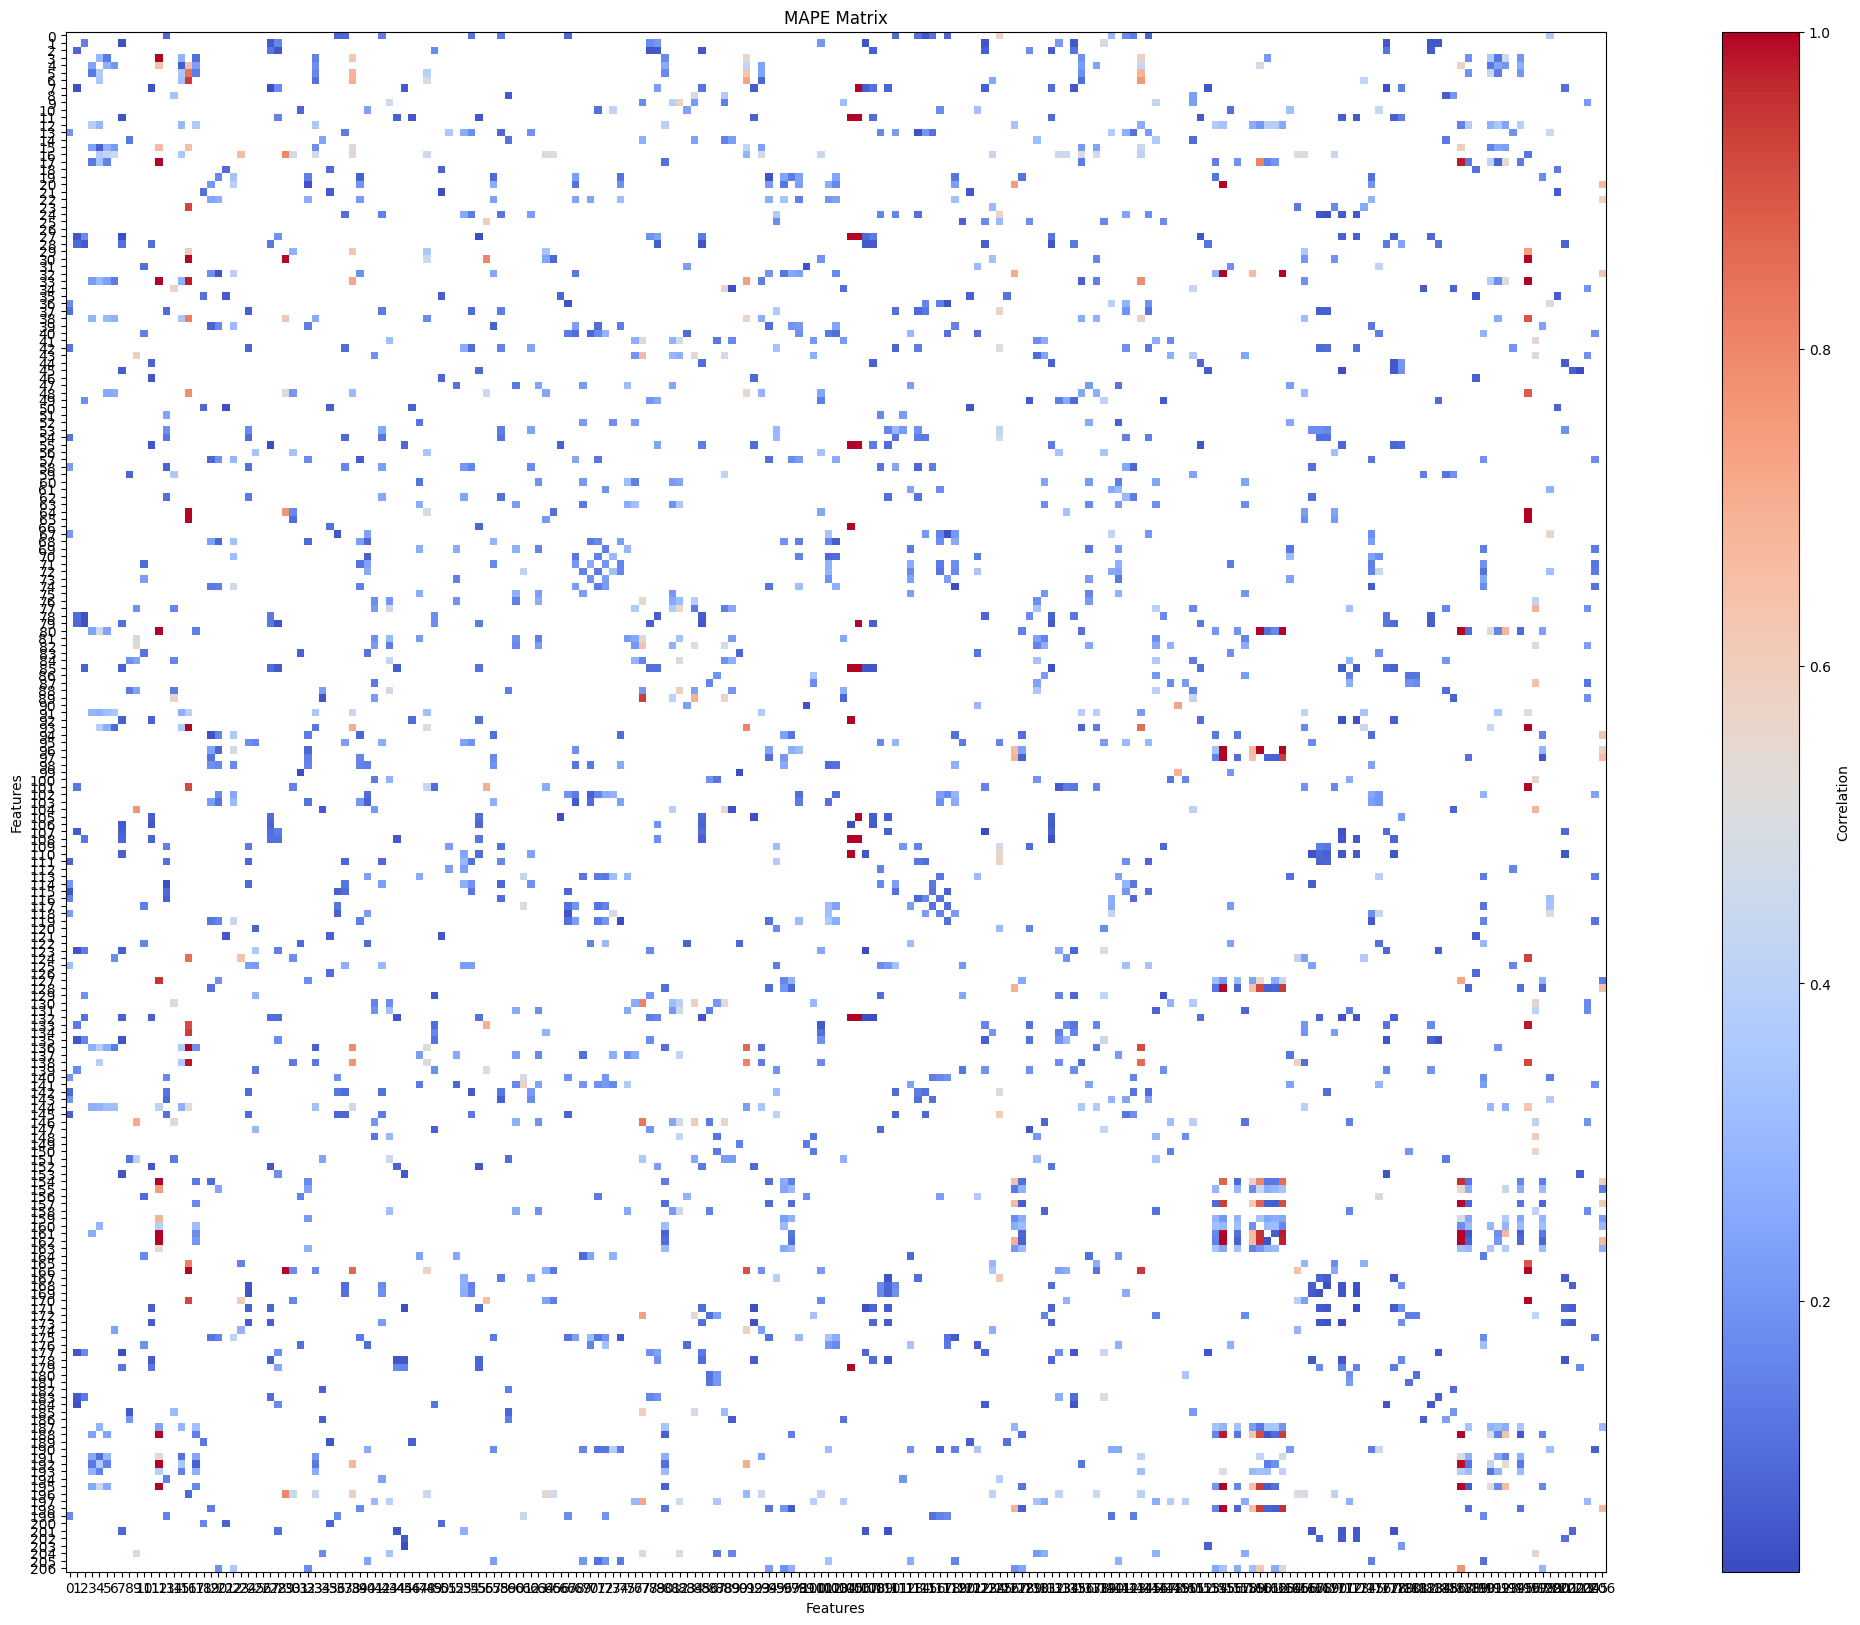

In [5]:
features_raw = torch.tensor(dataset.dataframe().values).T
# features_raw = features_raw[:, 1:] - features_raw[:, :-1]
s = features_raw.shape[0]
mape_mat = np.zeros((s, s))
for i in range(s):
    for j in range(s):
        mape_mat[i, j] = numpy_metrics.mape(features_raw[i], features_raw[j])

mape_mat = np.where(adj[:s, :s] > 0, mape_mat, np.ones_like(mape_mat)*(-np.inf))

# Plot heatmap using Matplotlib
plt.figure(figsize=(30, 20))
plt.imshow(mape_mat, cmap="coolwarm", interpolation="nearest", vmax=1)
plt.colorbar(label="Correlation")

# # Add text annotations
# for i in range(mape_mat.shape[0]):
#     for j in range(mape_mat.shape[1]):
#         plt.text(j, i, f"{mape_mat[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("MAPE Matrix")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(mape_mat.shape[0]))
plt.yticks(range(mape_mat.shape[1]))
plt.show()

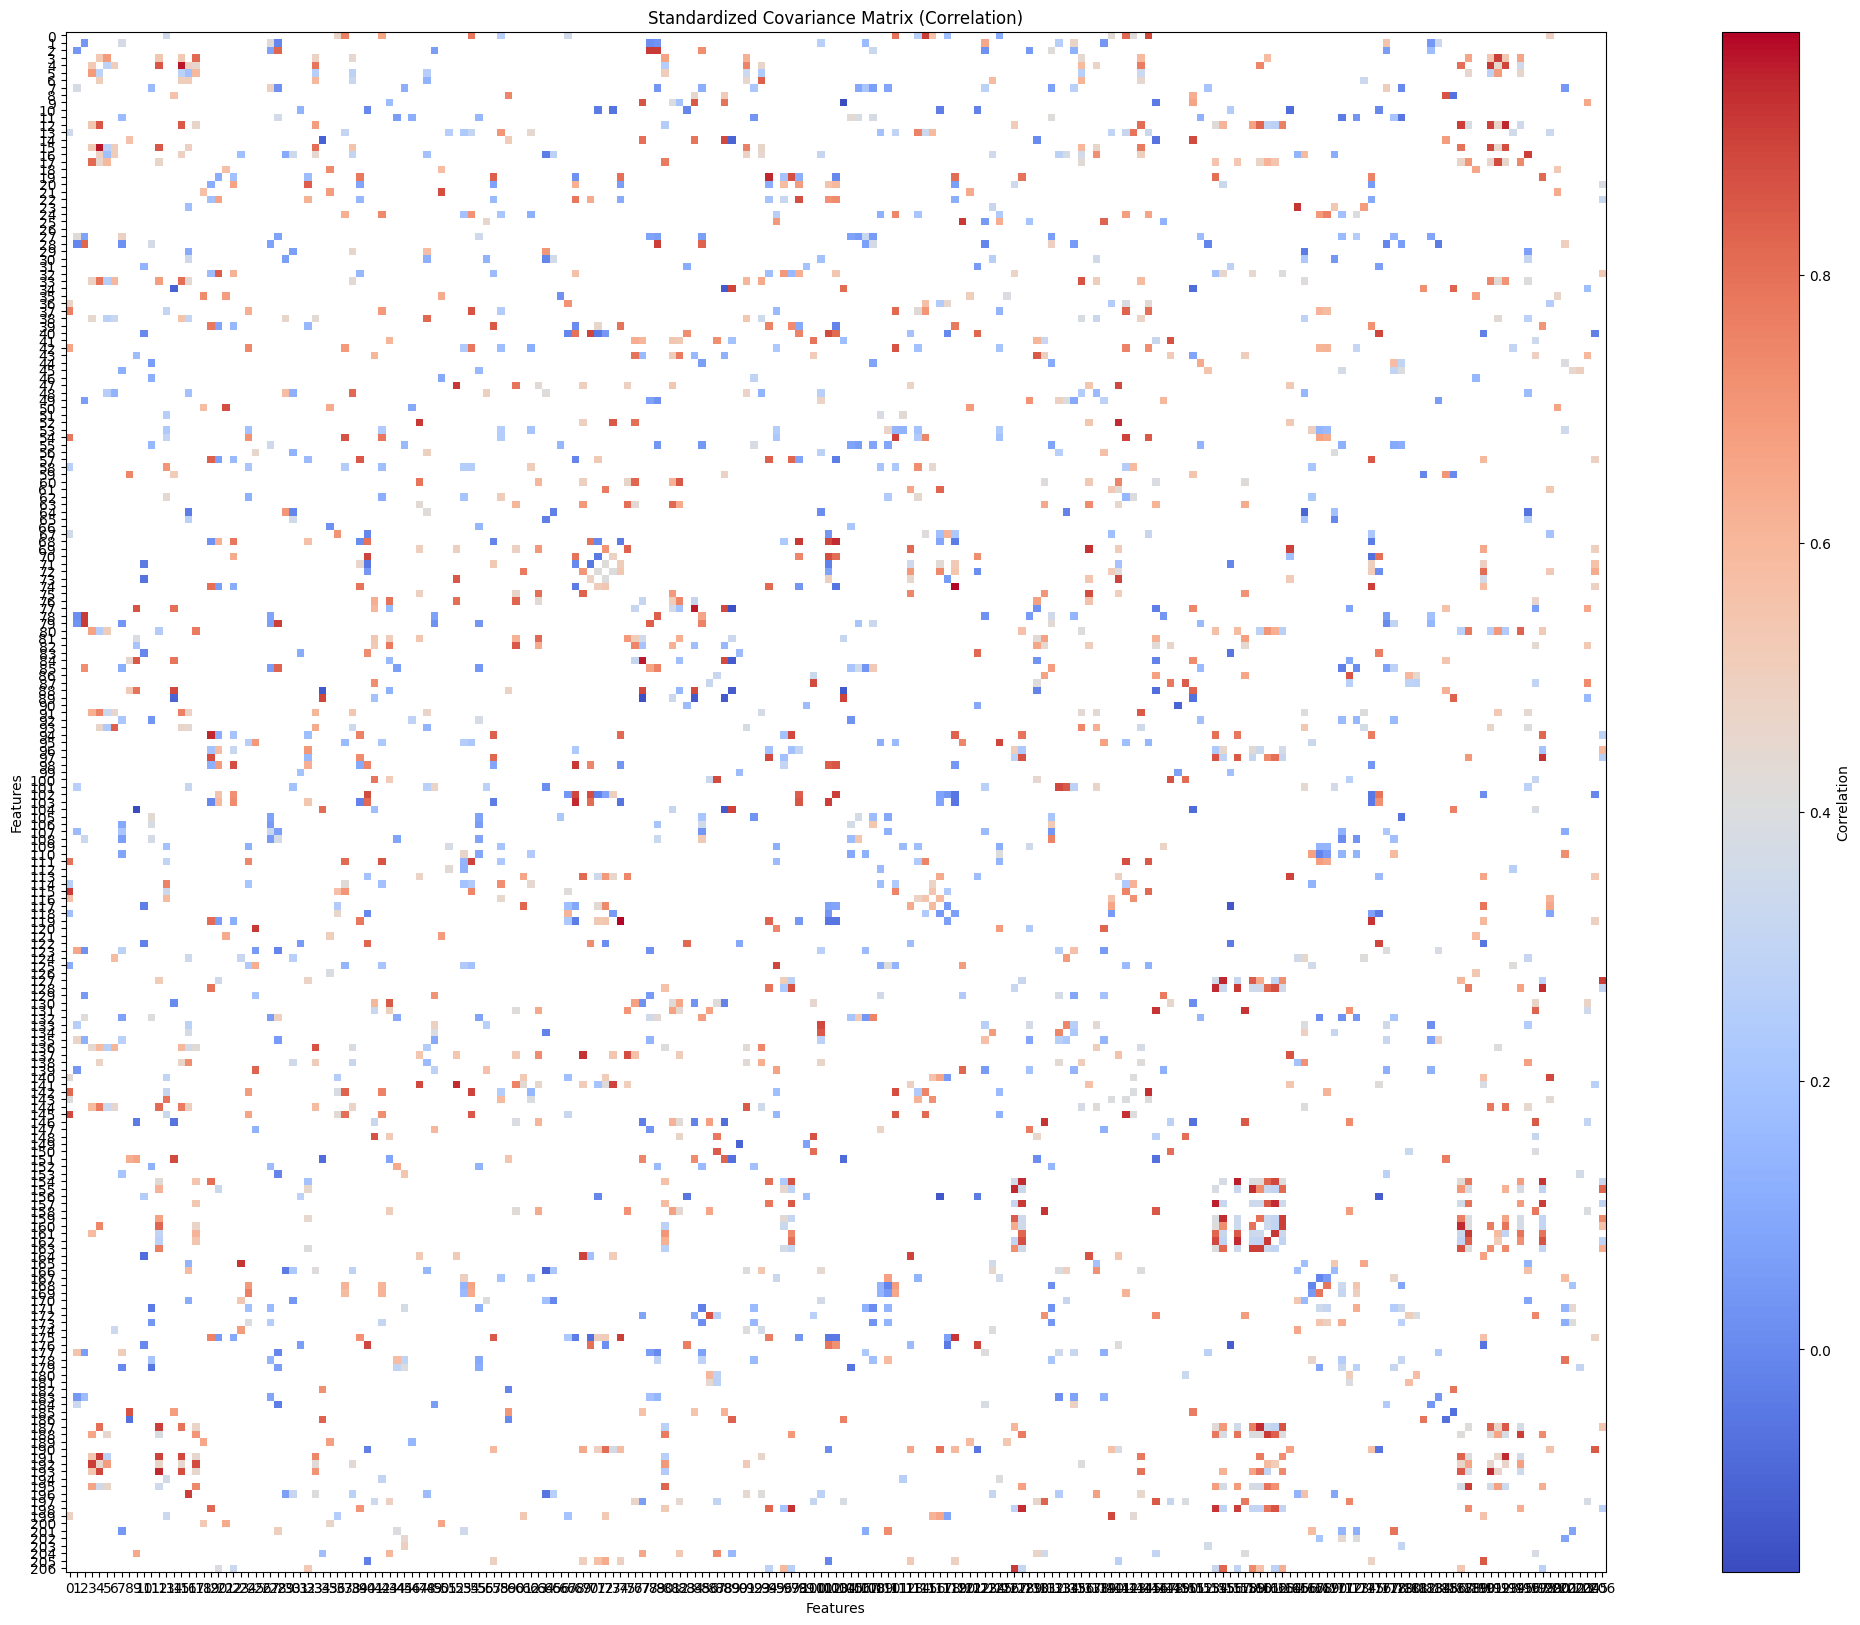

In [22]:
features_raw = torch.tensor(dataset.dataframe().values).T
cov_mat = np.cov(features_raw.T, rowvar=False, bias=False)

std_devs = np.sqrt(np.diag(cov_mat))
std_dev_outer = np.outer(std_devs, std_devs)

standardized_cov_matrix_real = np.divide(cov_mat, std_dev_outer, where=std_dev_outer != 0)

standardized_cov_matrix_real = np.where(adj > 0, standardized_cov_matrix_real, np.ones_like(standardized_cov_matrix_real)*(-np.inf))
# Plot heatmap using Matplotlib
plt.figure(figsize=(30, 20))
plt.imshow(standardized_cov_matrix_real, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")

# # Add text annotations
# for i in range(standardized_cov_matrix.shape[0]):
#     for j in range(standardized_cov_matrix.shape[1]):
#         plt.text(j, i, f"{standardized_cov_matrix[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("Standardized Covariance Matrix (Correlation)")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(standardized_cov_matrix_real.shape[0]))
plt.yticks(range(standardized_cov_matrix_real.shape[1]))
plt.show()

In [171]:
sparse_adj = dense_to_sparse(torch.tensor(adj))
edges, weights = get_ppr(sparse_adj[0], alpha=0.001, eps=0.01, target=torch.tensor(list(range(207))))

In [ ]:
from torch_geometric.utils import get_ppr

sparse_adj = dense_to_sparse(torch.tensor(adj))
edges, weights = get_ppr(sparse_adj[0], alpha=0.0001, num_nodes=207)

ppr_mat = torch.ones_like(torch.tensor(adj))
for i in range(weights.shape[0]):
    ppr_mat[edges[0, i], edges[1, i]] = weights[i]
    ppr_mat[edges[1, i], edges[0, i]] = weights[i]

In [ ]:
# ppr_fin = torch.where(torch.tensor(adj) > 0, ppr_mat, torch.ones_like(ppr_mat)*(-np.inf))
# ppr_fin = torch.nn.functional.softmax(ppr_fin) * torch.tensor(adj)
# ppr_fin = ppr_mat * torch.tensor(adj)
ppr_fin = torch.where(torch.tensor(adj) > 0, ppr_mat, torch.ones_like(ppr_mat)*(-np.inf))
# ppr_fin = torch.nn.functional.softmax(ppr_fin)
# ppr_fin = torch.where(torch.tensor(adj) > 0, ppr_fin, torch.ones_like(ppr_mat)*(-np.inf))
plt.figure(figsize=(30, 20))
plt.imshow(ppr_fin, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")

# # Add text annotations
# for i in range(standardized_cov_matrix.shape[0]):
#     for j in range(standardized_cov_matrix.shape[1]):
#         plt.text(j, i, f"{standardized_cov_matrix[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("Standardized Covariance Matrix (Correlation)")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(ppr_fin.shape[0]))
plt.yticks(range(ppr_fin.shape[1]))
plt.show()

In [284]:
import torch.nn.functional as F

rights = torch.nan_to_num(torch.tensor(standardized_cov_matrix_real), neginf=0)
lefts = torch.nan_to_num(ppr_fin, neginf=0)
ind= 0
kls = []
for i in range(rights.shape[0]):
    right = rights[i][torch.nonzero(rights[i])].squeeze()
    left = lefts[i][torch.nonzero(lefts[i])].squeeze()
    kls.append(torch.nn.functional.kl_div(F.log_softmax(torch.ones_like(left)), F.softmax(right)))

In [285]:
F.log_softmax(left), F.softmax(right)

(tensor([-2.8383, -2.8406, -2.8350, -2.8365, -2.8331, -2.8322, -2.8329, -2.8321,
         -2.8287, -2.8302, -2.8325, -2.8312, -2.8317, -2.8326, -2.8308, -2.8347,
         -2.8315]),
 tensor([0.0530, 0.0500, 0.0605, 0.0475, 0.0648, 0.0467, 0.0889, 0.0488, 0.0498,
         0.0813, 0.0484, 0.0747, 0.0628, 0.0477, 0.0672, 0.0608, 0.0471],
        dtype=torch.float64))

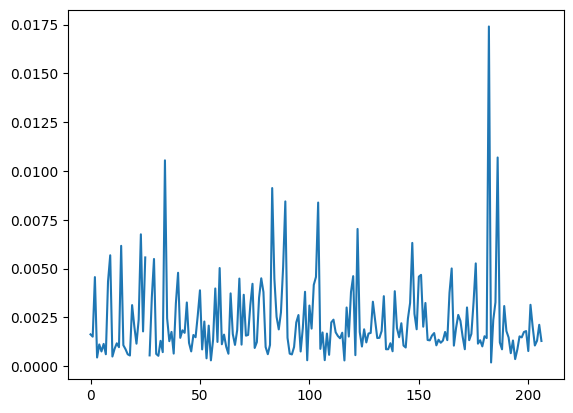

In [283]:
plt.plot(kls)

In [10]:
from scipy.linalg import expm

L = np.diag(adj.sum(axis=1)) - adj  # unnormalized Laplacian
t = 1.0
H = expm(-t * L)
H = torch.tensor(H)

In [ ]:
H = torch.where(torch.tensor(adj) > 0, H, torch.ones_like(H)*(-np.inf))
H = torch.nn.functional.softmax(H)
H = torch.where(torch.tensor(adj) > 0, H, torch.ones_like(H)*(-np.inf))
plt.figure(figsize=(30, 20))
plt.imshow(H, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")

# # Add text annotations
# for i in range(standardized_cov_matrix.shape[0]):
#     for j in range(standardized_cov_matrix.shape[1]):
#         plt.text(j, i, f"{standardized_cov_matrix[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("Standardized Covariance Matrix (Correlation)")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(H.shape[0]))
plt.yticks(range(H.shape[1]))
plt.show()

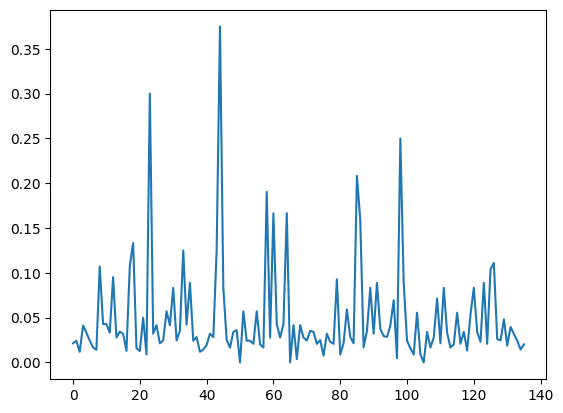

In [9]:
import torch.nn.functional as F

# mask_s= [ 40,  43,  79,  22, 117, 125, 103, 141, 138, 136, 197, 127, 111, 32,  91,  77,  68,  71,  20,  19,  42,  24,   3,  15,   5,  28, 17, 142, 206, 191, 144,  96, 119,  27,  72,  82,   0,  33,  13, 157, 146, 193, 196, 102,  85,  97, 171, 192, 128, 161,   7, 159, 190, 162, 132, 198, 166, 175, 155, 187,  80,   4, 195, 163, 160, 12, 188, 154,  16]
# mask_s= [172, 167, 137,  14,  49, 107, 105,  87,  73, 122, 115,  89, 139, 179,  67,  70,  76, 109,  69,   6,  63,  60, 140, 158, 199, 205, 204,  30,  78, 169, 131, 123, 118,   2, 177, 133, 110,  74,  95, 84,  57, 176,  41, 151, 145,  54,  58,  37,  39, 113, 101,  88, 108,  98,  53,  48,  11,   1, 114, 130, 135, 173, 178, 168,  93, 94,  81,  55,  38]
# mask_s= [26, 126, 149,  66, 182, 203,  51,  90, 112,  99, 200, 194, 181, 121,  46, 120, 150, 180,  18,  21,  23, 153, 189, 202,  65,  61, 31, 174, 147,  50,  56,  59,  29, 186, 184,  52,  83,   8, 165, 86,  34,  44,  45,  25, 35, 185, 152, 156, 116, 124,  92, 104, 134, 100, 106,  36, 148, 183,  75,  64,  10,   9,  62,  47, 129, 143, 164, 170, 201]
mask_s= [149,  10, 156,  90, 183,  64,  66,  55,  31, 118, 107,  99,  46, 27, 105, 179,   7,  65,  92,  11,  30, 171, 109, 184, 152, 177, 123, 135,   1,  53, 170,  89, 112, 173, 108,  28,  78, 132, 110, 153,  29,  44,  71,  62, 106,  67,  49, 129,  48,  85, 125, 122, 202, 167,  79, 178, 104, 196, 139, 194,   2, 166, 201,  58,  45, 114,  51,  96, 147]
mask_s = [i for i in range(138, 207)]
known = [i for i in range(207) if i not in mask_s]
cov_mat = torch.tensor(standardized_cov_matrix_real)
cov_mat_soft = F.softmax(cov_mat)
cov_mat_soft = torch.nan_to_num(cov_mat_soft, neginf = 0)

t_cur_mask = cov_mat[known, :]
t_cur_mask = t_cur_mask[:, known]
t_cur_mask = F.softmax(t_cur_mask)

ind = 0
from scipy.stats import wasserstein_distance

trunc = t_cur_mask[ind]
trunc, _ = torch.sort(trunc[trunc.nonzero()].squeeze())

reals = cov_mat_soft[ind]
reals, _ = torch.sort(reals[reals.nonzero()].squeeze())

# plt.plot(trunc)
# plt.plot(reals)
# plt.title(f'{wasserstein_distance(trunc, reals)}')
# plt.show()

wass = []
for ind in range(138):
    try:
        trunc = t_cur_mask[ind]
        trunc, _ = torch.sort(trunc[trunc.nonzero()].squeeze())

        reals = cov_mat_soft[ind]
        reals, _ = torch.sort(reals[reals.nonzero()].squeeze())

        wass.append(wasserstein_distance(trunc, reals))
    except:
        continue

plt.plot(wass)

In [38]:
test=torch.tensor([4, 5, 1])
quer=torch.tensor([4, 5, 1, 10])
wasserstein_distance(test, quer)

np.float64(1.6666666666666665)

tensor(1., dtype=torch.float64)


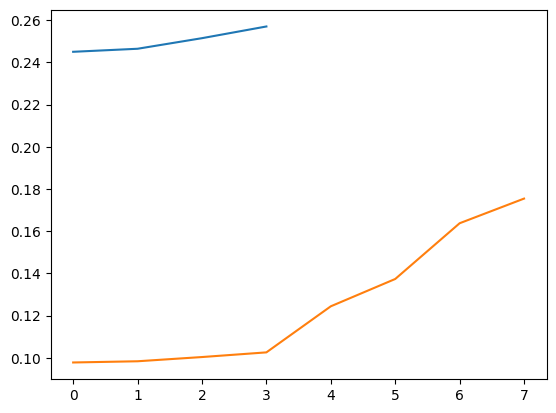

In [108]:
trunc = t_cur_mask[44]
trunc, _ = torch.sort(trunc[trunc.nonzero()].squeeze())

reals = cov_mat_soft[44]
reals, _ = torch.sort(reals[reals.nonzero()].squeeze())

plt.plot(trunc)
plt.plot(reals)

In [98]:
trunc, reals

(tensor([0.0640, 0.0726, 0.0970, 0.0875, 0.0992, 0.0592, 0.0647, 0.1000, 0.0591,
         0.1120, 0.0796, 0.0546, 0.0507], dtype=torch.float64),
 tensor([0.0449, 0.0510, 0.0681, 0.0614, 0.0697, 0.0415, 0.0454, 0.0702, 0.0415,
         0.0786, 0.0559, 0.0383, 0.0356, 0.0493, 0.0716, 0.0479, 0.0769, 0.0520],
        dtype=torch.float64))

In [7]:
features_raw_diff = features_raw[:, 2:] - features_raw[:, :-2]

In [8]:
cov_mat = np.cov(features_raw_diff.T, rowvar=False, bias=False)

std_devs = np.sqrt(np.diag(cov_mat))
std_dev_outer = np.outer(std_devs, std_devs)

standardized_cov_matrix = np.divide(cov_mat, std_dev_outer, where=std_dev_outer != 0)

In [9]:
standardized_cov_matrix = np.where(adj > 0, standardized_cov_matrix, np.zeros_like(standardized_cov_matrix))

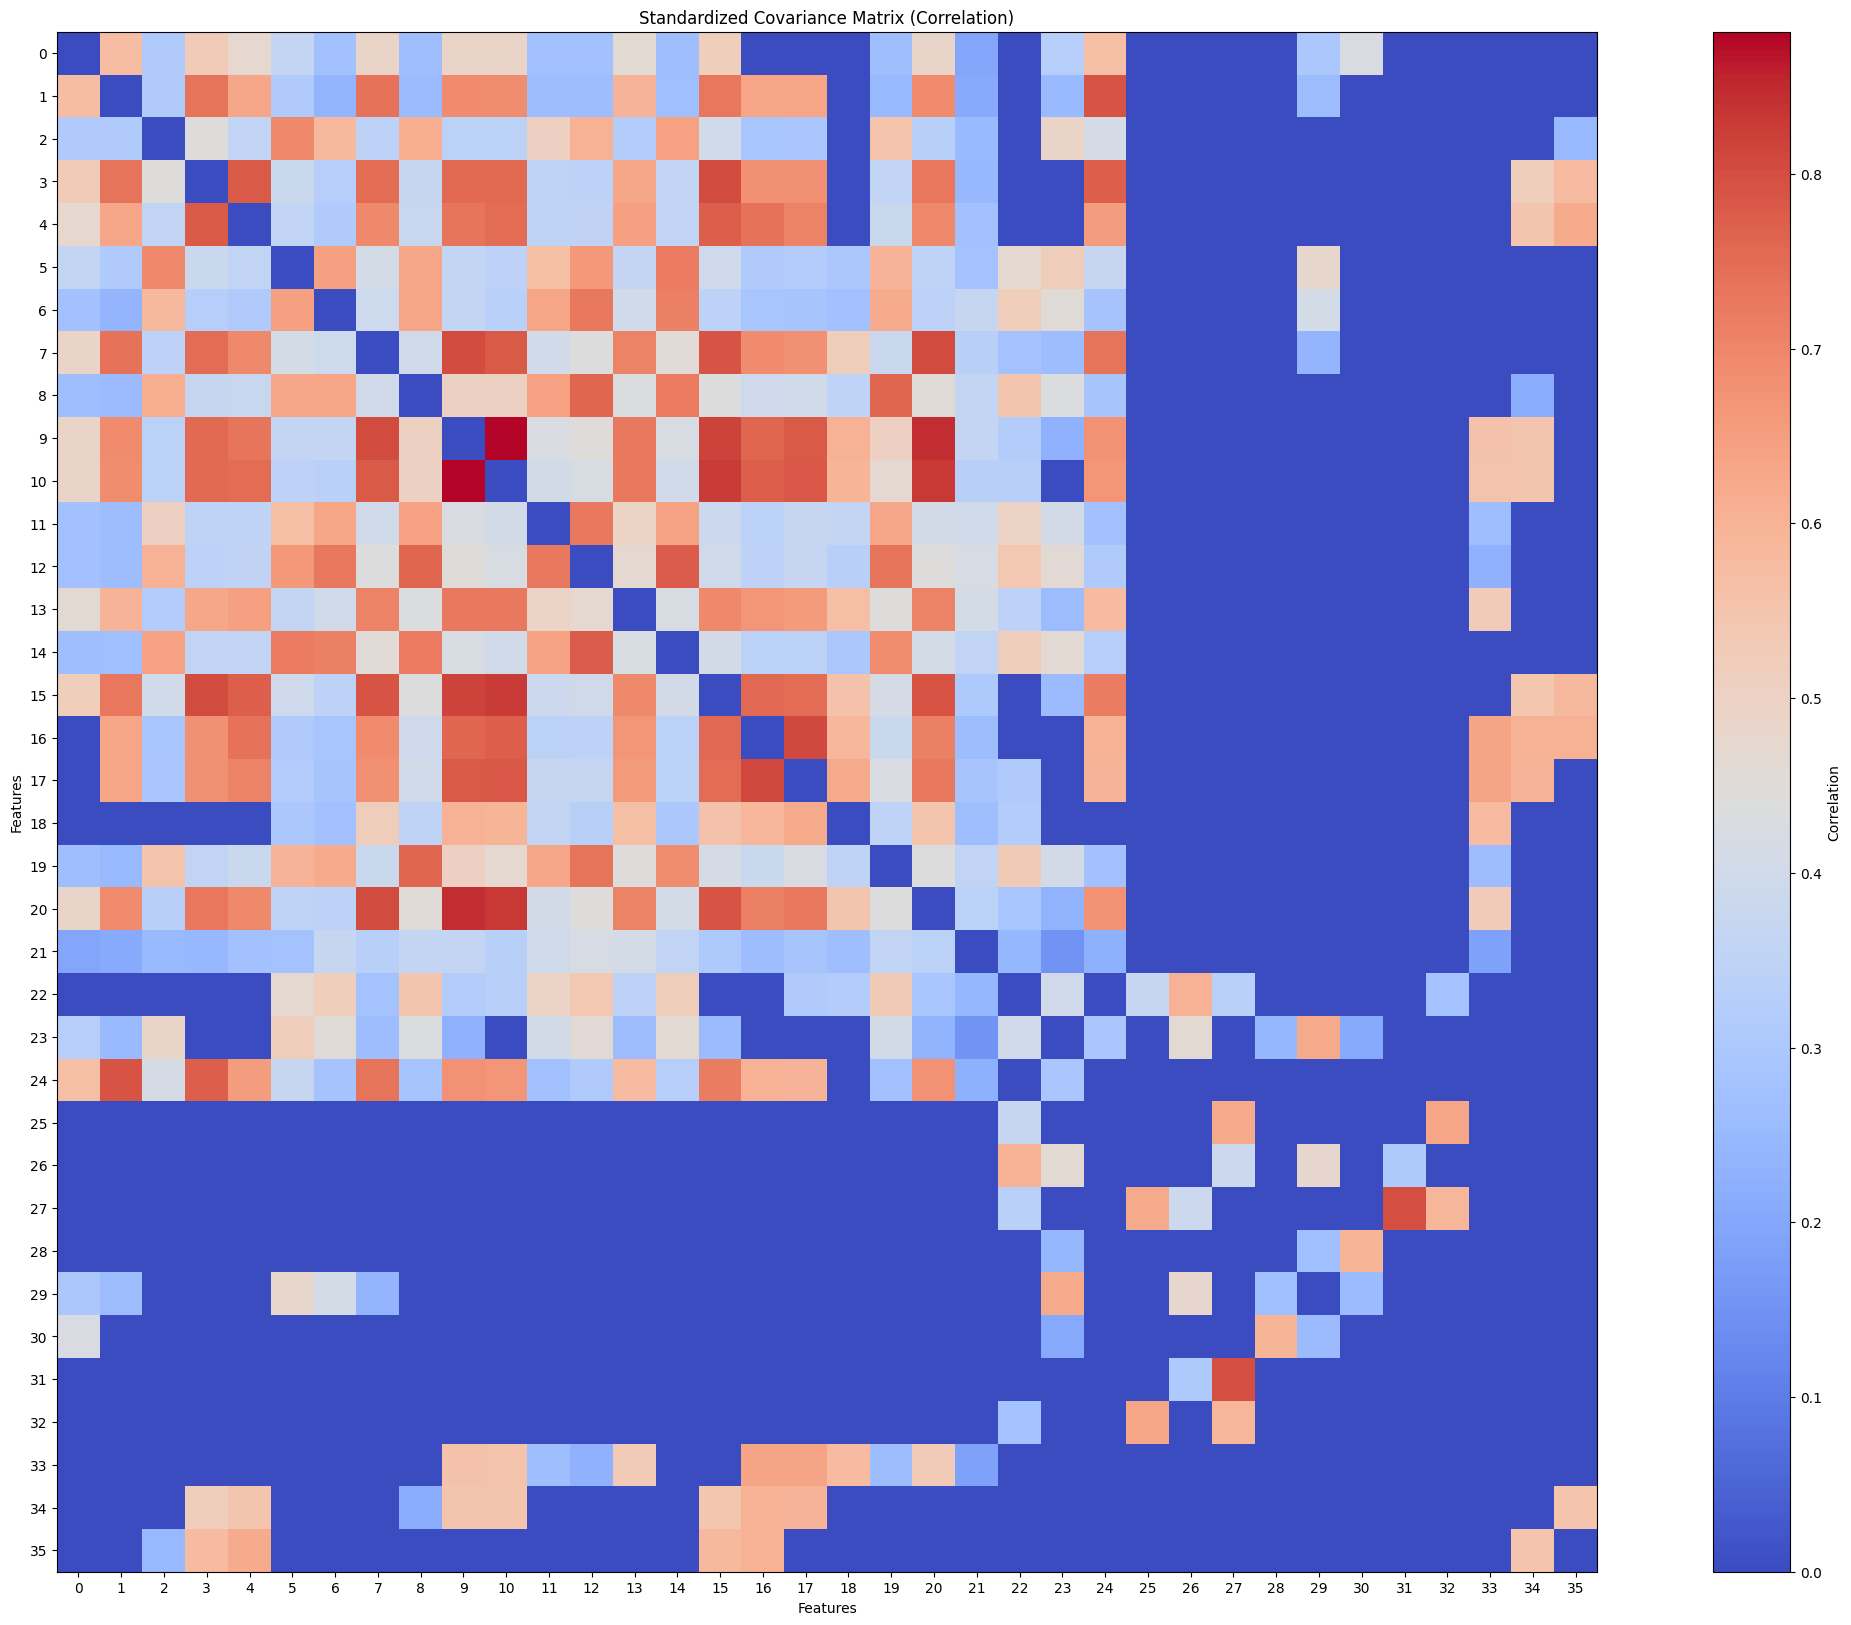

In [10]:
# Plot heatmap using Matplotlib
plt.figure(figsize=(30, 20))
plt.imshow(standardized_cov_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")

# # Add text annotations
# for i in range(standardized_cov_matrix.shape[0]):
#     for j in range(standardized_cov_matrix.shape[1]):
#         plt.text(j, i, f"{standardized_cov_matrix[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("Standardized Covariance Matrix (Correlation)")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(standardized_cov_matrix.shape[0]))
plt.yticks(range(standardized_cov_matrix.shape[1]))
plt.show()

In [ ]:
from torch_geometric.utils import get_ppr

sparse_adj = dense_to_sparse(torch.tensor(adj))
get_ppr(sparse_adj[0], num_nodes=207, target=torch.tensor([0, 1]))

(tensor([[  0,   0,   0,  ..., 206, 206, 206],
         [  0,  37,  24,  ...,  46, 187, 198]]),
 tensor([1.2735e-01, 2.5194e-02, 1.9771e-02,  ..., 1.3982e-05, 2.3557e-02,
         2.5746e-02]))

In [13]:
sparse_adj[0][:, 10]

tensor([ 0, 11])

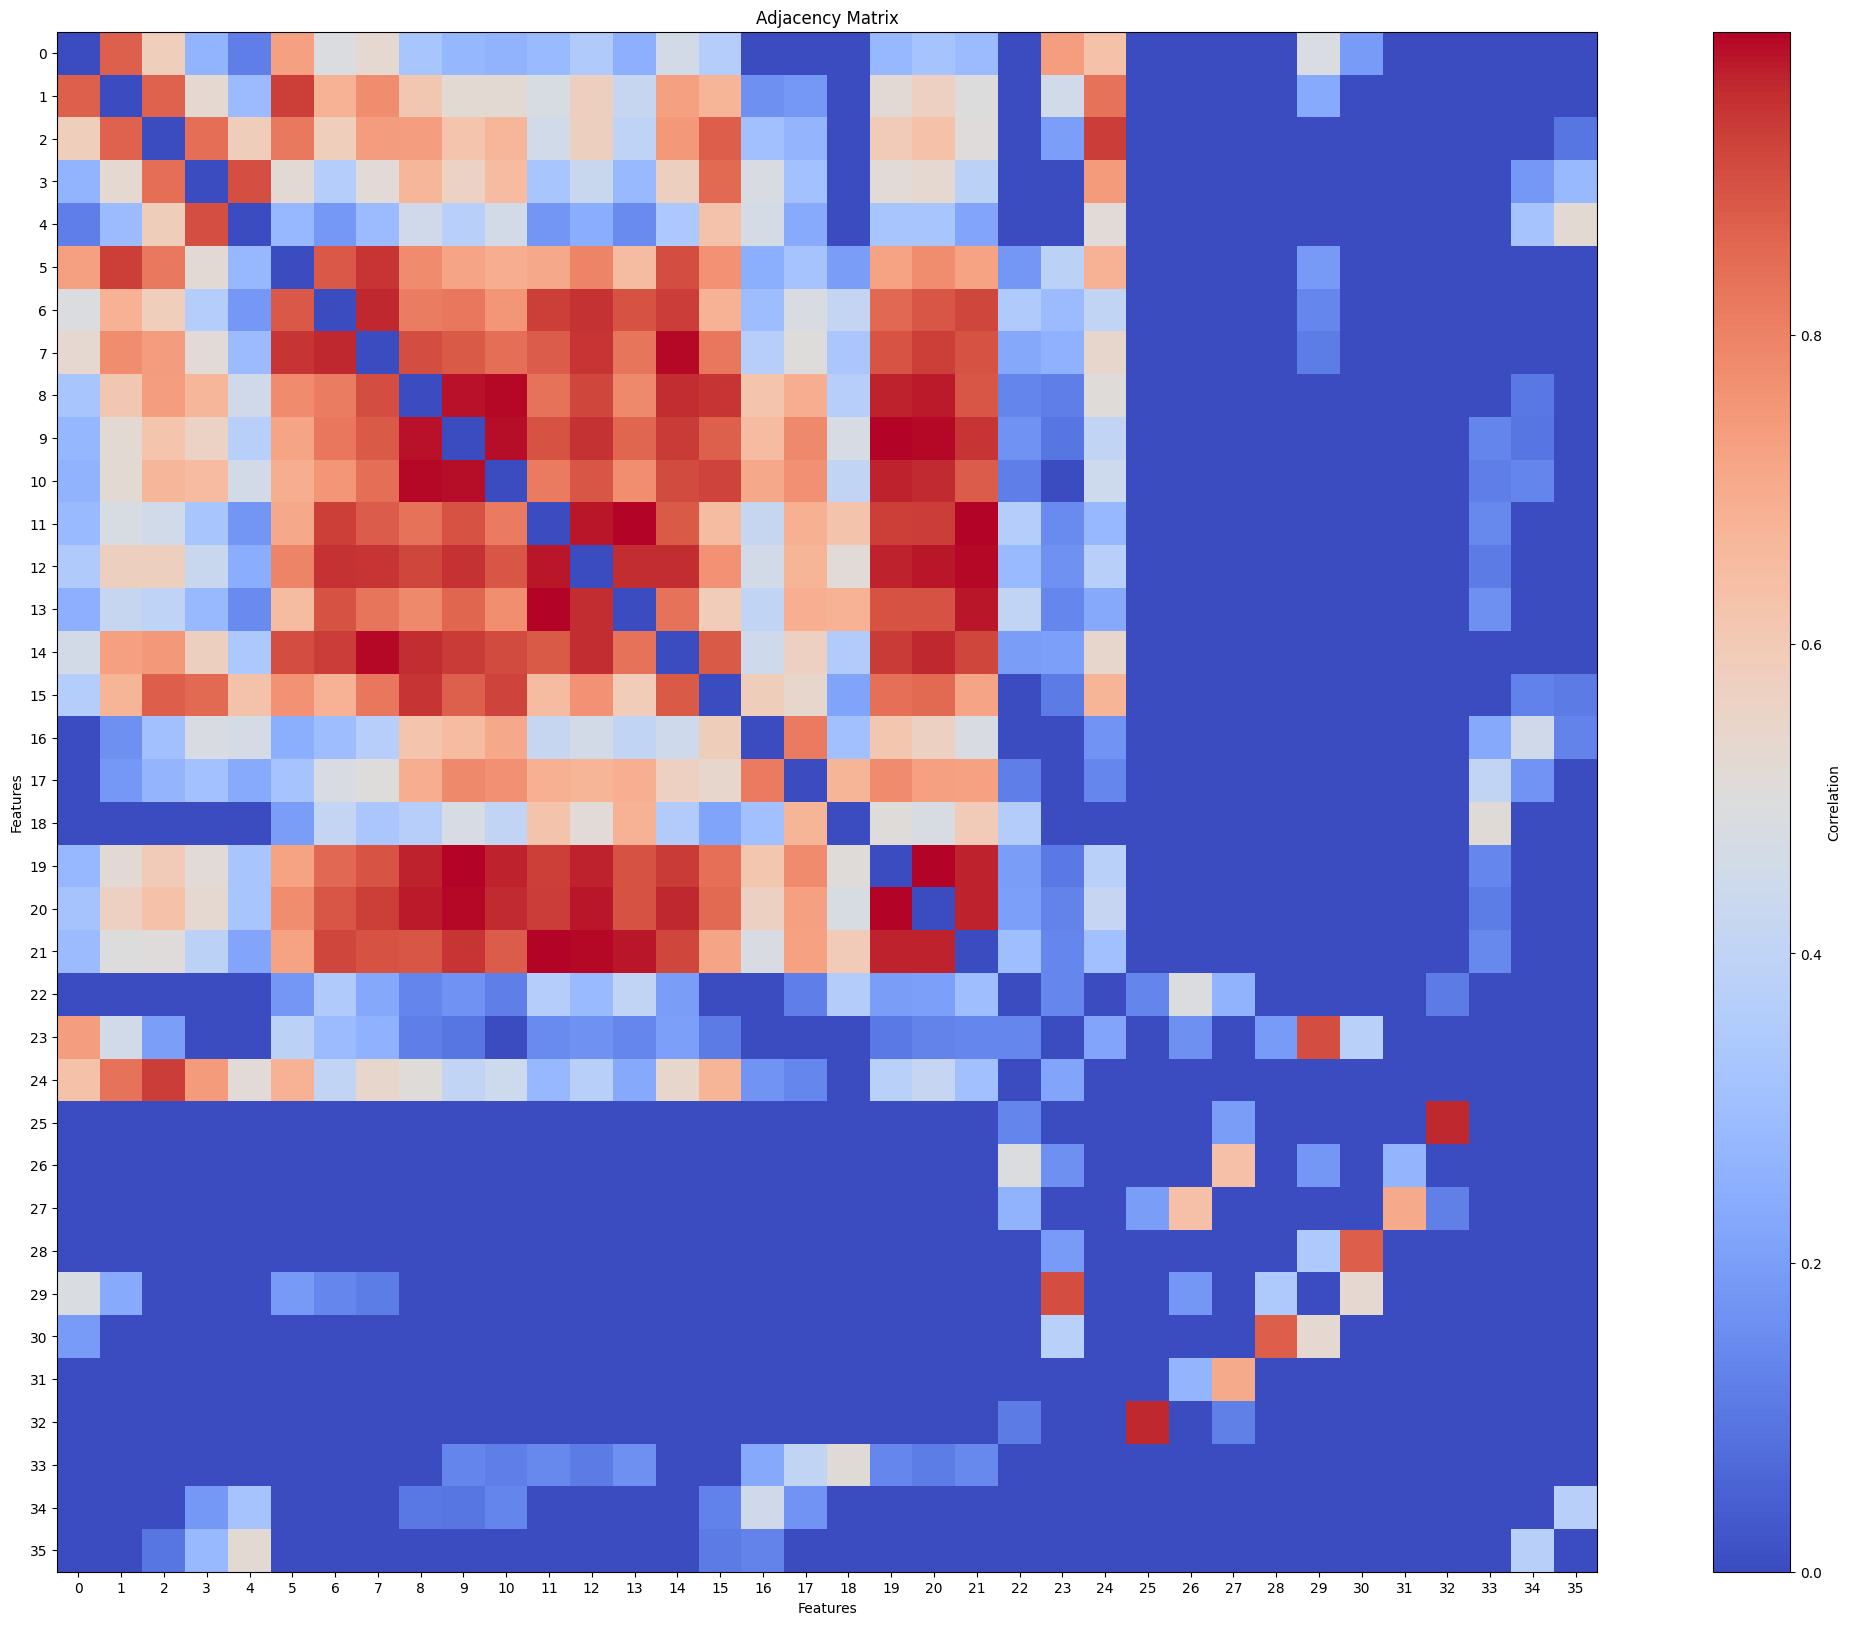

In [14]:
adj

# Plot heatmap using Matplotlib
plt.figure(figsize=(30, 20))
plt.imshow(adj, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")

# # Add text annotations
# for i in range(adj.shape[0]):
#     for j in range(adj.shape[1]):
#         plt.text(j, i, f"{adj[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("Adjacency Matrix")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(adj.shape[0]))
plt.yticks(range(adj.shape[1]))
plt.show()

In [15]:
def centering(M):
    """
    Calculate the centering matrix
    """
    n = M.shape[0]
    unit = np.ones([n, n])
    identity = np.eye(n)
    H = identity - unit/n

    return np.matmul(M, H)

def gaussian_grammat(x, sigma=None):
    """
    Calculate the Gram matrix of x using a Gaussian kernel.
    If the bandwidth sigma is None, it is estimated using the median heuristic:
    ||x_i - x_j||**2 = 2 sigma**2
    """
    try:
        x.shape[1]
    except IndexError:
        x = x.reshape(x.shape[0], 1)

    xxT = np.matmul(x, x.T)
    xnorm = np.diag(xxT) - xxT + (np.diag(xxT) - xxT).T
    if sigma is None:
        mdist = np.median(xnorm[xnorm!= 0])
        sigma = np.sqrt(mdist*0.5)


   # --- If bandwidth is 0, add machine epsilon to it
    if sigma==0:
        eps = 7./3 - 4./3 - 1
        sigma += eps

    KX = - 0.5 * xnorm / sigma / sigma
    np.exp(KX, KX)
    return KX

def dHSIC_calc(K_list):
    """
    Calculate the HSIC estimator in the general case d > 2, as in
    [2] Definition 2.6
    """
    if not isinstance(K_list, list):
        K_list = list(K_list)

    n_k = len(K_list)

    length = K_list[0].shape[0]
    term1 = 1.0
    term2 = 1.0
    term3 = 2.0/length

    for j in range(0, n_k):
        K_j = K_list[j]
        term1 = np.multiply(term1, K_j)
        term2 = 1.0/length/length*term2*np.sum(K_j)
        term3 = 1.0/length*term3*K_j.sum(axis=0)

    term1 = np.sum(term1)
    term3 = np.sum(term3)
    dHSIC = (1.0/length)**2*term1+term2-term3
    return dHSIC

def HSIC(x, y):
    """
    Calculate the HSIC estimator for d=2, as in [1] eq (9)
    """
    n = x.shape[0]
    return np.trace(np.matmul(centering(gaussian_grammat(x)),centering(gaussian_grammat(y))))/n/n

In [16]:
split_tens = features_raw[:, features_raw.shape[1]%24:]
split_tens = split_tens.view(36, 24, -1)
split_tens = split_tens.numpy()

hsic_mat = np.zeros((36, 36))
for i in range(36):
    for j in range(36):
        hsic_mat[i, j] = HSIC(split_tens[i], split_tens[j])

In [ ]:
# Plot heatmap using Matplotlib
plt.figure(figsize=(30, 20))
plt.imshow(hsic_mat, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")

# Add text annotations
for i in range(hsic_mat.shape[0]):
    for j in range(hsic_mat.shape[1]):
        plt.text(j, i, f"{hsic_mat[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("HSIC")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(hsic_mat.shape[0]))
plt.yticks(range(hsic_mat.shape[1]))
plt.show()

In [18]:
import scipy as sc

sc.special.kl_div(split_tens[0], split_tens[1])

array([[5.46436191e-01, 6.42117357e+00, 3.02953458e+00, ...,
        9.65082765e-01, 1.11647375e-01, 6.61836714e-02],
       [2.62479186e+00, 3.31602240e+00, 5.87522268e-01, ...,
        1.87592804e-01, 1.04145980e+00, 2.68031740e+00],
       [2.34336162e+00, 1.45637905e-02, 2.33182997e-01, ...,
        1.49714553e+00, 2.10320759e+00, 2.06901450e-02],
       ...,
       [5.20627052e-02, 0.00000000e+00, 5.42705990e-02, ...,
        1.24149680e-01, 1.25886515e-01, 3.97271603e-01],
       [1.24149807e-01, 3.58105730e-03, 1.07082650e-02, ...,
        2.83432770e+00, 5.75487375e+00, 6.24970436e+00],
       [3.35421448e+01, 3.19357085e+00, 7.03008461e+00, ...,
        2.36923322e-01, 6.06211185e-01, 2.40084499e-01]], dtype=float32)

In [7]:
np.sum(adj, axis=0)

array([ 6.563305  ,  6.797982  ,  6.1461477 ,  7.4977484 ,  8.1896715 ,
        7.33782   ,  4.153949  ,  7.43919   ,  3.7544549 ,  3.4933183 ,
        3.886418  ,  5.621229  ,  8.669299  ,  7.123162  ,  5.383475  ,
        8.184584  ,  8.571941  ,  8.108469  ,  2.2595234 ,  7.663463  ,
        6.831241  ,  2.949755  ,  7.5988884 ,  2.1104774 ,  7.2944026 ,
        3.008777  ,  0.        ,  7.243592  ,  6.2491574 ,  2.9272332 ,
        5.2205906 ,  2.6581042 ,  6.404194  ,  8.014985  ,  3.202995  ,
        2.633076  ,  3.8769984 ,  7.6821613 ,  6.121014  ,  7.2040334 ,
        6.099898  ,  6.167456  ,  7.1447167 ,  7.664697  ,  2.4232035 ,
        2.9662359 ,  0.8659259 ,  5.674803  ,  5.6530185 ,  4.5005116 ,
        2.883383  ,  1.4334149 ,  3.6379397 ,  6.008358  ,  7.7143736 ,
        6.3732047 ,  1.8874571 ,  5.738648  ,  5.9354925 ,  2.7540464 ,
        5.418406  ,  3.0530975 ,  4.627817  ,  5.4442554 ,  2.7225122 ,
        1.8947186 ,  0.67303646,  4.082276  ,  7.7851257 ,  5.38

In [4]:
# mask_s= [ 40,  43,  79,  22, 117, 125, 103, 141, 138, 136, 197, 127, 111, 32,  91,  77,  68,  71,  20,  19,  42,  24,   3,  15,   5,  28, 17, 142, 206, 191, 144,  96, 119,  27,  72,  82,   0,  33,  13, 157, 146, 193, 196, 102,  85,  97, 171, 192, 128, 161,   7, 159, 190, 162, 132, 198, 166, 175, 155, 187,  80,   4, 195, 163, 160, 12, 188, 154,  16]
# mask_s= [172, 167, 137,  14,  49, 107, 105,  87,  73, 122, 115,  89, 139, 179,  67,  70,  76, 109,  69,   6,  63,  60, 140, 158, 199, 205, 204,  30,  78, 169, 131, 123, 118,   2, 177, 133, 110,  74,  95, 84,  57, 176,  41, 151, 145,  54,  58,  37,  39, 113, 101,  88, 108,  98,  53,  48,  11,   1, 114, 130, 135, 173, 178, 168,  93, 94,  81,  55,  38]
# mask_s= [26, 126, 149,  66, 182, 203,  51,  90, 112,  99, 200, 194, 181, 121,  46, 120, 150, 180,  18,  21,  23, 153, 189, 202,  65,  61, 31, 174, 147,  50,  56,  59,  29, 186, 184,  52,  83,   8, 165, 86,  34,  44,  45,  25, 35, 185, 152, 156, 116, 124,  92, 104, 134, 100, 106,  36, 148, 183,  75,  64,  10,   9,  62,  47, 129, 143, 164, 170, 201]
mask_s= [149,  10, 156,  90, 183,  64,  66,  55,  31, 118, 107,  99,  46, 27, 105, 179,   7,  65,  92,  11,  30, 171, 109, 184, 152, 177, 123, 135,   1,  53, 170,  89, 112, 173, 108,  28,  78, 132, 110, 153,  29,  44,  71,  62, 106,  67,  49, 129,  48,  85, 125, 122, 202, 167,  79, 178, 104, 196, 139, 194,   2, 166, 201,  58,  45, 114,  51,  96, 147]
# mask_s = range(12)

known_set = [i for i in range(adj.shape[0]) if i not in mask_s]
print(known_set)

g1_adj = adj
g1_adj = g1_adj[known_set, :]
g1_adj = g1_adj[:, known_set]
g1_x = torch.ones((g1_adj.shape[0], 1))/g1_adj.shape[0]

nx_g1 = nx.from_numpy_array(g1_adj)
nx.set_node_attributes(nx_g1, {ind:val for ind, val in enumerate(known_set)}, 'label')

g2_adj = adj
g2_adj = g2_adj[mask_s, :]
g2_adj = g2_adj[:, mask_s]
g2_x = torch.ones((g2_adj.shape[0], 1))/g2_adj.shape[0]

nx_g2 = nx.from_numpy_array(g2_adj)
nx.set_node_attributes(nx_g2, {ind:val for ind, val in enumerate(mask_s)}, 'label')

g3_adj = adj
g3_x = torch.ones((g3_adj.shape[0], 1))/g3_adj.shape[0]

nx_g3 = nx.from_numpy_array(g3_adj)
nx.set_node_attributes(nx_g3, {i:i for i in range(36)}, 'label')

[0, 3, 4, 5, 6, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 47, 50, 52, 54, 56, 57, 59, 60, 61, 63, 68, 69, 70, 72, 73, 74, 75, 76, 77, 80, 81, 82, 83, 84, 86, 87, 88, 91, 93, 94, 95, 97, 98, 100, 101, 102, 103, 111, 113, 115, 116, 117, 119, 120, 121, 124, 126, 127, 128, 130, 131, 133, 134, 136, 137, 138, 140, 141, 142, 143, 144, 145, 146, 148, 150, 151, 154, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 168, 169, 172, 174, 175, 176, 180, 181, 182, 185, 186, 187, 188, 189, 190, 191, 192, 193, 195, 197, 198, 199, 200, 203, 204, 205, 206]


In [8]:
g1_adj.shape, len(known_set)

((138, 138), 138)

In [8]:
from networkx.algorithms import approximation

approximation.average_clustering(nx_g1), approximation.average_clustering(nx_g2), approximation.average_clustering(nx_g3)

(0.623, 0.548, 0.558)

In [10]:
degree_sequence_g1 = sorted((d for n, d in nx_g1.degree()), reverse=True)
degree_sequence_g2 = sorted((d for n, d in nx_g3.degree() if n in mask_s), reverse=True)
degree_sequence_g3 = sorted((d for n, d in nx_g3.degree()), reverse=True)

In [11]:
import random
from torch.nn.functional import kl_div

class GraphStorage:
    def __init__(self, max_size, measure='random', distance_metric='euclidean'):
        self.adj_storage = [] # Fixed-size queue
        self.tensor_storage = []
        self.max_size = max_size
        self.measure = measure
        self.distance_metric = distance_metric
        self.distance_matrix = torch.empty((0, 0))

    def add_tensor(self, adj, new_tensor):
        """Adds a tensor, replacing the most redundant one if full."""
        if len(self.tensor_storage) < self.max_size:
            self.adj_storage.append(adj)
            self.tensor_storage.append(new_tensor)
            self._update_distance_matrix()
        else:
            new_distances = torch.tensor([self._distance(new_tensor, t) for t in self.tensor_storage])

            # Compute distances
            avg_distances = self.distance_matrix.mean(dim=1)
            new_tensor_avg_dist = new_distances.mean()

            # Find the most redundant tensor (smallest avg distance)
            min_dist_idx = avg_distances.argmin().item()

            # Replace if the new tensor has a higher avg distance
            if new_tensor_avg_dist > avg_distances[min_dist_idx]:
                self.adj_storage[min_dist_idx] = adj
                self.tensor_storage[min_dist_idx] = new_tensor  # Replace tensor
                self.distance_matrix[min_dist_idx, :] = new_distances
                self.distance_matrix[:, min_dist_idx] = new_distances

    def get_random_tensor(self):
        """Returns a random tensor from storage."""
        if not self.adj_storage:
            raise ValueError("Storage is empty!")
        
        match self.measure:
            case 'random':
                return random.choice(self.adj_storage)
        raise Exception('Invalid measure')

    def _average_distance(self, tensor):
        """Computes the average distance of a tensor to all stored tensors."""
        if not self.tensor_storage:
            return float('inf')  # If storage is empty, return a high value
        distances = [self._distance(tensor, t) for t in self.tensor_storage]
        return sum(distances) / len(distances)

    def _update_distance_matrix(self):
        """Recomputes the full distance matrix when a new tensor is added."""
        num_tensors = len(self.tensor_storage)
        new_matrix = torch.zeros((num_tensors, num_tensors))

        for i in range(num_tensors):
            for j in range(i + 1, num_tensors):  # Compute only upper triangle
                dist = self._distance(self.tensor_storage[i], self.tensor_storage[j])
                new_matrix[i, j] = dist
                new_matrix[j, i] = dist  # Symmetric matrix

        self.distance_matrix = new_matrix

    def _distance(self, t1, t2):
        t1, t2 = self._pad_to_same_size(t1, t2)  # Ensure equal size

        """Computes distance between two tensors."""
        if self.distance_metric == "euclidean":
            return torch.norm(t1 - t2).item()
        elif self.distance_metric == "cosine":
            return 1 - torch.nn.functional.cosine_similarity(t1, t2, dim=0).mean().item()
        elif self.distance_metric == 'kl':
            return kl_div(t1, t2, reduction='mean')
        else:
            raise ValueError("Unsupported distance metric")
    
    def _pad_to_same_size(self, t1, t2):
        """Pads the smaller tensor with zeros to match the larger tensor's size."""
        size1, size2 = t1.shape[-1], t2.shape[-1]
        if size1 < size2:
            t1 = torch.cat([t1, torch.zeros(size2 - size1, device=t1.device)])
        elif size2 < size1:
            t2 = torch.cat([t2, torch.zeros(size1 - size2, device=t2.device)])
        return t1, t2

In [12]:
def degree_distribution(adj_matrix):
    """Computes the degree distribution from an adjacency matrix."""
    adj_matrix = torch.where(adj_matrix > 0, torch.ones_like(adj_matrix), torch.zeros_like(adj_matrix))
    degrees = adj_matrix.sum(dim=1)  # Sum rows for undirected graph
    
    max_degree = int(degrees.max().item()) # Find the highest degree
    all_bins = torch.arange(max_degree + 1)  # Create bins from 0 to max degree

    # Count occurrences of each degree, filling missing degrees with zero counts
    degree_counts = torch.zeros(max_degree + 1, dtype=torch.long)
    unique_degrees, counts = torch.unique(degrees, return_counts=True)
    unique_degrees = unique_degrees.to(dtype=torch.long)
    degree_counts[unique_degrees] = counts  # Assign counts to correct bins

    # Normalize to get probability distribution
    distribution = degree_counts / degree_counts.sum()

    return all_bins, distribution

g3_adj = torch.tensor(g3_adj)
degree_distribution(torch.tensor(g3_adj))

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25]),
 tensor([0.0048, 0.0000, 0.0097, 0.0193, 0.0386, 0.0435, 0.0290, 0.0386, 0.0483,
         0.0483, 0.0435, 0.0676, 0.0773, 0.0242, 0.0580, 0.0918, 0.0870, 0.0966,
         0.0773, 0.0435, 0.0290, 0.0145, 0.0048, 0.0000, 0.0000, 0.0048]))

In [13]:
g3_adj = torch.tensor(g3_adj)
torch.where(g3_adj > 0, torch.ones_like(g3_adj), torch.zeros_like(g3_adj))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [14]:
def degree_probs(graph):
    degrees = [d for _, d in graph.degree()]  # Get degrees of all nodes
    # max_degree = max(degrees)  # Maximum degree in the graph
    degree_counts = np.bincount(degrees)  # Count occurrences of each degree
    probabilities = degree_counts / sum(degree_counts)  # Normalize to get probabilities
    return torch.tensor(probabilities, dtype=torch.float32) 

degree_probs(nx_g3)

tensor([0.0048, 0.0000, 0.0097, 0.0193, 0.0386, 0.0435, 0.0290, 0.0386, 0.0483,
        0.0483, 0.0435, 0.0676, 0.0773, 0.0242, 0.0580, 0.0918, 0.0870, 0.0966,
        0.0773, 0.0435, 0.0290, 0.0145, 0.0048, 0.0000, 0.0000, 0.0048])

In [15]:
# from scipy.special import kl_div
from torch.nn.functional import kl_div

g1_p = degree_probs(nx_g1)
g3_q = degree_probs(nx_g3)

# padding_n = max(g1_p.shape[0], g3_q.shape[0]) - min(g1_p.shape[0], g3_q.shape[0])
# if g3_q.shape[0] > g1_p.shape[0]:
#     g1_p = torch.cat((g1_p, torch.zeros(padding_n)), dim=0)
# else:
#     g3_q = torch.cat((g3_q, torch.zeros(padding_n)), dim=0)

print(g1_p, g1_p)
kl_div(g1_p, g1_p, reduction='mean')

tensor([0.0145, 0.0000, 0.0217, 0.0217, 0.0435, 0.0652, 0.0362, 0.0580, 0.0145,
        0.0652, 0.0507, 0.0652, 0.0942, 0.0652, 0.0362, 0.0725, 0.0797, 0.0580,
        0.0507, 0.0290, 0.0362, 0.0217]) tensor([0.0145, 0.0000, 0.0217, 0.0217, 0.0435, 0.0652, 0.0362, 0.0580, 0.0145,
        0.0652, 0.0507, 0.0652, 0.0942, 0.0652, 0.0362, 0.0725, 0.0797, 0.0580,
        0.0507, 0.0290, 0.0362, 0.0217])


tensor(-0.1359)

In [16]:
# from scipy.special import kl_div
from torch.nn.functional import kl_div

g1_p = degree_probs(nx_g1)
g3_q = degree_probs(nx_g3)

storage = GraphStorage(5, distance_metric='kl')
storage.add_tensor(g1_adj, g1_p)
storage.add_tensor(g3_adj, g3_q)
storage.add_tensor(g1_adj, g1_p)
storage.add_tensor(g1_adj, g1_p)
storage.add_tensor(g1_adj, g1_p)
storage.add_tensor(g1_adj, g1_p)
storage.add_tensor(g3_adj, g3_q)

In [17]:
g1_adj.shape

(138, 138)

In [18]:
storage.get_random_tensor().shape

(138, 138)

<BarContainer object of 23 artists>

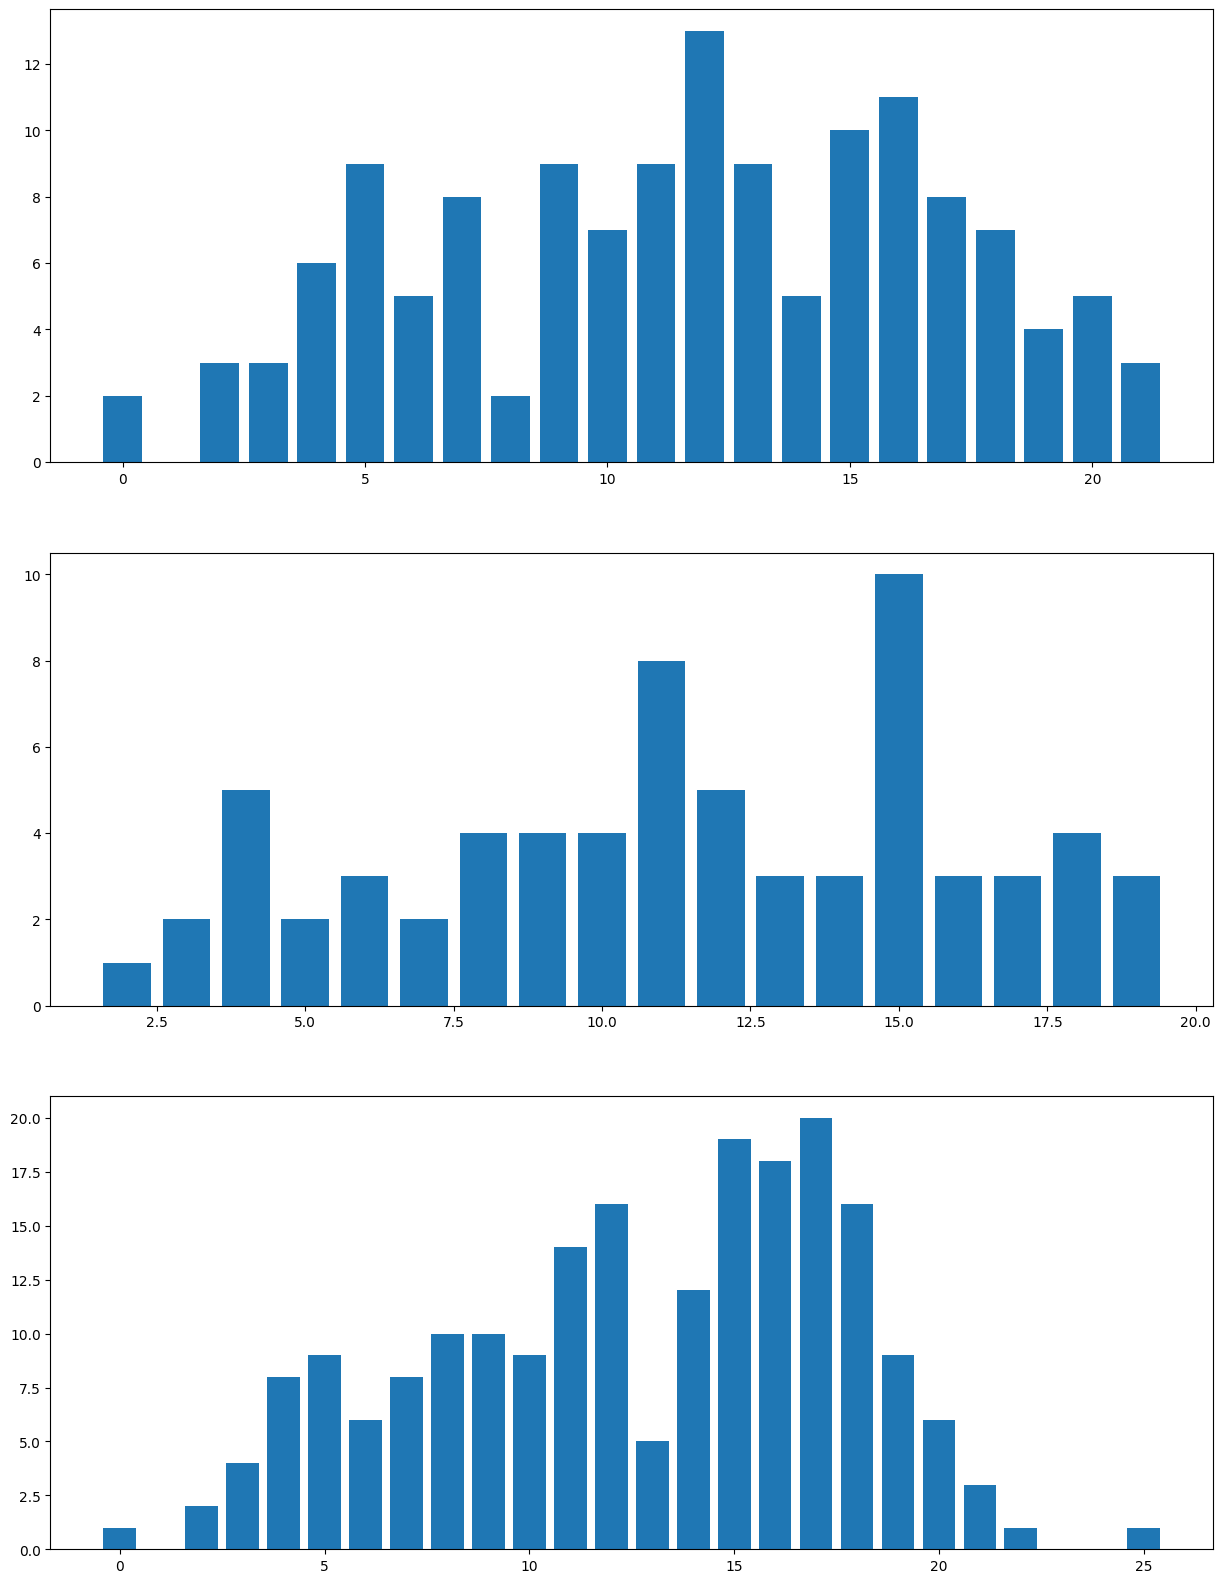

In [19]:
fig, axes = plt.subplots(3, 1, figsize=(15, 20))

axes[0].bar(*np.unique(degree_sequence_g1, return_counts=True))
axes[1].bar(*np.unique(degree_sequence_g2, return_counts=True))
axes[2].bar(*np.unique(degree_sequence_g3, return_counts=True))

In [20]:
adj_ind = dataset.get_connectivity(method='distance', threshold=0.1, include_self=False)[0]
adj_ind = torch.tensor(adj_ind)
# get_ppr(adj_ind)

In [21]:
nx_g3

In [13]:
nx.link_analysis.pagerank(nx_g3)

{0: 0.0058227870908439915,
 1: 0.006386479166632903,
 2: 0.005776987605380158,
 3: 0.004985222427982331,
 4: 0.005481211781814546,
 5: 0.005142860582429007,
 6: 0.003808684082373436,
 7: 0.007159584269145456,
 8: 0.004238869504679836,
 9: 0.0035096450056722743,
 10: 0.004572764597406176,
 11: 0.005938885193277357,
 12: 0.005233063216879461,
 13: 0.0065901312121047296,
 14: 0.00550436221633105,
 15: 0.005643978991632833,
 16: 0.007462109601201606,
 17: 0.0049941391548527555,
 18: 0.00513030814232839,
 19: 0.00529138616457797,
 20: 0.004801760287156991,
 21: 0.006491766564737518,
 22: 0.00539649110767103,
 23: 0.0030973335427365574,
 24: 0.00646429291839465,
 25: 0.003671295249481386,
 26: 0.0007276255154014069,
 27: 0.006571884056595423,
 28: 0.00600723920598462,
 29: 0.0030968673495999546,
 30: 0.005270311141226352,
 31: 0.004077135978611666,
 32: 0.004307173817717511,
 33: 0.005808093811580175,
 34: 0.004052136473376334,
 35: 0.005976290363507518,
 36: 0.0038513415104862877,
 37: 0.00

In [14]:
nx.link_analysis.pagerank(nx_g1), nx.link_analysis.pagerank(nx_g2), nx.link_analysis.pagerank(nx_g3)

({0: 0.005534367472953192,
  1: 0.00714640123613738,
  2: 0.005444426679917598,
  3: 0.005021374755323734,
  4: 0.008509071171688611,
  5: 0.004648241411319003,
  6: 0.005537336234671866,
  7: 0.0056835160442951,
  8: 0.00515909118947034,
  9: 0.007004767106086727,
  10: 0.005799720067521985,
  11: 0.003623600350316589,
  12: 0.007242820792569375,
  13: 0.0041642018231305014,
  14: 0.0007725985063095546,
  15: 0.006895443744401713,
  16: 0.005576260666208204,
  17: 0.003555011225527585,
  18: 0.006055397723424255,
  19: 0.004128272451023519,
  20: 0.004634751001007506,
  21: 0.005546566885600308,
  22: 0.004497062242402663,
  23: 0.00645725867298843,
  24: 0.0038916536564308738,
  25: 0.006924619266858702,
  26: 0.005119321044392937,
  27: 0.005512232613808776,
  28: 0.005830651062704275,
  29: 0.006310308863303409,
  30: 0.006953132144206375,
  31: 0.0071102557826732,
  32: 0.003142082015424577,
  33: 0.00484791824152661,
  34: 0.0019628254873447085,
  35: 0.005627229155794821,
  36: 

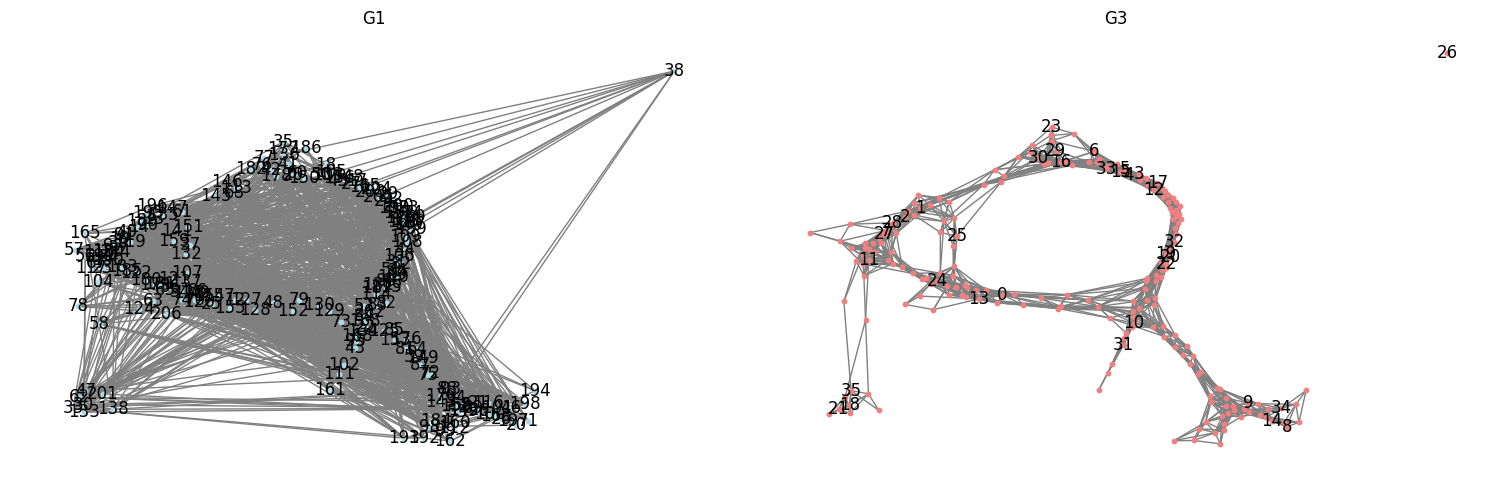

In [15]:
pos = nx.spring_layout(nx_g3, seed=42)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot G1
nx.draw(nx_g1, pos, with_labels=False, ax=axes[0], node_color='lightblue', edge_color='gray', node_size=10)
axes[0].set_title("G1")

node_labels = nx.get_node_attributes(nx_g1, "label")
nx.draw_networkx_labels(nx_g1, pos, labels=node_labels, ax=axes[0], font_size=12, font_color="black")

# # Plot G2
# nx.draw(nx_g2, pos, with_labels=False, ax=axes[1], node_color='lightgreen', edge_color='gray', node_size=10)
# axes[1].set_title("G2")

# node_labels = nx.get_node_attributes(nx_g2, "label")
# nx.draw_networkx_labels(nx_g2, pos, labels=node_labels, ax=axes[1], font_size=12, font_color="black")

# Plot G3
nx.draw(nx_g3, pos, with_labels=False, ax=axes[1], node_color='lightcoral', edge_color='gray', node_size=10)
axes[1].set_title("G3")

node_labels = nx.get_node_attributes(nx_g3, "label")
nx.draw_networkx_labels(nx_g3, pos, labels=node_labels, ax=axes[1], font_size=12, font_color="black")
# Show the figure
plt.tight_layout()
plt.show()

In [16]:
import numpy as np

np.array([109, 168, 90, 171, 147, 53, 108, 95, 24, 125, 132, 42, 85, 107, 25, 58, 114, 37, 54, 111, 27, 184, 142, 60, 63, 79, 143, 7, 28, 78, 2, 13, 145, 52, 75, 139, 31, 129, 183, 137, 47, 116, 115, 177, 83, 0, 36, 123, 61, 1, 49, 156, 135, 164, 69, 140, 199, 10, 122, 56, 73, 141, 23, 113, 67, 176, 118, 134, 65])

array([109, 168,  90, 171, 147,  53, 108,  95,  24, 125, 132,  42,  85,
       107,  25,  58, 114,  37,  54, 111,  27, 184, 142,  60,  63,  79,
       143,   7,  28,  78,   2,  13, 145,  52,  75, 139,  31, 129, 183,
       137,  47, 116, 115, 177,  83,   0,  36, 123,  61,   1,  49, 156,
       135, 164,  69, 140, 199,  10, 122,  56,  73, 141,  23, 113,  67,
       176, 118, 134,  65])

In [17]:
[(n, nbrdict) for n, nbrdict in nx_g3.adjacency()]

[(0,
  {13: {'weight': 0.2609359323978424},
   36: {'weight': 0.5190026164054871},
   37: {'weight': 0.5088465213775635},
   42: {'weight': 0.13740046322345734},
   54: {'weight': 0.440931499004364},
   58: {'weight': 0.1077904999256134},
   67: {'weight': 0.3004092574119568},
   111: {'weight': 0.21944807469844818},
   114: {'weight': 0.1364293247461319},
   115: {'weight': 0.9417392015457153},
   116: {'weight': 0.4157858192920685},
   118: {'weight': 0.11017612367868423},
   125: {'weight': 0.10258746892213821},
   140: {'weight': 0.11251228302717209},
   142: {'weight': 0.7216228246688843},
   143: {'weight': 0.5301210880279541},
   145: {'weight': 0.8777612447738647},
   199: {'weight': 0.11980408430099487}}),
 (1,
  {2: {'weight': 0.7174379229545593},
   7: {'weight': 0.3904570937156677},
   27: {'weight': 0.17942525446414948},
   28: {'weight': 0.5737320184707642},
   78: {'weight': 0.3811626136302948},
   79: {'weight': 0.350985586643219},
   101: {'weight': 0.12004735320806503

In [4]:
import os

def load_model_and_infer(og_path: str, index):
    torch.set_float32_matmul_precision('high')
    
    result = []
    for root, dirs, files in os.walk(og_path):
        for name in files:
            if 'ckpt' in name:
                result.append(os.path.join(root, name))
    
    assert len(result)
    print(result)
    checkpoint_path = result[index]
    
    # Load configuration
    cfg = OmegaConf.load(os.path.join(og_path, 'config.yaml'))
    
    # Load dataset
    dataset = get_dataset(cfg.dataset.name,
                        p_fault=cfg.dataset.get('p_fault'),
                        p_noise=cfg.dataset.get('p_noise'),
                        t_range=cfg.dataset.get('t_range'),
                        masked_s=cfg.dataset.get('masked_sensors'),
                        agg_func=cfg.dataset.get('agg_func'),
                        test_month=cfg.dataset.get('test_month'),
                        location=cfg.dataset.get('location'))
    # covariates = {'u': dataset.datetime_encoded('day').values}

    if cfg.model.name == 'kits' or cfg.model.name == 'unkrig':
        adj = dataset.get_connectivity(**cfg.dataset.connectivity, layout='dense')
    else:
        adj = dataset.get_connectivity(**cfg.dataset.connectivity)
    
    torch_dataset = ImputationDataset(
        target=dataset.dataframe(),
        mask=dataset.training_mask,
        eval_mask=dataset.eval_mask,
        # covariates=covariates,
        transform=MaskInput(),
        connectivity=adj,
        window=cfg.window,
        stride=cfg.stride
    )
    
    scalers = {'target': StandardScaler(axis=(0, 1))}

    dm = SpatioTemporalDataModule(
        dataset=torch_dataset,
        scalers=scalers,
        splitter=dataset.get_splitter(**cfg.dataset.splitting),
        batch_size=cfg.batch_size,
        workers=cfg.workers)
    
    dm.setup(stage='test')
    
    # Load model
    model_cls = get_model_class(cfg.model.name)
    
    if cfg.model.name == 'kits':
        model_kwargs = dict(adj=adj, d_in=dm.n_channels, n_nodes=dm.n_nodes, args=cfg.model)
    elif cfg.model.name == 'unkrig':
        model_kwargs = dict(adj=adj, input_size=dm.n_channels, output_size=dm.n_channels)
    else:
        model_kwargs = dict(n_nodes=torch_dataset.n_nodes,
                            input_size=torch_dataset.n_channels)
        
    model_cls.filter_model_args_(model_kwargs)
    model_kwargs.update(cfg.model.hparams)
    print(cfg.device)
    trainer = Trainer(
        max_epochs=cfg.epochs,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=cfg.device,
        gradient_clip_val=cfg.grad_clip_val,
        gradient_clip_algorithm=cfg.grad_clip_alg,)
    
    print(model_cls)
    
    if cfg.model.name == 'kits':
        imputer = GCNCycVirtualFiller.load_from_checkpoint(checkpoint_path, model_class=model_cls, model_kwargs=model_kwargs,
                                                            gradient_clip_val=cfg.grad_clip_val,
                                                            gradient_clip_algorithm=cfg.grad_clip_alg,
                                                            **cfg.model.technique)
    elif cfg.model.name == "unkrig":
        imputer = UnnamedKrigFiller.load_from_checkpoint(checkpoint_path, model_class=model_cls,
                                    model_kwargs=model_kwargs,
                                    gradient_clip_val=cfg.grad_clip_val,
                                    gradient_clip_algorithm=cfg.grad_clip_alg,
                                    **cfg.model.regs)
    else:
        imputer = Imputer.load_from_checkpoint(checkpoint_path, model_class=model_cls, model_kwargs=model_kwargs)

    imputer.eval()

    # trainer.test(imputer, datamodule=dm)
    
    # # Run inference
    # trainer = torch.utils.data.DataLoader(dm.test_dataloader(), batch_size=cfg.batch_size)
    output = trainer.predict(imputer, dataloaders=dm.test_dataloader())
    output = imputer.collate_prediction_outputs(output)
    output = torch_to_numpy(output)
    
    y_hat, y_true, mask, adj_invar, adj_var, sum_out = (output['y_hat'], output['y'],
                                                        output.get('eval_mask', None),
                                                        output.get('inv_adj', None),
                                                        output.get('var_adj', None),
                                                        output.get('sum_out', None))
    # mask[:, :, 12, :] = 0
    # mask[:, :, 4, :] = True
    res = dict(test_mae=numpy_metrics.mae(y_hat, y_true, mask),
               test_mre=numpy_metrics.mre(y_hat, y_true, mask),
               test_mape=numpy_metrics.mape(y_hat, y_true, mask),
               test_rmse=numpy_metrics.rmse(y_hat, y_true, mask))

    # return output[-2], output[-1]
    
    return y_hat, y_true, mask, res, dm, dataset, model_cls, adj_invar, adj_var, sum_out


In [4]:
# checkpoint_path = '../logs/grin/air_auckland/2025-02-14/19-54-32'  # Path to model checkpoint
# checkpoint_path = '../logs/kits/air_auckland/2025-02-19/09-48-59'
# checkpoint_path = '../logs/grin/air_smaller/2025-02-14/14-55-20'
# checkpoint_path = '../logs/kits/air_smaller/2025-02-19/09-54-29'
# checkpoint_path = '../logs/kits/air_smaller/2025-02-19/10-55-18'
# checkpoint_path = '../logs/grin/air_smaller/2025-02-19/10-58-42'
# checkpoint_path = '../logs/grin/air_auckland/2025-02-19/15-37-49'
# checkpoint_path = '../logs/kits/air_auckland/2025-02-19/15-37-26'
# checkpoint_path = '../logs/grin/air_auckland/2025-02-20/22-32-34'     # 12
# checkpoint_path = '../logs/kits/air_auckland/2025-02-20/22-33-02'     # 12
# checkpoint_path = '../logs/birnni/air_auckland/2025-02-22/12-11-55'   # 12

# checkpoint_path = '../logs/grin/air_smaller/2025-02-21/10-00-18'      # 24
# checkpoint_path = '../logs/kits/air_smaller/2025-02-21/10-00-58'      # 24

# checkpoint_path = '../logs/grin/air_smaller/2025-02-21/10-04-01'      # 12
# checkpoint_path = '../logs/kits/air_smaller/2025-02-21/10-03-48'      # 12
# checkpoint_path = '../logs/birnni/air_smaller/2025-02-22/21-38-26'    # 12

## FINAL AUCKLAND RES
# Henderson
# checkpoint_path = '../logs/grin/air_auckland/2025-02-22/23-45-18'       # 24
# checkpoint_path = '../logs/kits/air_auckland/2025-02-22/23-42-45'     # 24
# checkpoint_path = '../logs/birnni/air_auckland/2025-02-22/22-59-41'

# Henderson month 6
# checkpoint_path = '../logs/grin/air_auckland/2025-02-23/00-37-22'
# checkpoint_path = '../logs/kits/air_auckland/2025-02-23/00-31-41'
# checkpoint_path = '../logs/birnni/air_auckland/2025-02-23/00-32-09'

# Mt Albert month 6
# checkpoint_path = '../logs/grin/air_auckland/2025-02-23/17-15-22'
# checkpoint_path = '../logs/kits/air_auckland/2025-02-23/17-15-37'
# checkpoint_path = '../logs/birnni/air_auckland/2025-02-23/17-15-57'

# Beijing Dataset
# checkpoint_path = '../logs/kits/air/2025-02-23/18-56-03'
# checkpoint_path = '../logs/grin/air/2025-02-23/18-57-03'
checkpoint_path = '../logs/kits/air/2025-03-24/transfer'

checkpoint_path = '../logs/grin/air/2025-03-25/17-07-23'
# checkpoint_path = '../logs/kits/air/2025-03-26/12-04-32'

checkpoint_path = '../logs/unkrig/air/2025-04-10/15-41-51'
y_hat, y_true, mask, res, dm, dataset, model = load_model_and_infer(checkpoint_path)
res

NameError: name 'load_model_and_infer' is not defined

In [ ]:
e_ind = np.argsort(list(nx.eigenvector_centrality(nx_g3).values()))
c_ind = np.argsort(list(nx.closeness_centrality(nx_g3).values()))
d_ind = np.argsort([d for n, d in nx_g3.degree()])
t_ind = np.argsort(list(nx.degree_centrality(nx_g3).values()))

for inds in range(3):
    e_in = (e_ind[inds*69:(inds+1)*69]).tolist()
    c_in = (c_ind[inds*69:(inds+1)*69]).tolist()

    inv_e_in = (np.delete(e_ind, np.argwhere(np.isin(e_ind, e_in)))).tolist()
    inv_c_in = (np.delete(c_ind, np.argwhere(np.isin(c_ind, c_in)))).tolist()

    print(np.mean(np.array(list(nx.eigenvector_centrality(nx_g3).values()))[e_in]))
    print(np.mean(np.array(list(nx.eigenvector_centrality(nx_g3).values()))[inv_e_in]))

    print(np.mean(np.array(list(nx.closeness_centrality(nx_g3).values()))[c_in]))
    print(np.mean(np.array(list(nx.closeness_centrality(nx_g3).values()))[inv_c_in]))

    plt.plot(np.sort(e_ind[inds*69:(inds+1)*69]))
    plt.plot(np.sort(c_ind[inds*69:(inds+1)*69]))
    plt.plot(np.sort(d_ind[inds*69:(inds+1)*69]))
    plt.show()

In [ ]:
np.argsort([d for n, d in nx_g3.degree()]).shape

(207,)

In [ ]:
plt.plot(sorted([d for n, d in nx_g3.degree()]))

In [ ]:
torch.where(torch.sum(dm.eval_mask, dim=0) > 0)

In [ ]:
checkpoint = torch.load('../logs/kits/air_invercargill1/transfer/epoch=115-step=18212.ckpt')


In [ ]:
# checkpoint['hyper_parameters']
mape_mat

matrix = np.where(np.isinf(mape_mat), np.nan, mape_mat)  # Replace inf with NaN
cov_mean = np.nanmean(matrix, axis=0)
np.argsort(cov_mean)

array([107, 171, 173, 121,  66,  21,  92,  45,   7,  50,  11, 202, 184,
       178, 153,  44,  46, 189,   1,  35, 132, 108, 169, 200, 152, 203,
       201, 110,  90,  27, 177, 182,  31,  55, 168, 183,  85, 123,  99,
       135, 167,  24,  36,  67, 126, 114,  59, 118,  18, 147,  58,  13,
       116,   2,  37, 143,  49,   8, 129, 186,  71, 181,  86,  28, 115,
       185,  34,  54,  94,  10, 205,  19, 180, 109,  39, 120,  78, 117,
        20,  74,  32,   0, 128, 175,  40,  69,  89,  70,  68,  79, 145,
        83, 111, 161, 194, 179,  80,  87, 188,  97, 119, 103,  52,  41,
        57,  42, 190, 156, 162, 157, 204, 195, 137,  63, 158,  17, 198,
       131, 136, 112,  47,  72,  62,  60, 141,  98, 164, 192, 172,  96,
       104, 154, 101,  33, 113, 133,  30, 142,  25,   6, 148,   3,  65,
       102, 130, 122, 138,  53,  93, 100, 170, 150,  76,   5, 134, 146,
        51, 151, 166,  75,  81,  15,  95, 140,  73,   4, 176,  64, 124,
        43,  14, 191, 174,  22,  88, 199, 139, 193,  84,  48,  8

In [ ]:
features_raw = torch.tensor(dataset.dataframe().values).T
# features_raw = features_raw[:, 1:] - features_raw[:, :-1]
partition = 0
parts = inds[partition*69:(partition+1)*69]
parts = np.arange(207)
print(parts)
parts_adj = adj[:, parts]
parts_adj = parts_adj[parts, :]

# COV
cov_mat = np.cov(features_raw.T, rowvar=False, bias=False)
std_devs = np.sqrt(np.diag(cov_mat))
std_dev_outer = np.outer(std_devs, std_devs)
mape_mat = np.divide(cov_mat, std_dev_outer, where=std_dev_outer != 0)
mape_mat = mape_mat[:, parts]
mape_mat = mape_mat[parts, :]
mape_mat = np.where(parts_adj > 0, mape_mat, np.ones_like(mape_mat)*(-np.inf))


# MAPE
# mape_mat = np.zeros((parts.shape[0], parts.shape[0]))
# for i in range(parts.shape[0]):
#     for j in range(parts.shape[0]):
#         mape_mat[i, j] = numpy_metrics.mape(features_raw[parts[i]], features_raw[parts[j]])

# mape_mat = np.where(parts_adj > 0, mape_mat, np.ones_like(mape_mat)*(-np.inf))


# Filters lowest correlated nodes
matrix = np.where(np.isinf(mape_mat), np.nan, mape_mat)  # Replace inf with NaN
cov_mean = np.nanmean(matrix, axis=0)
part_mean = np.argsort(cov_mean)[2*69:]

mape_mat = mape_mat[:, part_mean]
mape_mat = mape_mat[part_mean, :]

# Plot heatmap using Matplotlib
plt.figure(figsize=(30, 20))
plt.imshow(mape_mat, cmap="coolwarm", interpolation="nearest", vmax=1)
plt.colorbar(label="Correlation")

# # Add text annotations
# for i in range(mape_mat.shape[0]):
#     for j in range(mape_mat.shape[1]):
#         plt.text(j, i, f"{mape_mat[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("MAPE Matrix")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(mape_mat.shape[0]))
plt.yticks(range(mape_mat.shape[1]))
plt.show()

NameError: name 'inds' is not defined

In [ ]:
mape_mat

partition = 0

matrix = np.where(np.isinf(mape_mat), np.nan, mape_mat)  # Replace inf with NaN
cov_mean = np.nanmean(matrix, axis=0)
np.argsort(cov_mean)[partition*69:(partition+1)*69]

array([149,  10, 156,  90, 183,  64,  66,  55,  31, 118, 107,  99,  46,
        27, 105, 179,   7,  65,  92,  11,  30, 171, 109, 184, 152, 177,
       123, 135,   1,  53, 170,  89, 112, 173, 108,  28,  78, 132, 110,
       153,  29,  44,  71,  62, 106,  67,  49, 129,  48,  85, 125, 122,
       202, 167,  79, 178, 104, 196, 139, 194,   2, 166, 201,  58,  45,
       114,  51,  96, 147])

In [5]:
# paths = ['../logs/kits/air_invercargill1/2025-02-26/14-27-48', '../logs/grin/air_invercargill1/2025-02-26/14-33-13']
# paths = ['../logs/grin/air/2025-03-25/16-54-45', '../logs/kits/air/2025-03-26/14-35-18']
# paths = ['../logs/grin/air/2025-03-25/16-56-35', '../logs/kits/air/2025-03-26/14-36-41']
# paths = ['../logs/grin/air/2025-03-25/17-07-23', '../logs/kits/air/2025-03-26/15-02-39']
# paths = ['../logs/kits/air/2025-03-27/23-19-56', '../logs/kits/air/2025-03-27/23-20-47', '../logs/kits/air/2025-03-27/23-21-11', 
#          '../logs/kits/air/2025-03-27/23-33-33', '../logs/kits/air/2025-03-27/23-34-20']
# paths = ['../logs/kits/air/2025-03-28/10-08-58', '../logs/kits/air/2025-03-28/10-15-16', '../logs/kits/air/2025-03-28/10-36-17']
# paths = ['../logs/kits/air/2025-03-28/16-16-09', '../logs/kits/air/2025-03-28/16-16-44']
# paths = ['../logs/kits/metrla/2025-03-31/11-58-42', '../logs/kits/metrla/2025-03-31/11-59-30',
#          '../logs/kits/metrla/2025-03-31/14-41-54', '../logs/kits/metrla/2025-03-31/transfer_test']

# paths = ['../logs/kits/metrla/2025-04-03/transfer1']
paths = ['../logs/unkrig/air/2025-04-09/15-08-32']
paths = ['../logs/kits/metrla/2025-04-03/14-28-14', '../logs/unkrig/metrla/2025-04-16/17-24-43']
paths = ['../logs/unkrig/air/2025-05-02/15-59-51', '../logs/kits/air/2025-05-02/00-40-52']
# paths = ['../logs/unkrig/metrla/2025-04-29/11-54-31', '../logs/kits/metrla/2025-04-21/14-44-49']
# paths = ['../logs/unkrig/air/2025-04-30/13-11-23', '../logs/kits/air/2025-04-30/12-00-36']
paths = ['../logs/unkrig/metrla/2025-05-02/19-48-07', '../logs/kits/metrla/2025-05-03/18-18-01']

deets = []
# for path in paths:
res = load_model_and_infer(paths[0], 0)
deets.append(res)
print(res[3])
res = load_model_and_infer(paths[1], 0)
deets.append(res)
print(res[3])

# for path in paths:
#     res = load_model_and_infer(path, 1)
#     deets.append(res)
#     print(res[3])

# deets[3] = load_model_and_infer(paths[3])

['../logs/unkrig/metrla/2025-05-02/19-48-07/epoch=168-step=64896.ckpt', '../logs/unkrig/metrla/2025-05-02/19-48-07/epoch=262-last.ckpt', '../logs/unkrig/metrla/2025-05-02/19-48-07/epoch=269-last.ckpt']
[0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<class 'unnamedKrig.UnnamedKrigModel'>


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4]


Predicting DataLoader 0: 100%|██████████| 108/108 [00:27<00:00,  3.94it/s]
{'test_mae': np.float32(6.575296), 'test_mre': np.float32(0.11170834), 'test_mape': np.float32(0.20795251), 'test_rmse': np.float32(11.548367)}
['../logs/kits/metrla/2025-05-03/18-18-01/epoch=284-step=109440.ckpt', '../logs/kits/metrla/2025-05-03/18-18-01/epoch=299-last.ckpt']


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[1]
<class 'KITS.KITS'>


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4]


Predicting DataLoader 0: 100%|██████████| 108/108 [00:08<00:00, 12.39it/s]
{'test_mae': np.float32(6.5581365), 'test_mre': np.float32(0.111416824), 'test_mape': np.float32(0.20751785), 'test_rmse': np.float32(11.397182)}


In [39]:
sensors = [26, 126, 200, 21, 121, 18, 189, 50, 35, 182, 181, 180, 186, 59, 150, 8, 34, 185, 46, 66, 203, 149, 87, 100, 14, 86, 104, 112, 89, 151, 148, 172, 88, 202, 9, 51, 84, 204, 130, 41, 197, 77, 194, 43, 45, 44, 92, 153, 152, 146, 105, 120, 99, 158, 179, 131, 201, 167, 106, 82, 76, 11, 110, 178, 55, 173, 81, 62, 169]
sensors = sorted(sensors)
known_set = [i for i in range(207) if i not in sensors]
arrange = known_set + sensors
mask = deets[1][2]
y_hat = deets[0][0]#[:, :, arrange, :]
y_true = deets[0][1]#[:, :, arrange, :]

res = dict(test_mae=numpy_metrics.mae(y_hat, y_true, mask),
            test_mre=numpy_metrics.mre(y_hat, y_true, mask),
            test_mape=numpy_metrics.mape(y_hat, y_true, mask),
            test_rmse=numpy_metrics.rmse(y_hat, y_true, mask))
res

{'test_mae': np.float32(7.8643227),
 'test_mre': np.float32(0.13360775),
 'test_mape': np.float32(0.21082613),
 'test_rmse': np.float32(10.851672)}

In [6]:
deets[0][7].shape

(45, 24, 36, 128)

In [ ]:
sum_out = np.mean(deets[0][-1], axis=(0, 1))
q = torch.tensor(sum_out)
k = torch.tensor(sum_out.T)
q_norm = torch.norm(q, 1, 1, True)
k_norm = torch.norm(k, 1, 0, True)

sum_out_mat = q@k / (q_norm@k_norm + 1e-7)
sum_out_mat = (sum_out_mat + 1.) / 2.

sum_out_mat = np.where(adj > 0, sum_out_mat, np.ones_like(sum_out_mat)*float('-inf'))
plt.figure(figsize=(30, 20))
plt.imshow(sum_out_mat, cmap="coolwarm", interpolation="nearest", vmax=1, vmin=0)
plt.colorbar(label="Correlation")

plt.title("Invars")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(sum_out_mat.shape[0]))
plt.yticks(range(sum_out_mat.shape[1]))
plt.show()

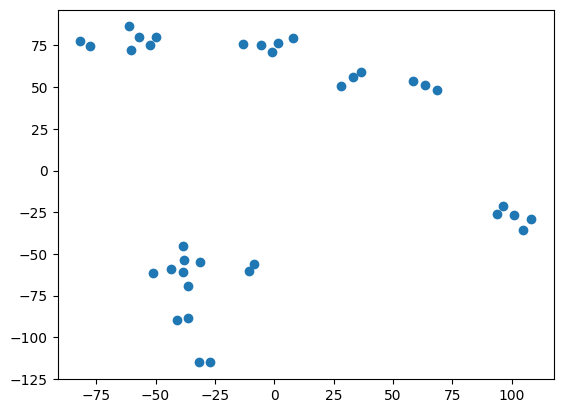

In [14]:
from sklearn.manifold import TSNE

sum_out = deets[0][7][3, 4, :, :]
x_embed = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(sum_out)
plt.scatter(*zip(*x_embed))

In [ ]:
tim = 12

variance = deets[0][7][1]
variance = np.where(adj > 0, variance, np.ones_like(variance)*float('-inf'))
plt.figure(figsize=(30, 20))
plt.imshow(variance, cmap="coolwarm", interpolation="nearest", vmax=0.05)
plt.colorbar(label="Correlation")

plt.title("Invars")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(variance.shape[0]))
plt.yticks(range(variance.shape[1]))
plt.show()

In [23]:
adj

array([[0.        , 0.8685382 , 0.58219194, ..., 0.        , 0.        ,
        0.        ],
       [0.8685382 , 0.        , 0.86604404, ..., 0.        , 0.        ,
        0.        ],
       [0.58219194, 0.86604404, 0.        , ..., 0.        , 0.        ,
        0.10112431],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.3707812 ],
       [0.        , 0.        , 0.10112431, ..., 0.        , 0.3707812 ,
        0.        ]], dtype=float32)

In [14]:
deets

['../logs/unkrig/air/2025-04-24/17-52-59',
 (array([[[[117.42374 ],
           [ 75.81237 ],
           [ 75.71008 ],
           ...,
           [ 88.815475],
           [ 80.96251 ],
           [ 75.250565]],
  
          [[ 67.11372 ],
           [ 70.09638 ],
           [ 70.21912 ],
           ...,
           [ 72.10552 ],
           [ 76.63676 ],
           [ 73.865036]],
  
          [[ 64.27284 ],
           [ 68.78137 ],
           [ 68.914734],
           ...,
           [ 60.72359 ],
           [ 73.81756 ],
           [ 72.73518 ]],
  
          ...,
  
          [[ 44.988182],
           [ 66.61342 ],
           [ 66.60392 ],
           ...,
           [ 45.59074 ],
           [ 73.25827 ],
           [ 71.64661 ]],
  
          [[ 35.879314],
           [ 66.6883  ],
           [ 66.7612  ],
           ...,
           [ 35.168102],
           [ 73.80413 ],
           [ 71.45971 ]],
  
          [[ 37.822258],
           [ 67.04361 ],
           [ 67.1021  ],
           ...

(6849, 24, 207, 1)
(6849, 24, 207, 1)


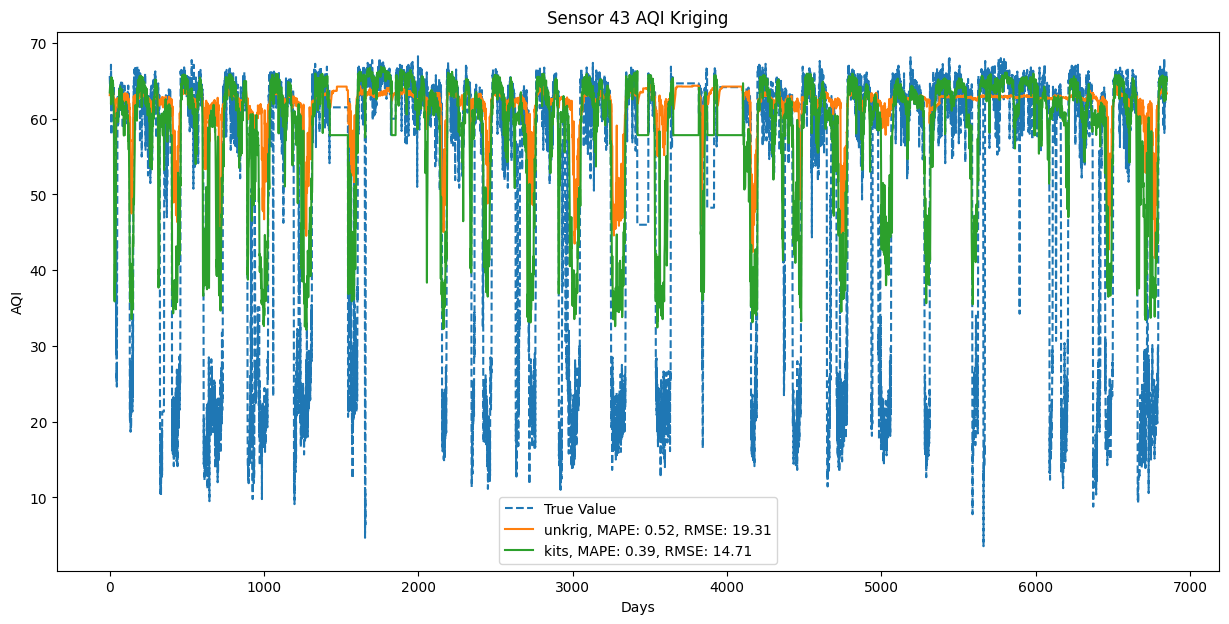

(6849, 24, 207, 1)
(6849, 24, 207, 1)


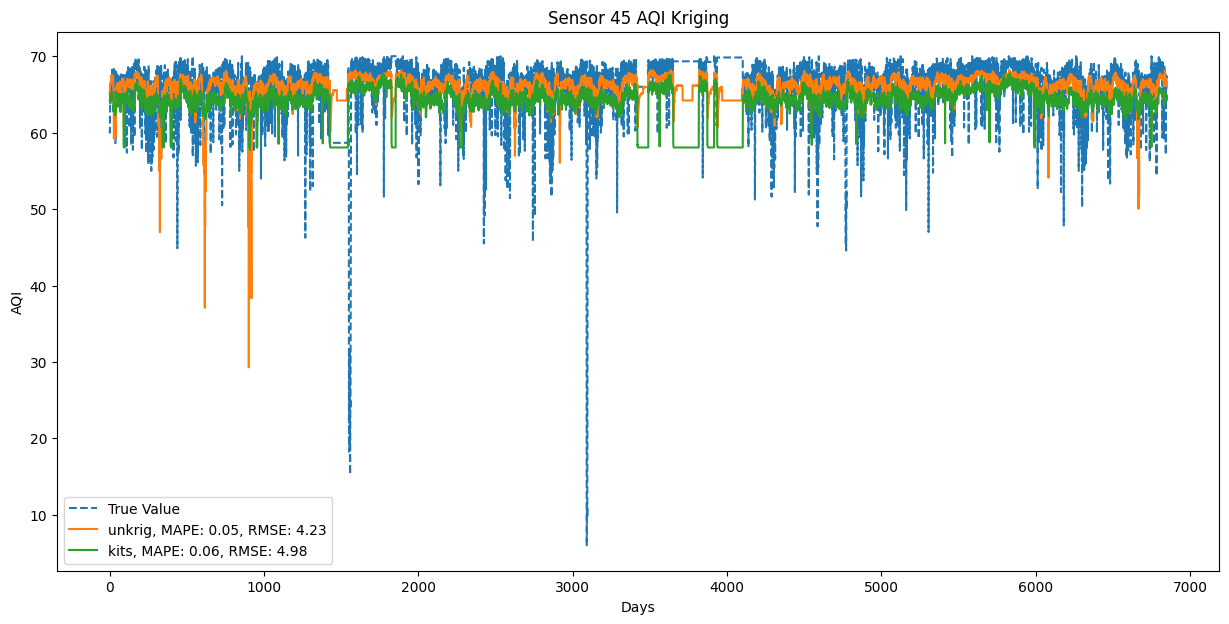

(6849, 24, 207, 1)
(6849, 24, 207, 1)


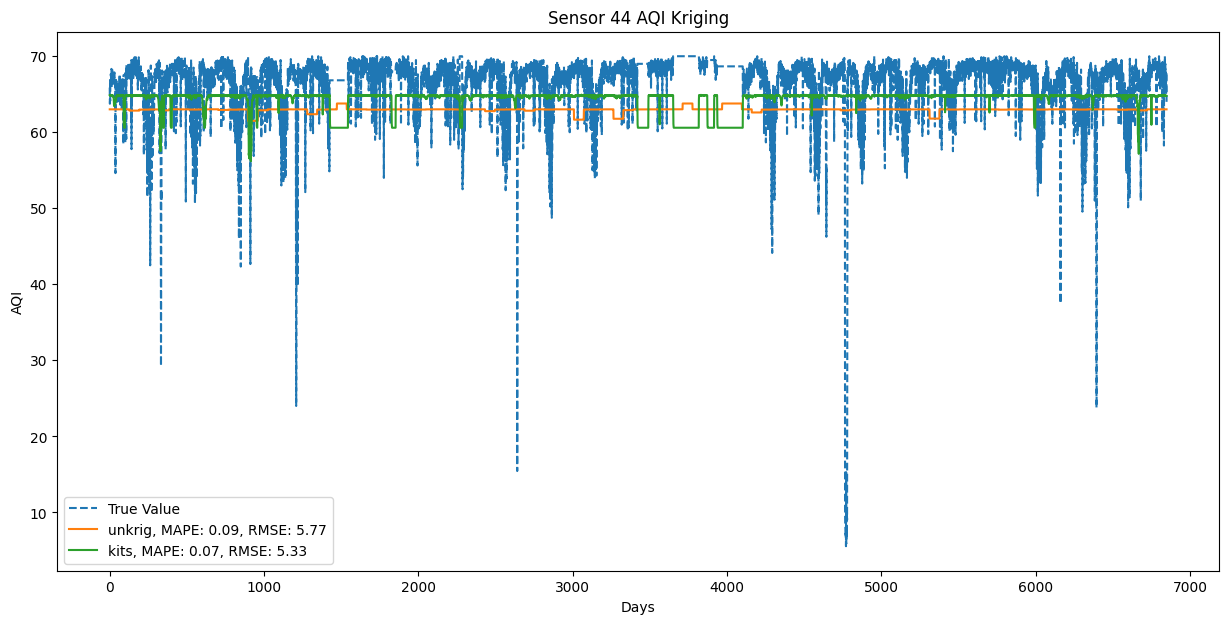

(6849, 24, 207, 1)
(6849, 24, 207, 1)


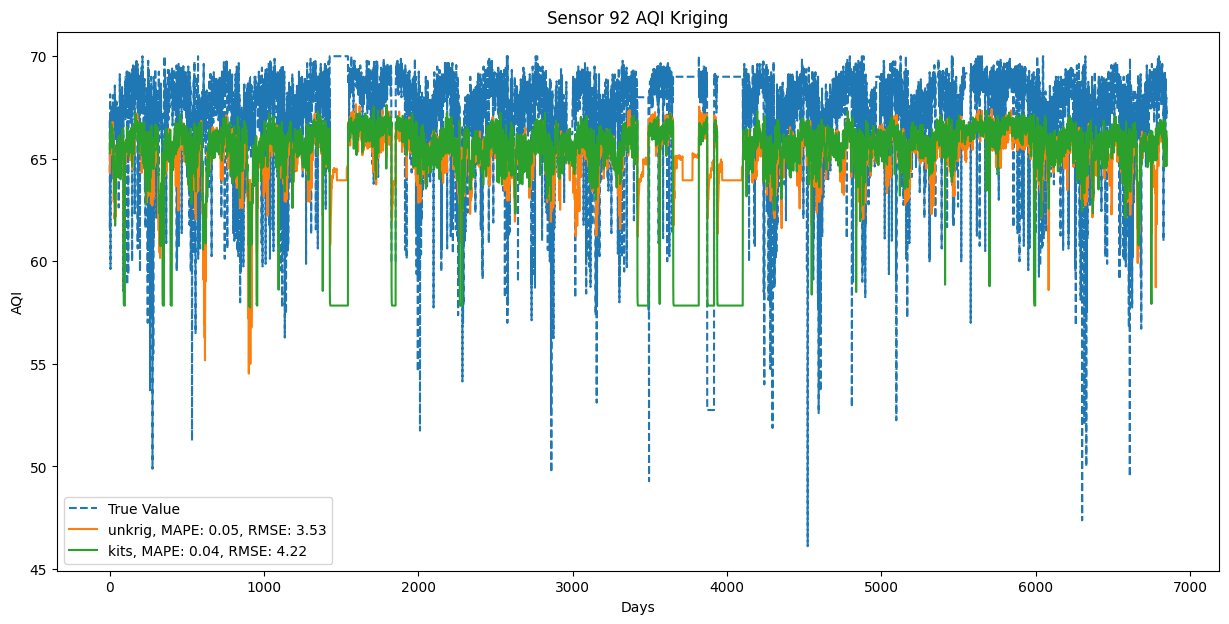

(6849, 24, 207, 1)
(6849, 24, 207, 1)


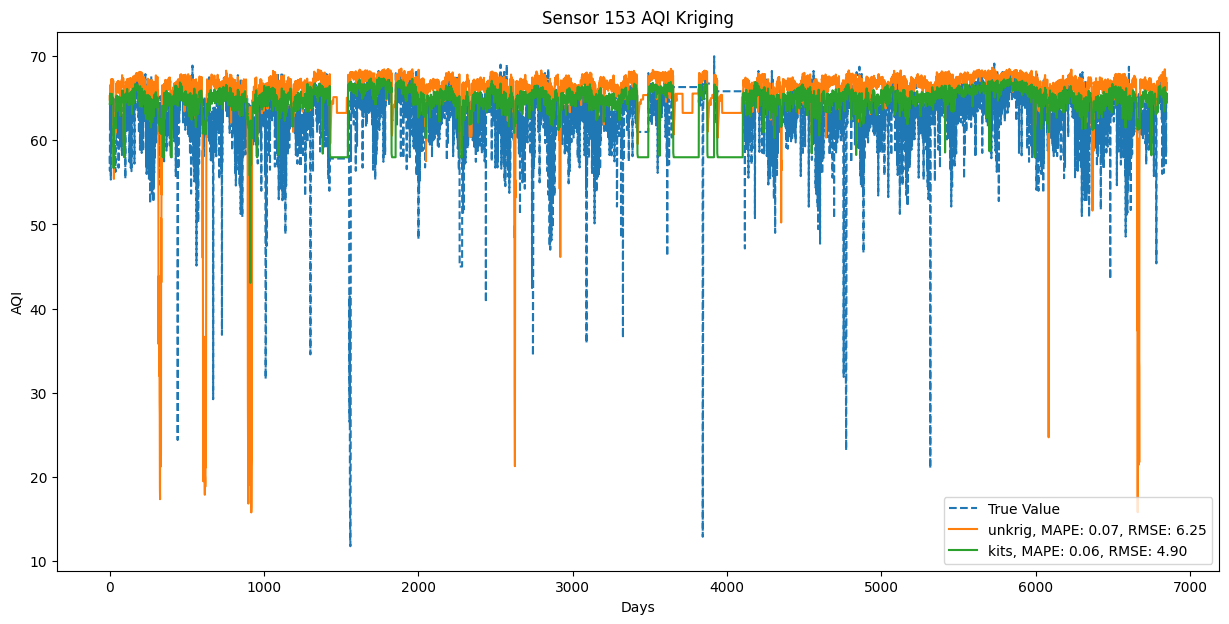

(6849, 24, 207, 1)
(6849, 24, 207, 1)


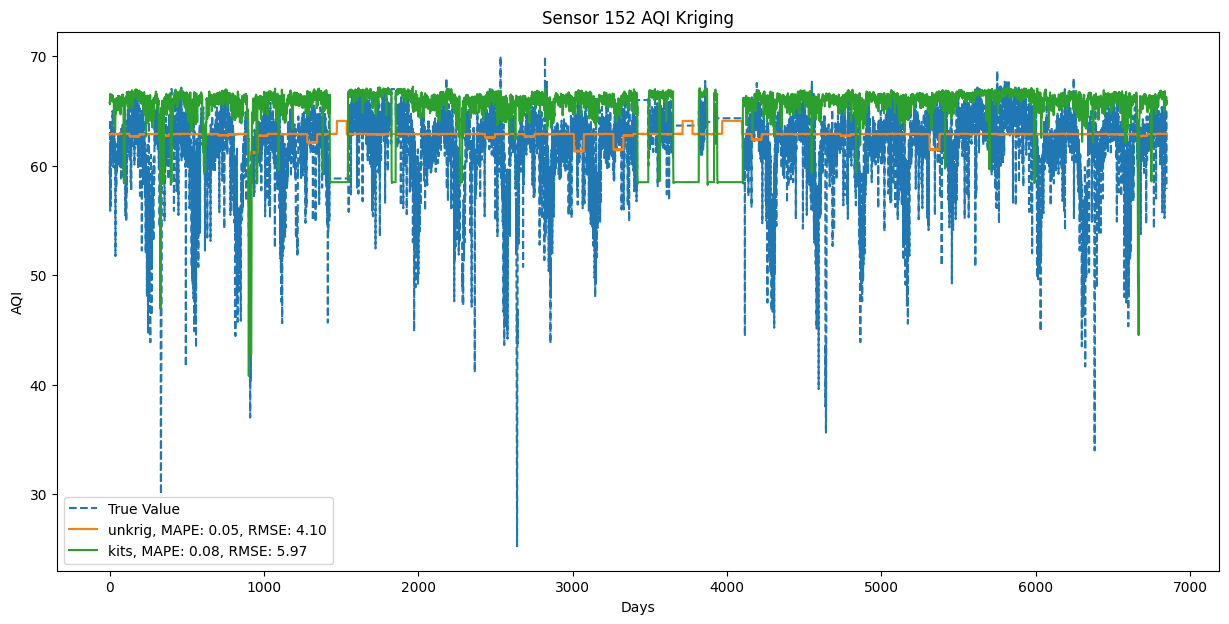

(6849, 24, 207, 1)
(6849, 24, 207, 1)


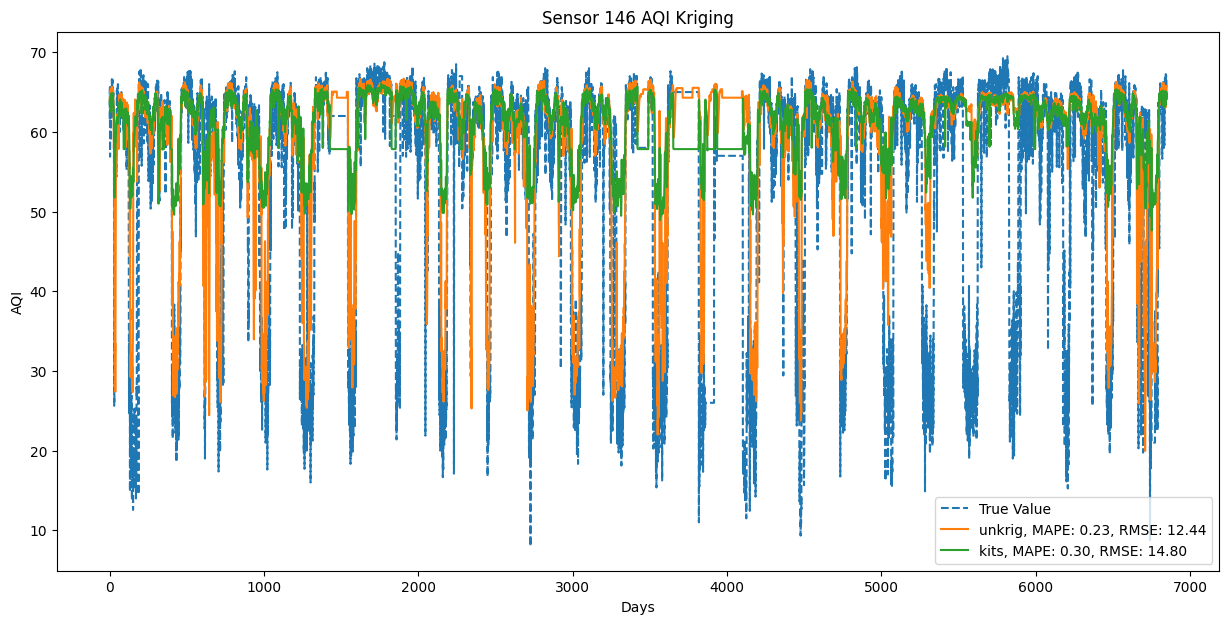

(6849, 24, 207, 1)
(6849, 24, 207, 1)


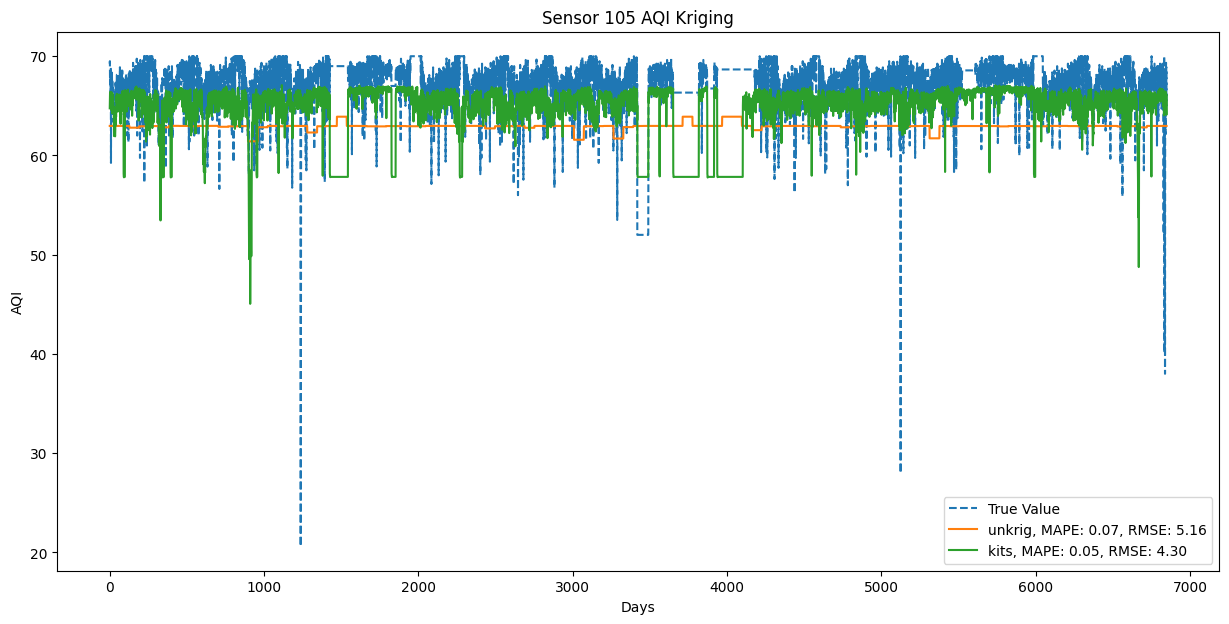

(6849, 24, 207, 1)
(6849, 24, 207, 1)


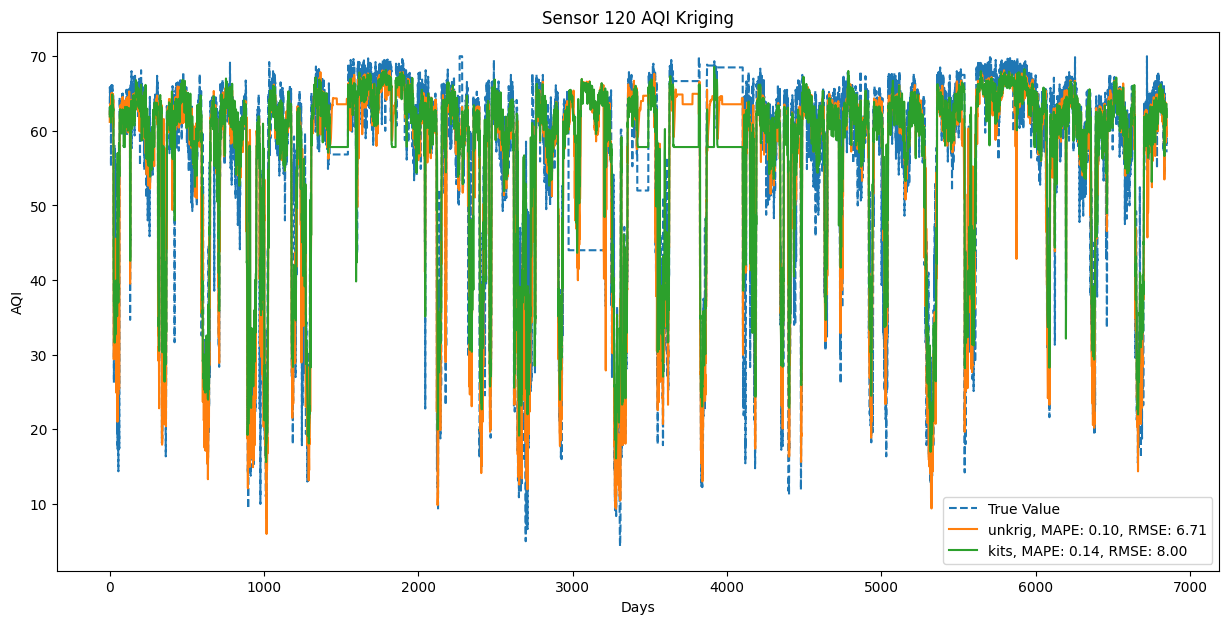

(6849, 24, 207, 1)
(6849, 24, 207, 1)


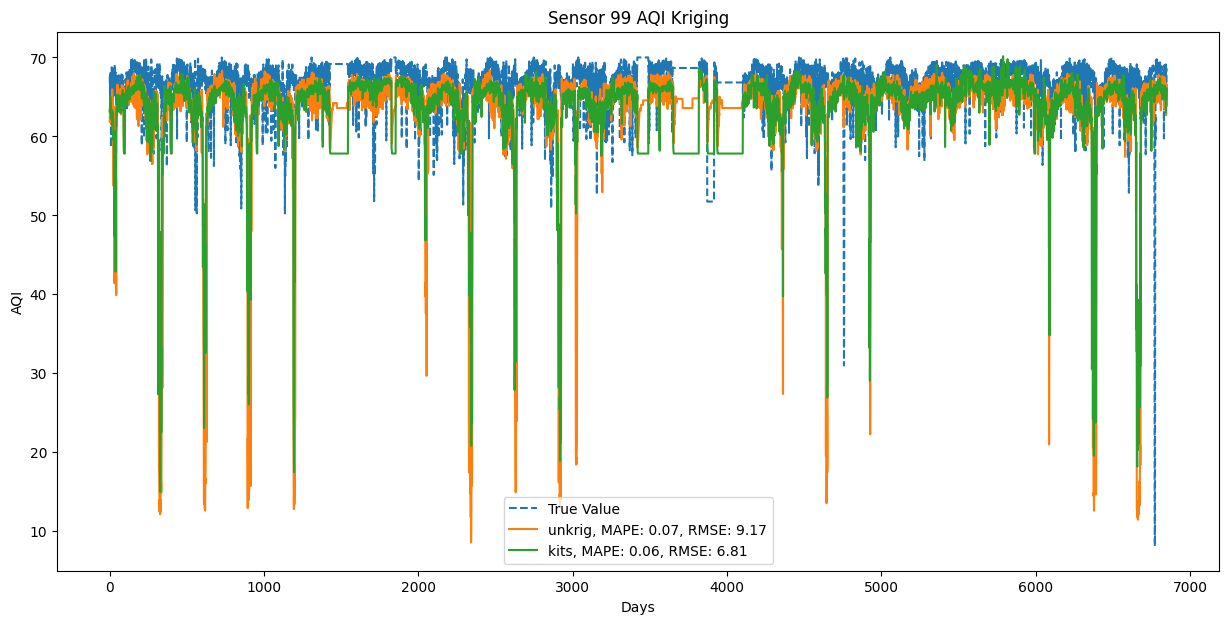

(6849, 24, 207, 1)
(6849, 24, 207, 1)


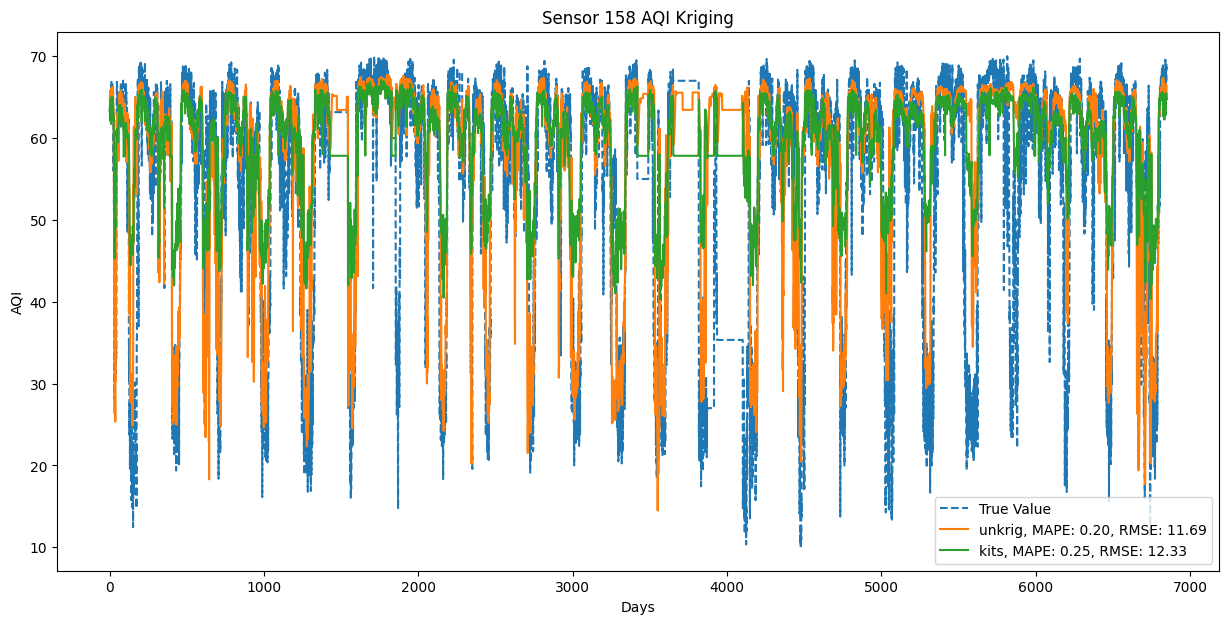

(6849, 24, 207, 1)
(6849, 24, 207, 1)


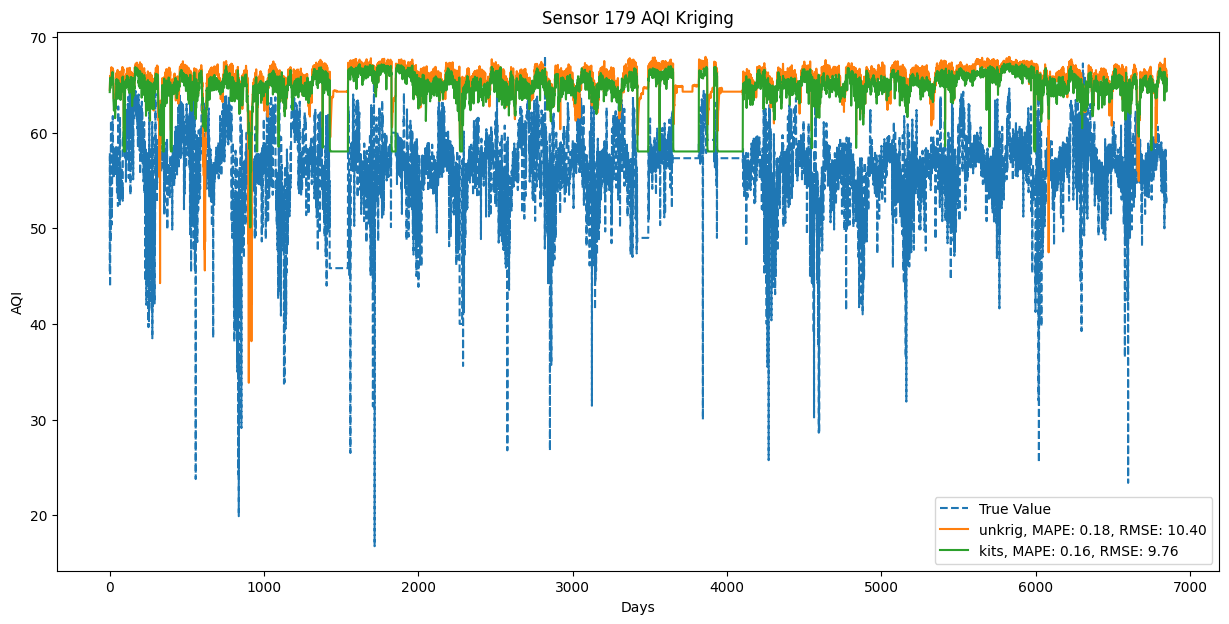

(6849, 24, 207, 1)
(6849, 24, 207, 1)


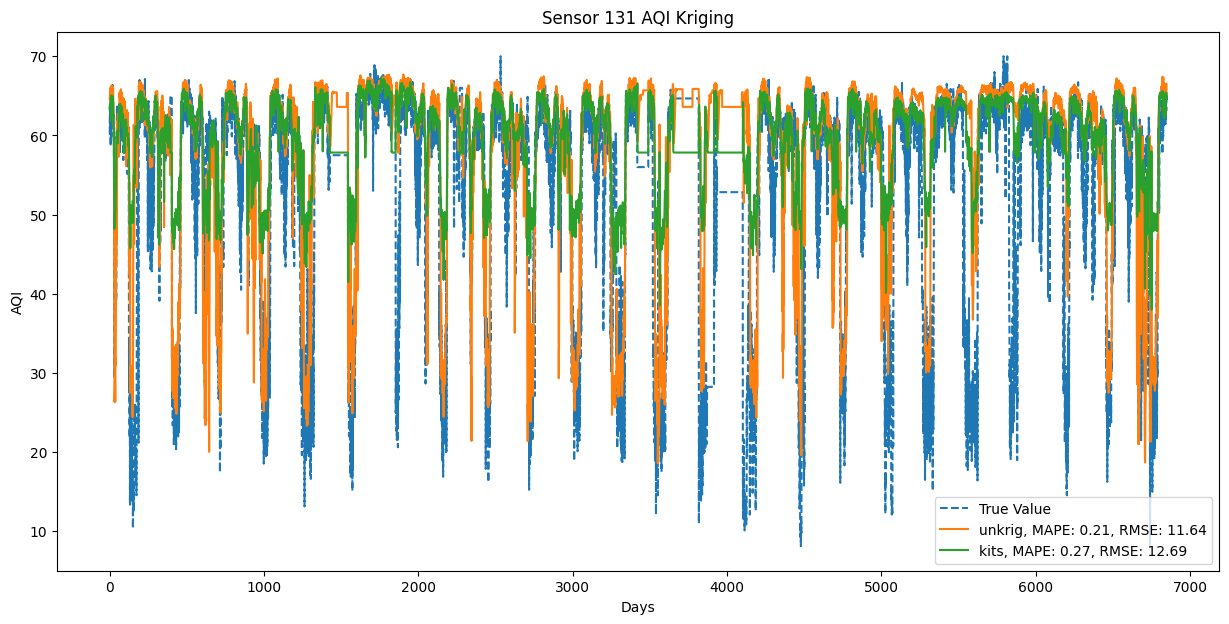

(6849, 24, 207, 1)
(6849, 24, 207, 1)


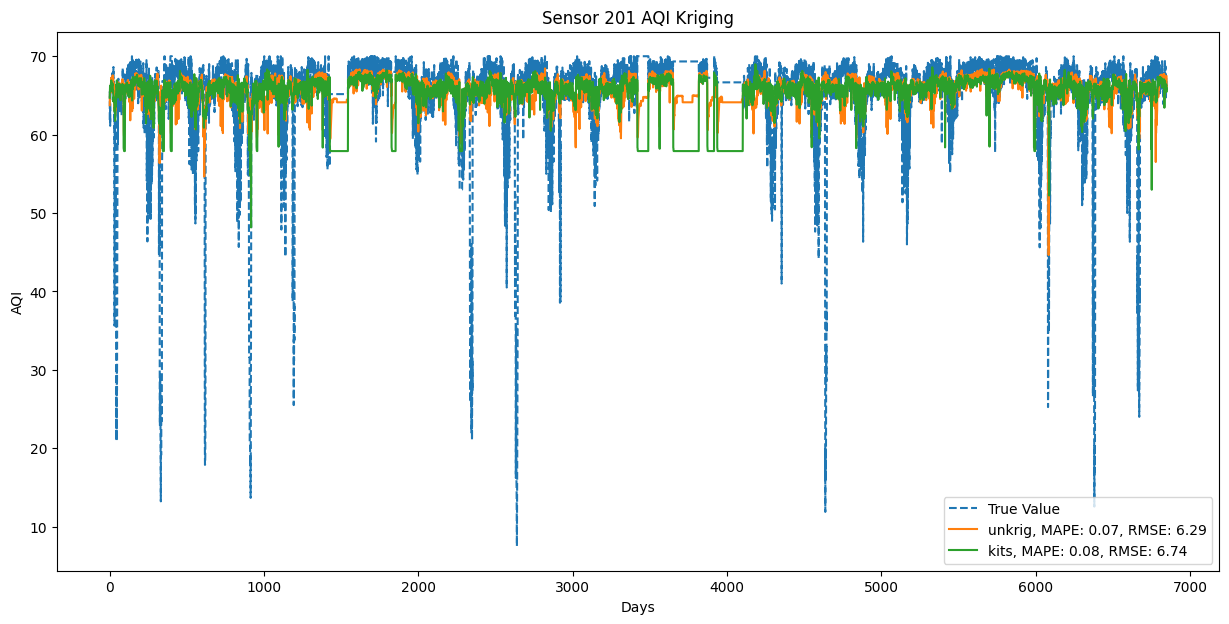

(6849, 24, 207, 1)
(6849, 24, 207, 1)


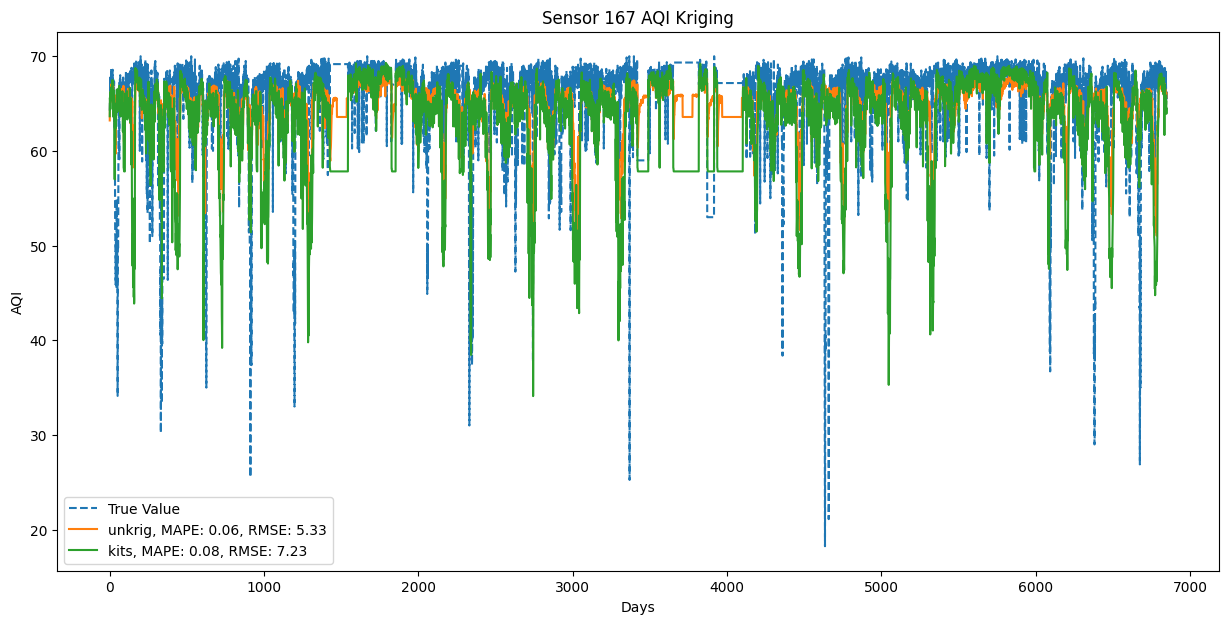

(6849, 24, 207, 1)
(6849, 24, 207, 1)


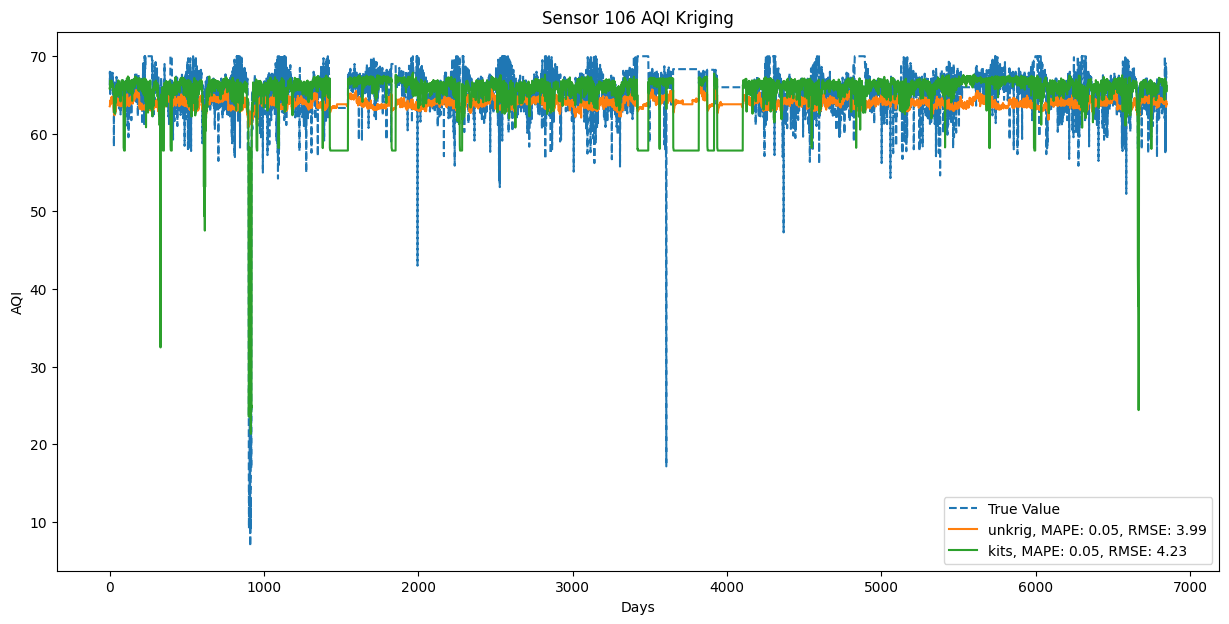

(6849, 24, 207, 1)
(6849, 24, 207, 1)


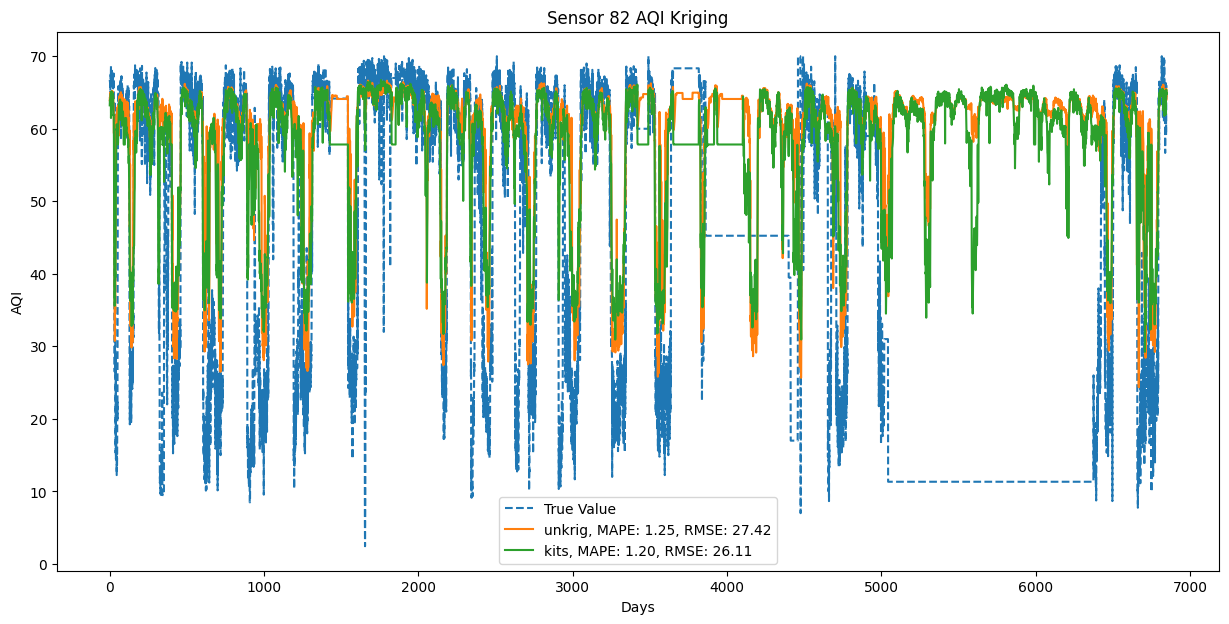

(6849, 24, 207, 1)
(6849, 24, 207, 1)


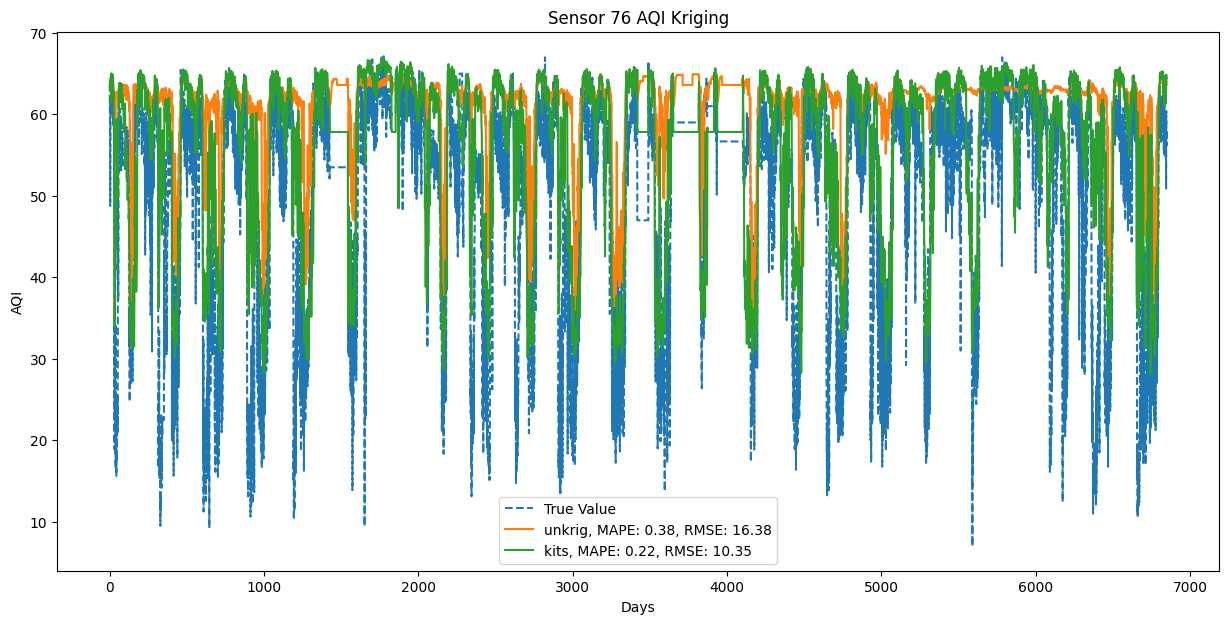

(6849, 24, 207, 1)
(6849, 24, 207, 1)


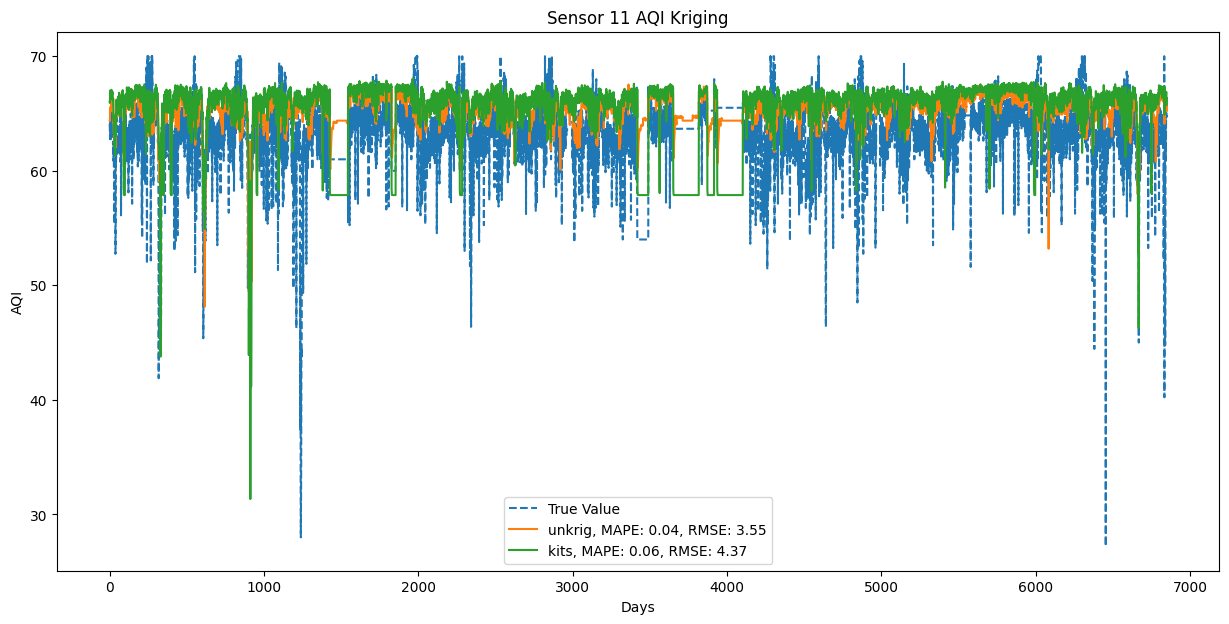

(6849, 24, 207, 1)
(6849, 24, 207, 1)


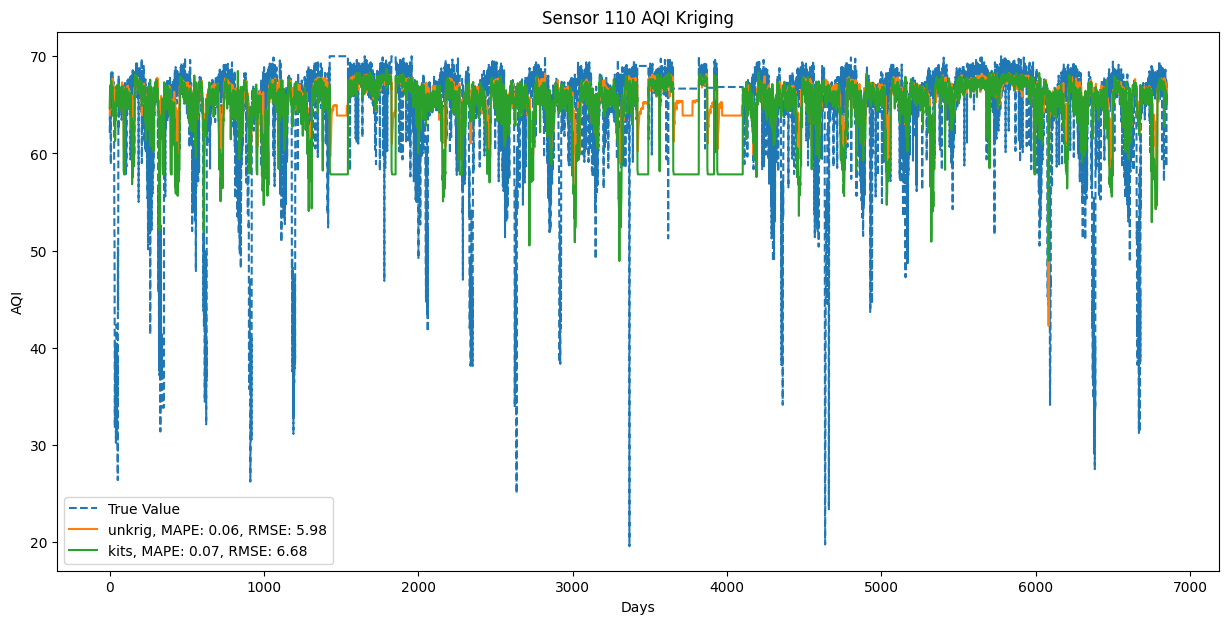

(6849, 24, 207, 1)
(6849, 24, 207, 1)


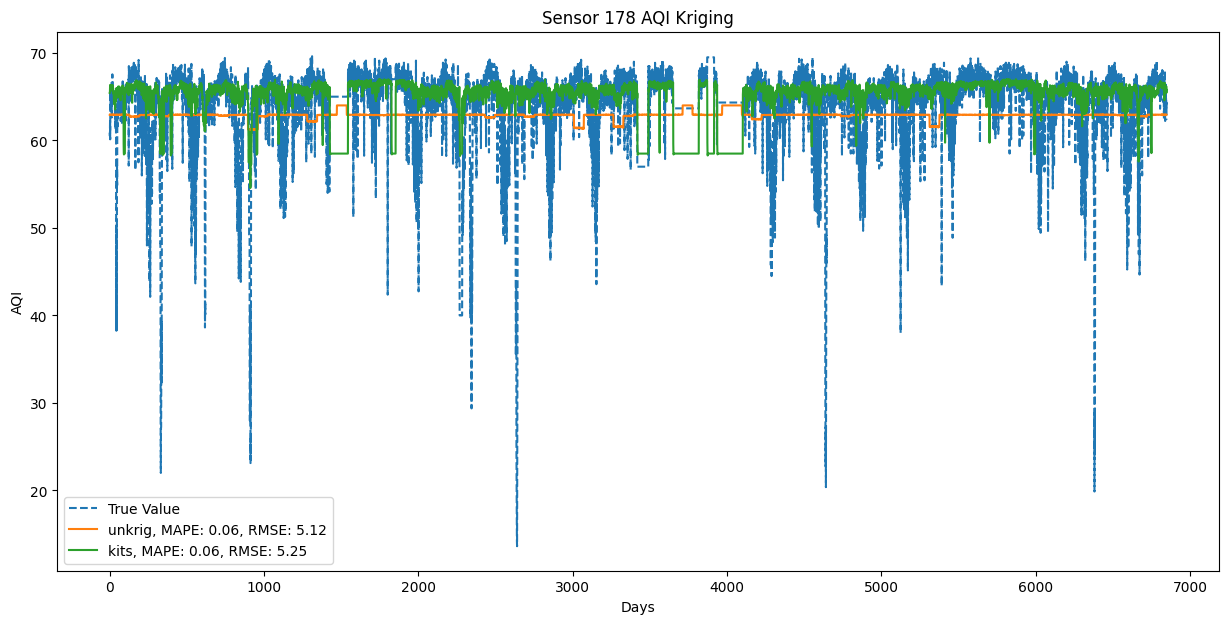

(6849, 24, 207, 1)
(6849, 24, 207, 1)


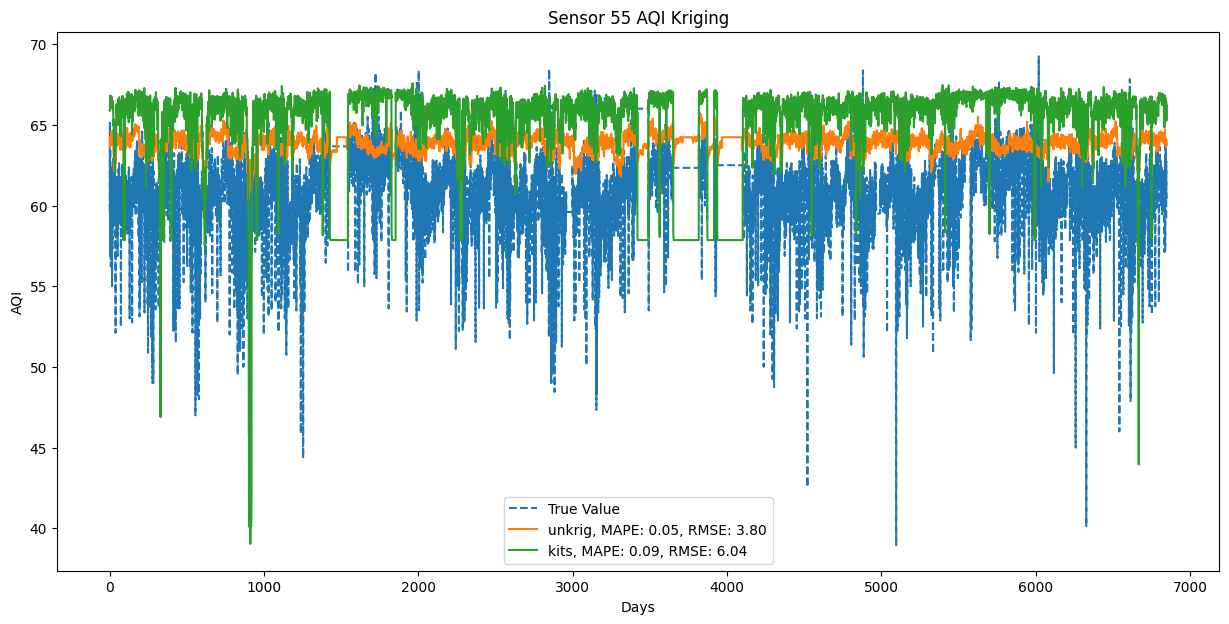

(6849, 24, 207, 1)
(6849, 24, 207, 1)


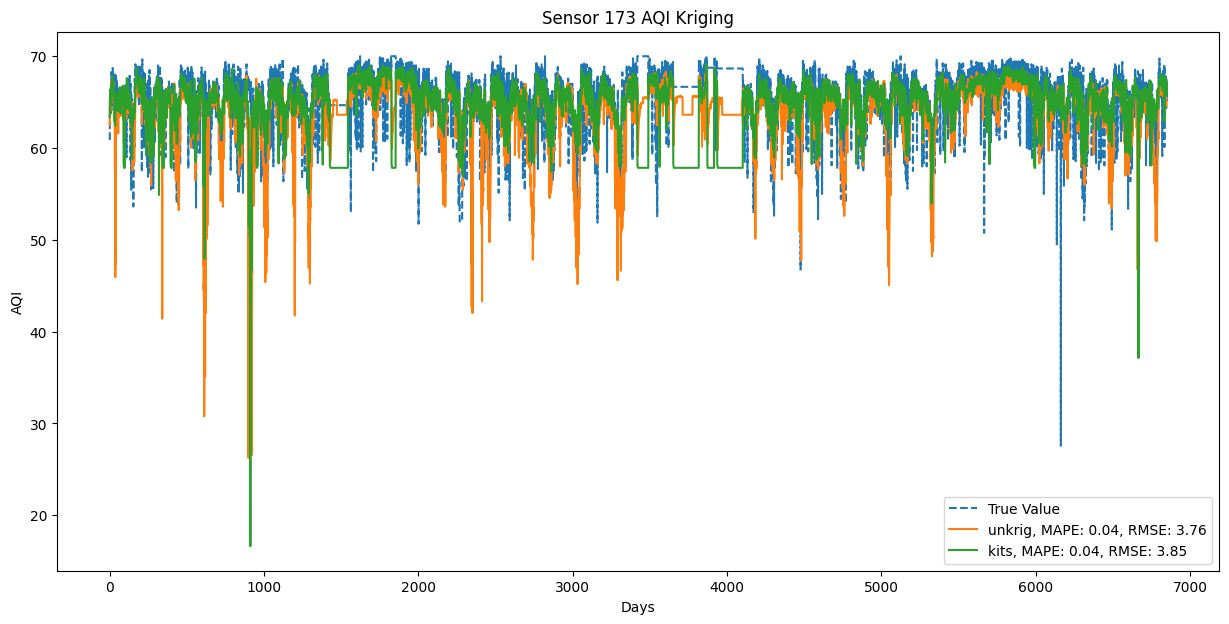

(6849, 24, 207, 1)
(6849, 24, 207, 1)


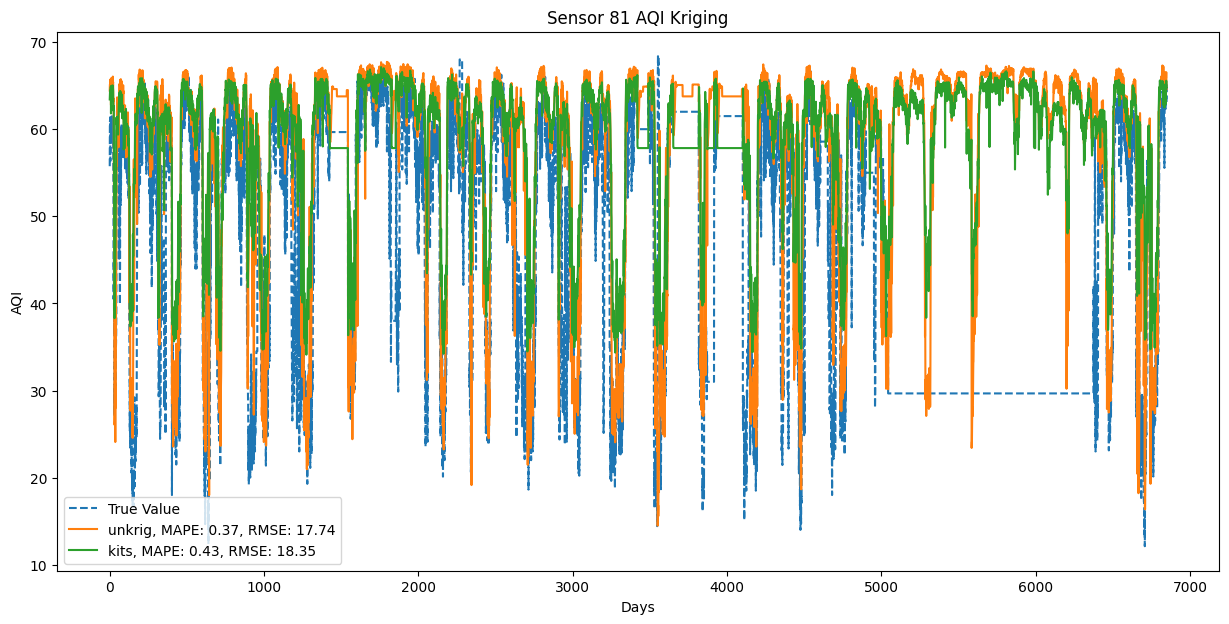

(6849, 24, 207, 1)
(6849, 24, 207, 1)


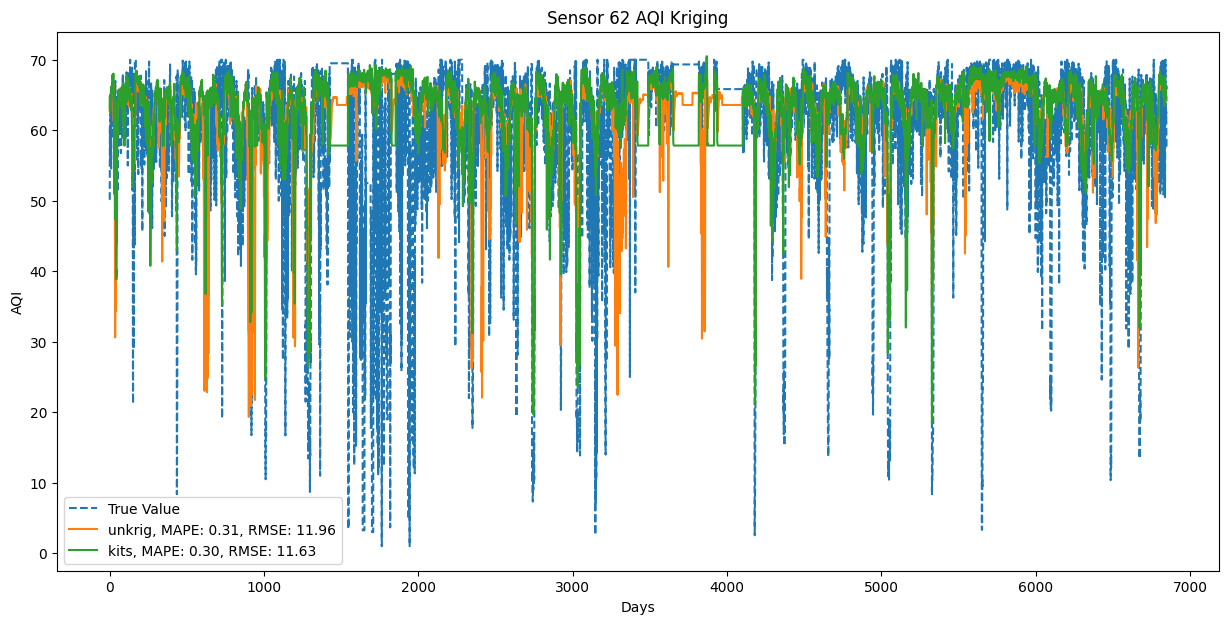

(6849, 24, 207, 1)
(6849, 24, 207, 1)


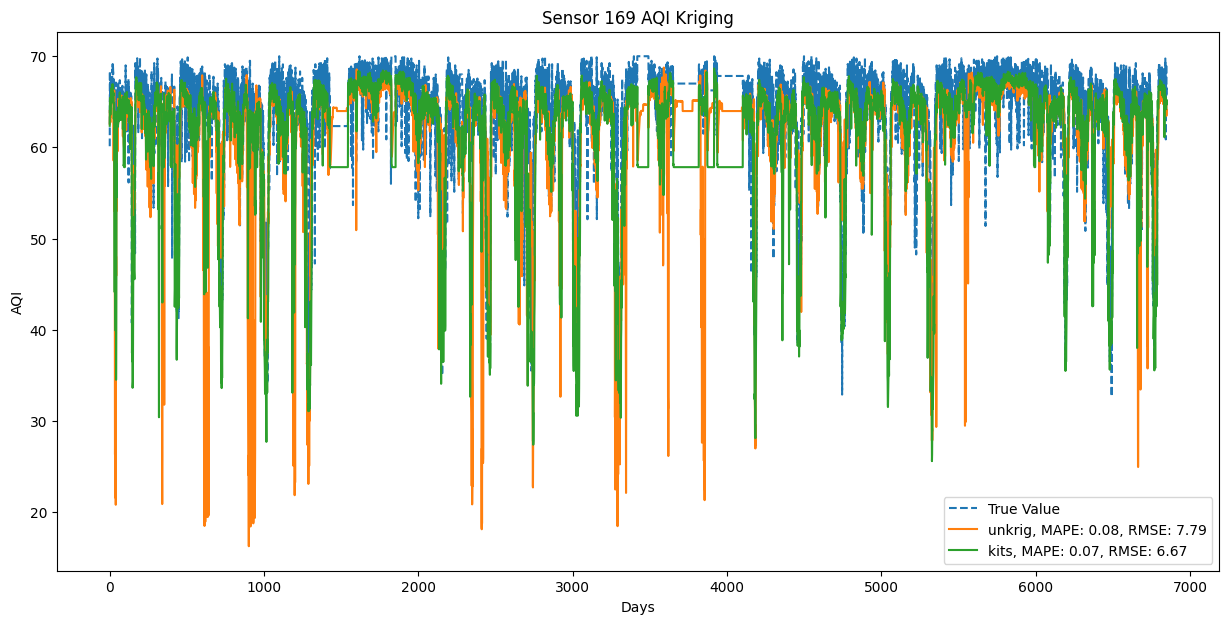

In [6]:
titles = ['unkrig', 'kits']
styles = ['-']
ranges = [0, -1]

sensors = [26, 126, 200, 21, 121, 18, 189, 50, 35, 182, 181, 180, 186, 59, 150, 8, 34, 185, 46, 66, 203, 149, 87, 100, 14, 86, 104, 112, 89, 151, 148, 172, 88, 202, 9, 51, 84, 204, 130, 41, 197, 77, 194, 43, 45, 44, 92, 153, 152, 146, 105, 120, 99, 158, 179, 131, 201, 167, 106, 82, 76, 11, 110, 178, 55, 173, 81, 62, 169]
sensors = [43, 45, 44, 92, 153, 152, 146, 105, 120, 99, 158, 179, 131, 201, 167, 106, 82, 76, 11, 110, 178, 55, 173, 81, 62, 169]
# sensors = [5, 10, 31, 40, 71, 73, 83, 117, 122, 156, 164, 176]
# sensors = range(1, 12)

# deets = [[y_hat, y_true, mask, res, dm, dataset]]
mape_deet = [0, 0]
rmse_deet = [0, 0]

for sensor in sensors:
    plt.figure(figsize=(15,7))
    y_true = deets[1][1]

    # y_true = np.where(deets[0][2] == 1, y_true, 400)

    plt.plot(y_true[ranges[0]:ranges[1], -1, sensor, :], '--', label='True Value')
    # plt.plot(deets[1][0][ranges[0]:ranges[1], 0, 33, :], '--', label='KITS')
    for ind, deet in enumerate(deets):
        # deet = deets[0]
        y_hat = deet[0]
        print(y_hat.shape)
        test_mape=numpy_metrics.mape(y_hat[ranges[0]:ranges[1], :, sensor, :], 
                                    y_true[ranges[0]:ranges[1], :, sensor, :])
        test_rmse=numpy_metrics.rmse(y_hat[ranges[0]:ranges[1], :, sensor, :], 
                                    y_true[ranges[0]:ranges[1], :, sensor, :])

    # if test_mre > 20:
        plt.plot(y_hat[ranges[0]:ranges[1], -1, sensor, :], label=f'{titles[ind]}, MAPE: {test_mape:.2f}, RMSE: {test_rmse:.2f}')
        mape_deet[ind] += test_mape
        rmse_deet[ind] += test_rmse
        # plt.plot(deet[1][ranges[0]:ranges[1], 0, 4, :], label=f'True Value')

    # plt.ylim((0, 100))
    plt.xlabel('Days')
    plt.ylabel('AQI')
    plt.legend()
    plt.title(f'Sensor {sensor} AQI Kriging')
    plt.show()

In [50]:
deets[1][1], deets[1][0]

In [ ]:
(deets[0][5].dataframe().values.T).shape

In [ ]:
adj

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.7174379, ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.7174379, 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [ ]:
nx.google_matrix(nx_g3)

array([[0.00072464, 0.00072464, 0.00072464, ..., 0.00072464, 0.00072464,
        0.00072464],
       [0.00072464, 0.00072464, 0.09043099, ..., 0.00072464, 0.00072464,
        0.00072464],
       [0.00072464, 0.09994487, 0.00072464, ..., 0.00072464, 0.00072464,
        0.00072464],
       ...,
       [0.00072464, 0.00072464, 0.00072464, ..., 0.00072464, 0.00072464,
        0.00072464],
       [0.00072464, 0.00072464, 0.00072464, ..., 0.00072464, 0.00072464,
        0.00072464],
       [0.00072464, 0.00072464, 0.00072464, ..., 0.00072464, 0.00072464,
        0.00072464]])

In [87]:
whut = torch.tensor([5., 5., 5., 5., float('-inf')])
whut1 = torch.tensor([2., 4., 5., 6., float('inf')])
torch.nn.functional.softmax(whut), torch.nn.functional.softmax(-whut1)

(tensor([0.2500, 0.2500, 0.2500, 0.2500, 0.0000]),
 tensor([0.8310, 0.1125, 0.0414, 0.0152, 0.0000]))

In [12]:
deets[0][8]

array([[[0.        , 0.91399276, 0.6276465 , ..., 0.        ,
         0.        , 0.        ],
        [0.91201645, 0.        , 0.9095223 , ..., 0.        ,
         0.        , 0.        ],
        [0.6256702 , 0.9095223 , 0.        , ..., 0.        ,
         0.        , 0.14460257],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.48189232],
        [0.        , 0.        , 0.26779097, ..., 0.        ,
         0.53744787, 0.        ]],

       [[0.        , 0.91399276, 0.6276465 , ..., 0.        ,
         0.        , 0.        ],
        [0.91201645, 0.        , 0.9095223 , ..., 0.        ,
         0.        , 0.        ],
        [0.6256702 , 0.9095223 , 0.        , ..., 0.        ,
         0.        , 0.14460257],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

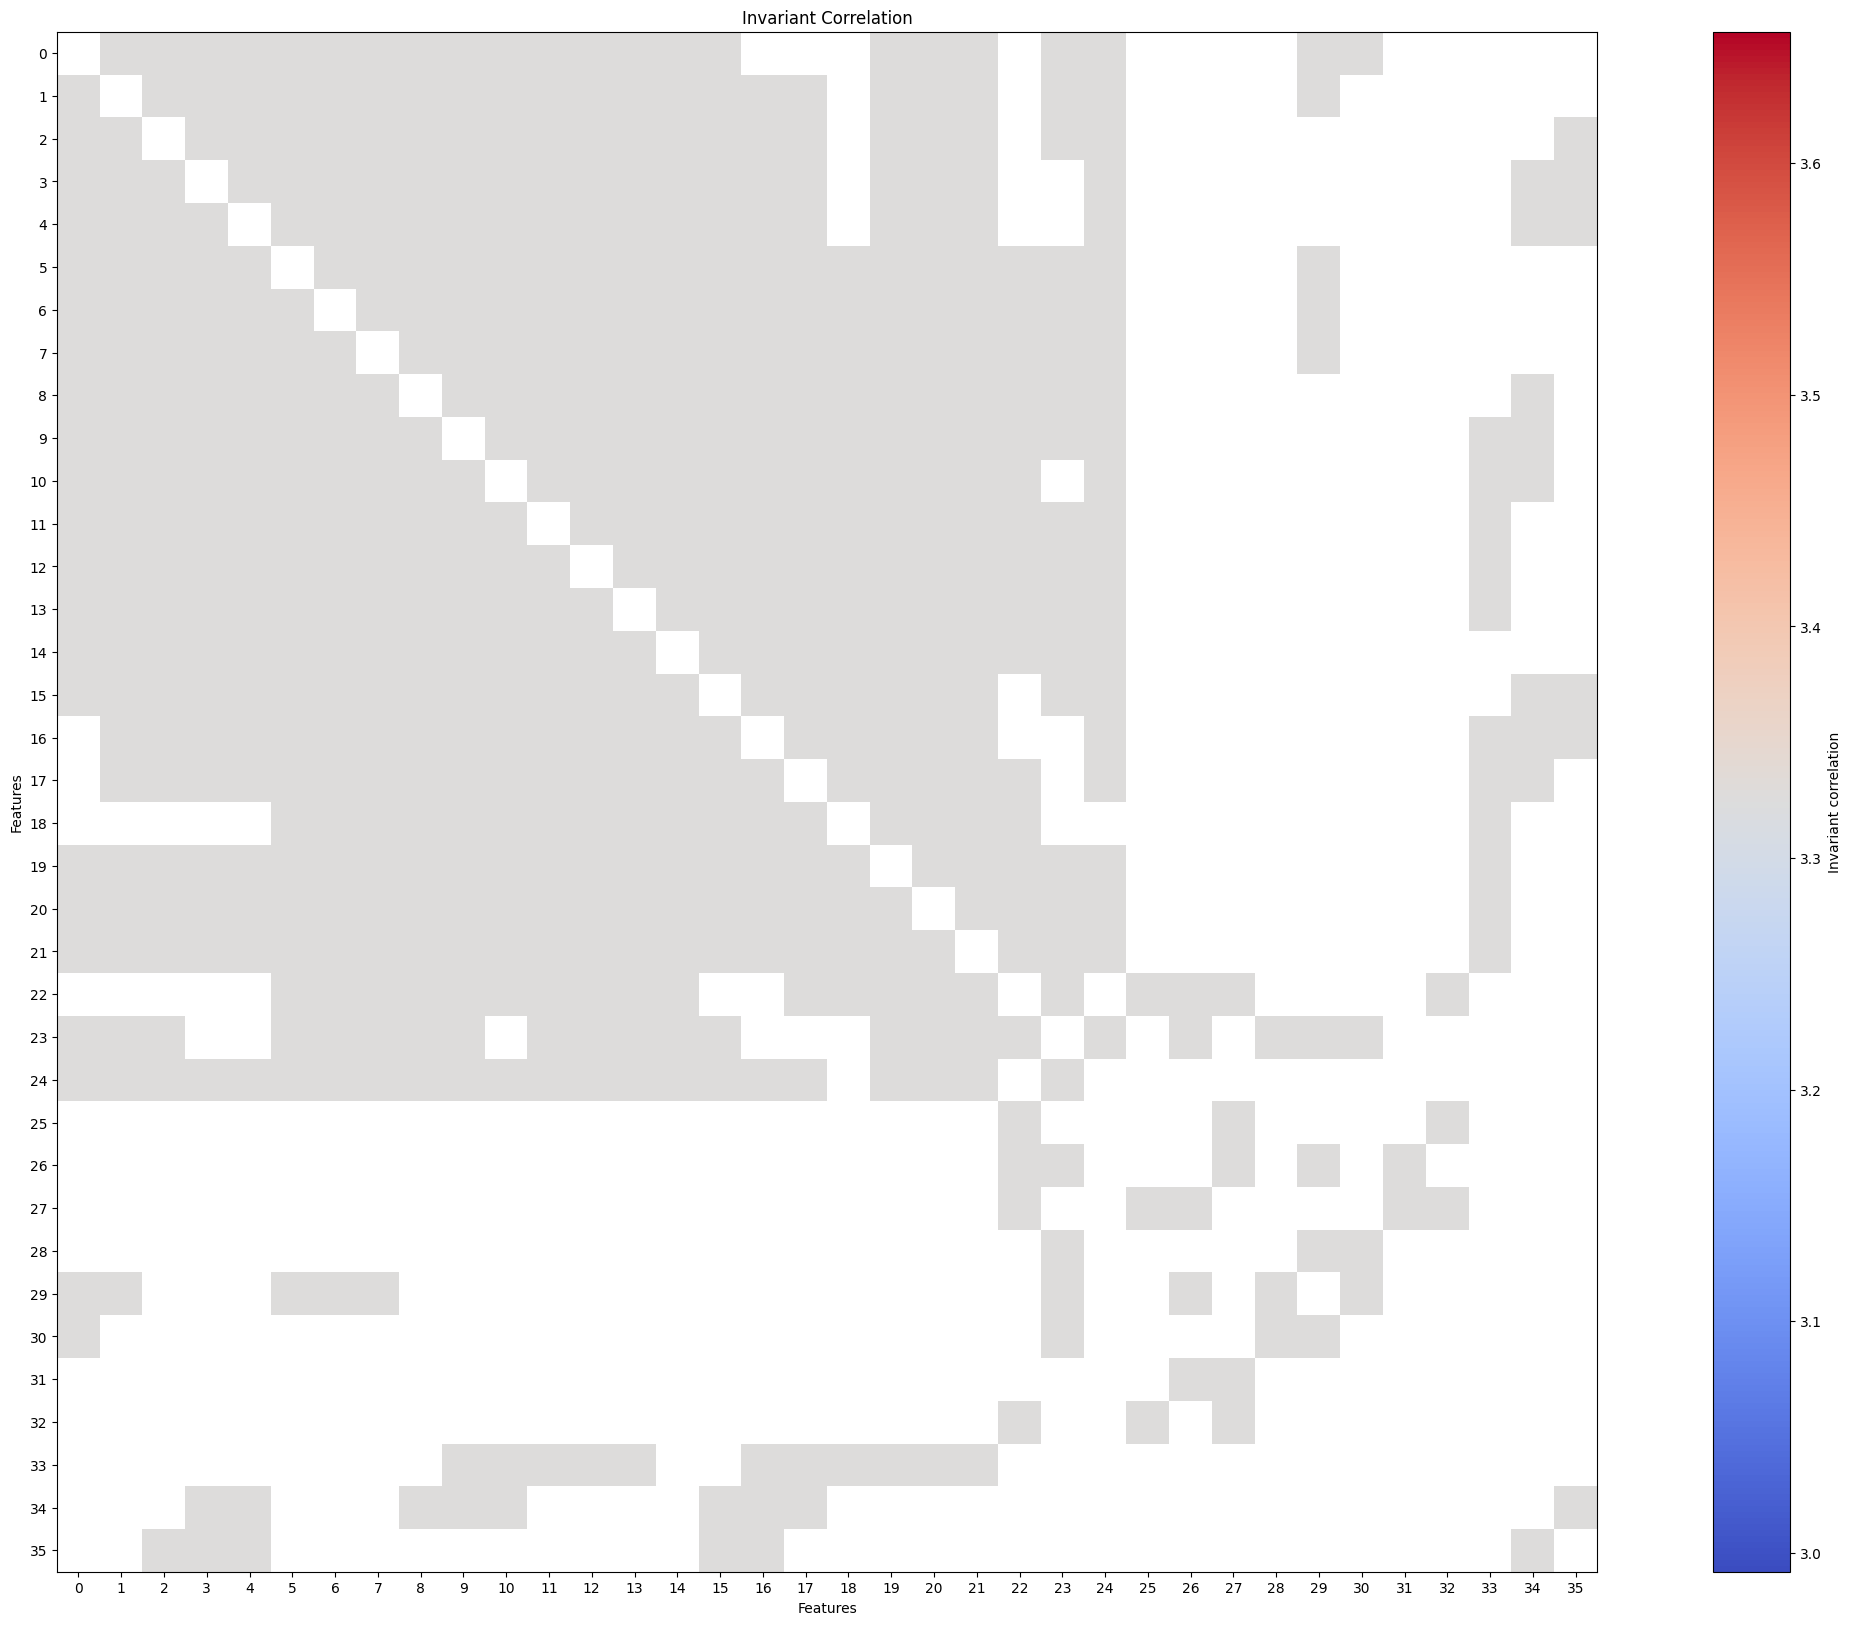

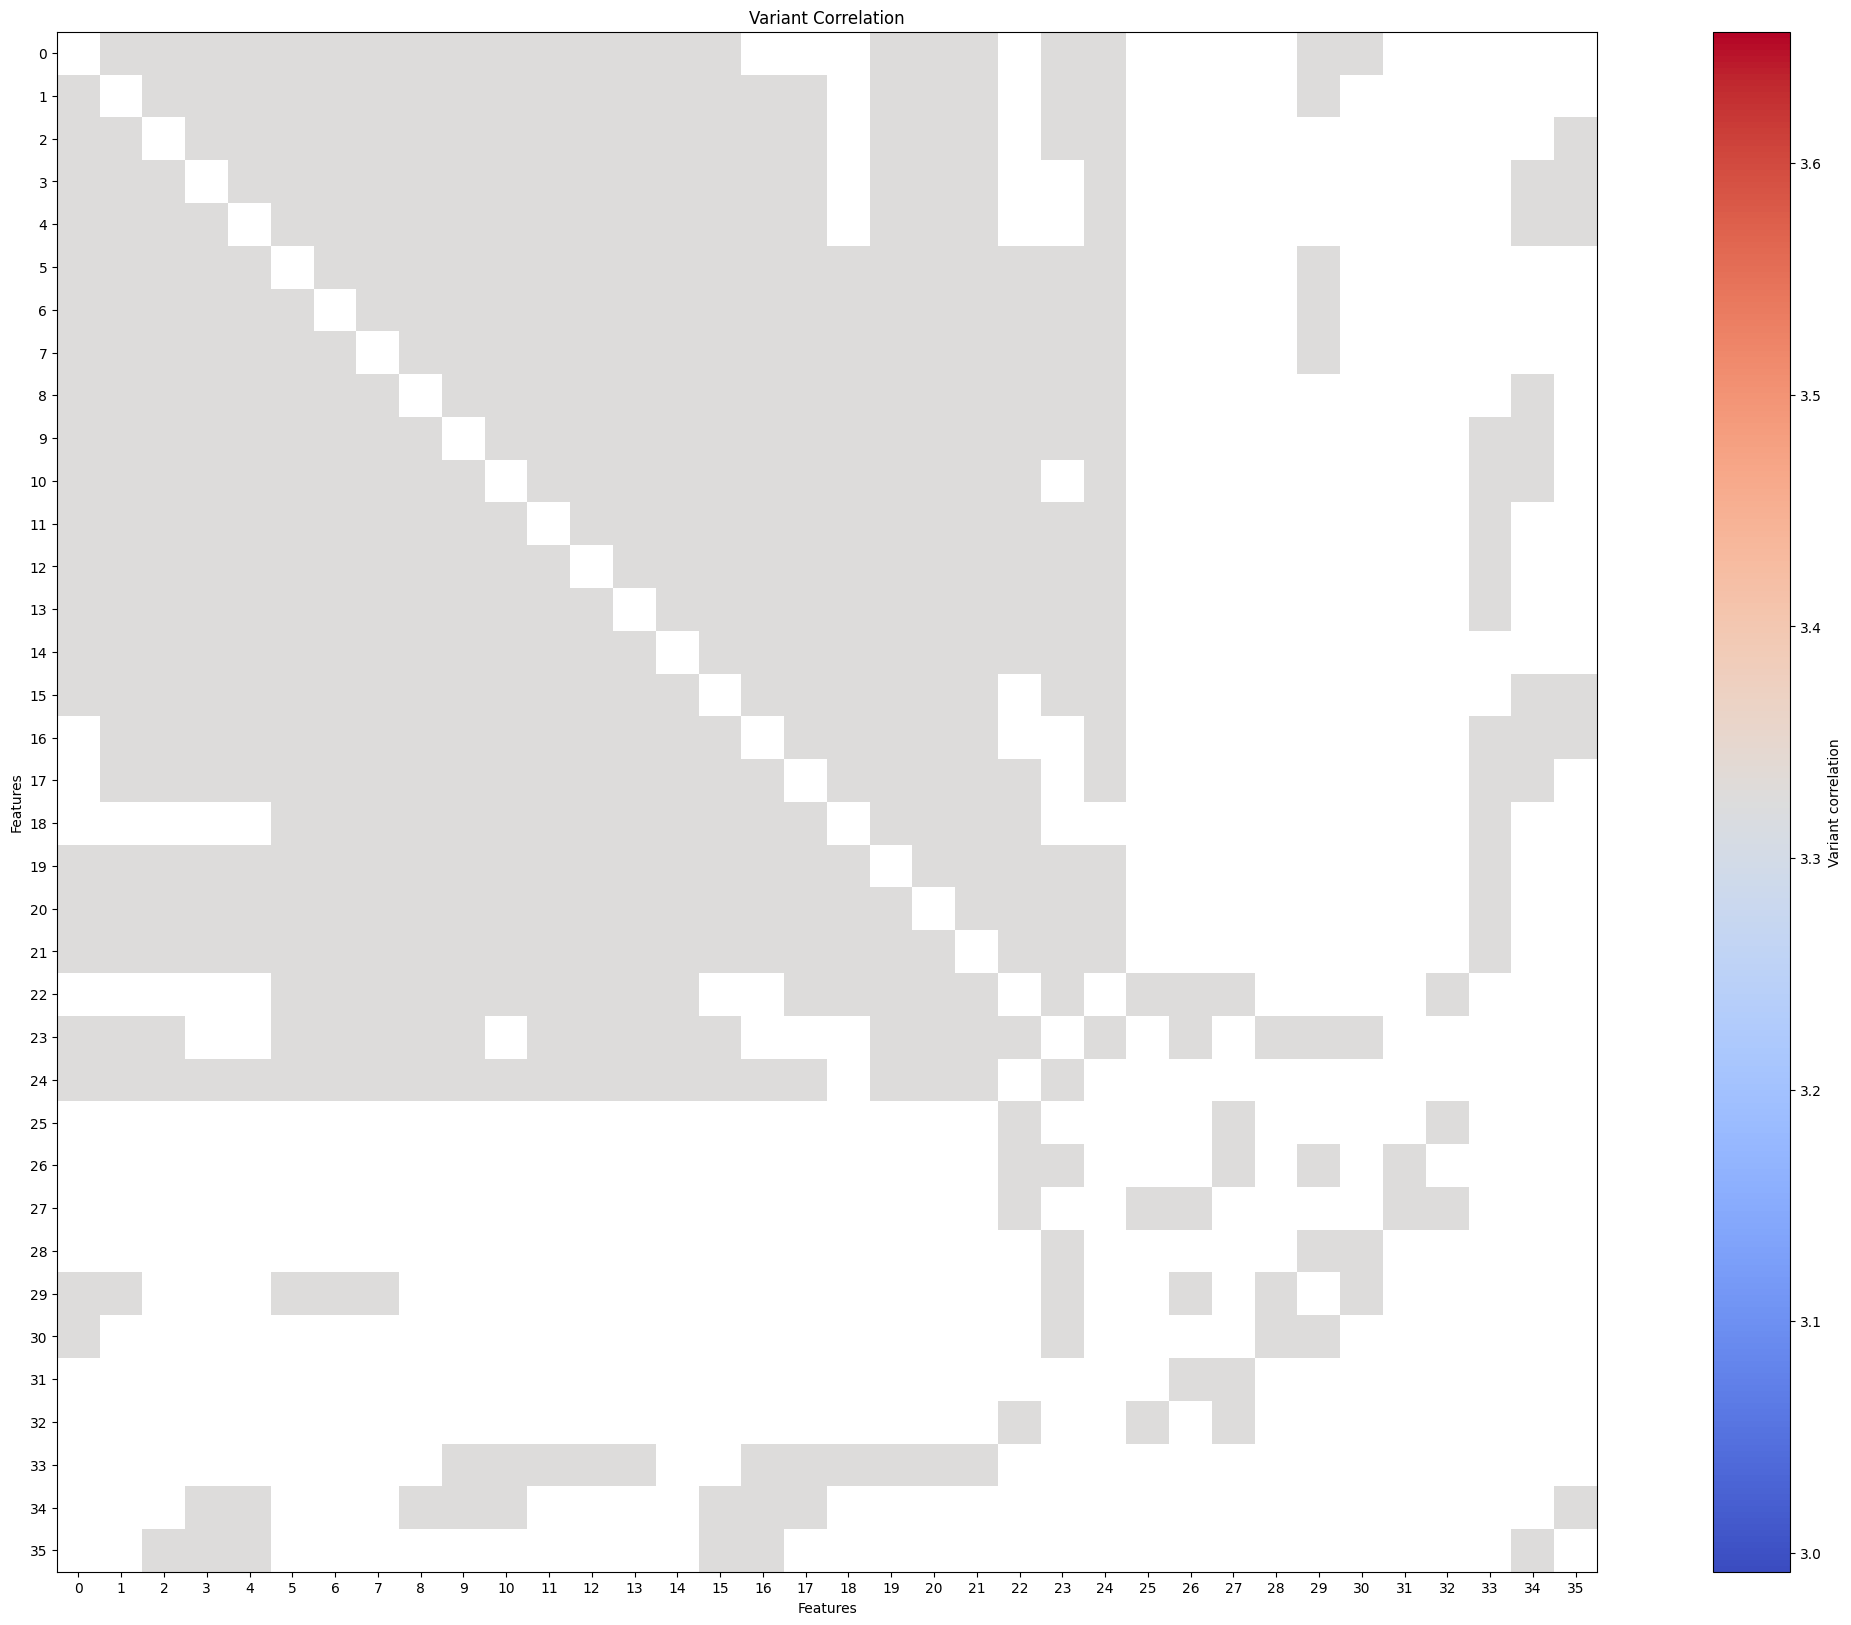

In [8]:
ind = 1
time = 2
embds_inv = deets[0][7][ind, time]
embds_var = deets[0][7][ind, time]

invs = embds_inv@embds_inv.T
vars = embds_var@embds_var.T

invs = np.where(adj > 0, invs, np.ones_like(invs)*(np.nan))
vars = np.where(adj > 0, vars, np.ones_like(vars)*(np.nan))

plt.figure(figsize=(30, 20))
plt.imshow(invs, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Invariant correlation")

plt.title("Invariant Correlation")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(invs.shape[0]))
plt.yticks(range(invs.shape[1]))
plt.show()

plt.figure(figsize=(30, 20))
plt.imshow(vars, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Variant correlation")

# Add text annotations
# for i in range(standardized_cov_matrix.shape[0]):
#     for j in range(standardized_cov_matrix.shape[1]):
#         plt.text(j, i, f"{standardized_cov_matrix[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("Variant Correlation")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(vars.shape[0]))
plt.yticks(range(vars.shape[1]))
plt.show()

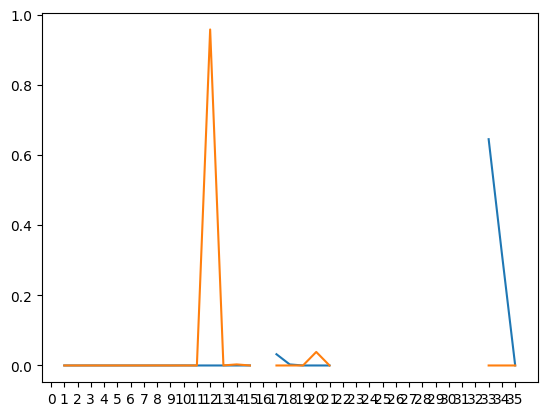

In [18]:
plt.plot(invs[16])
plt.plot(vars[16])
plt.xticks(list(range(0, 36)))
plt.show()

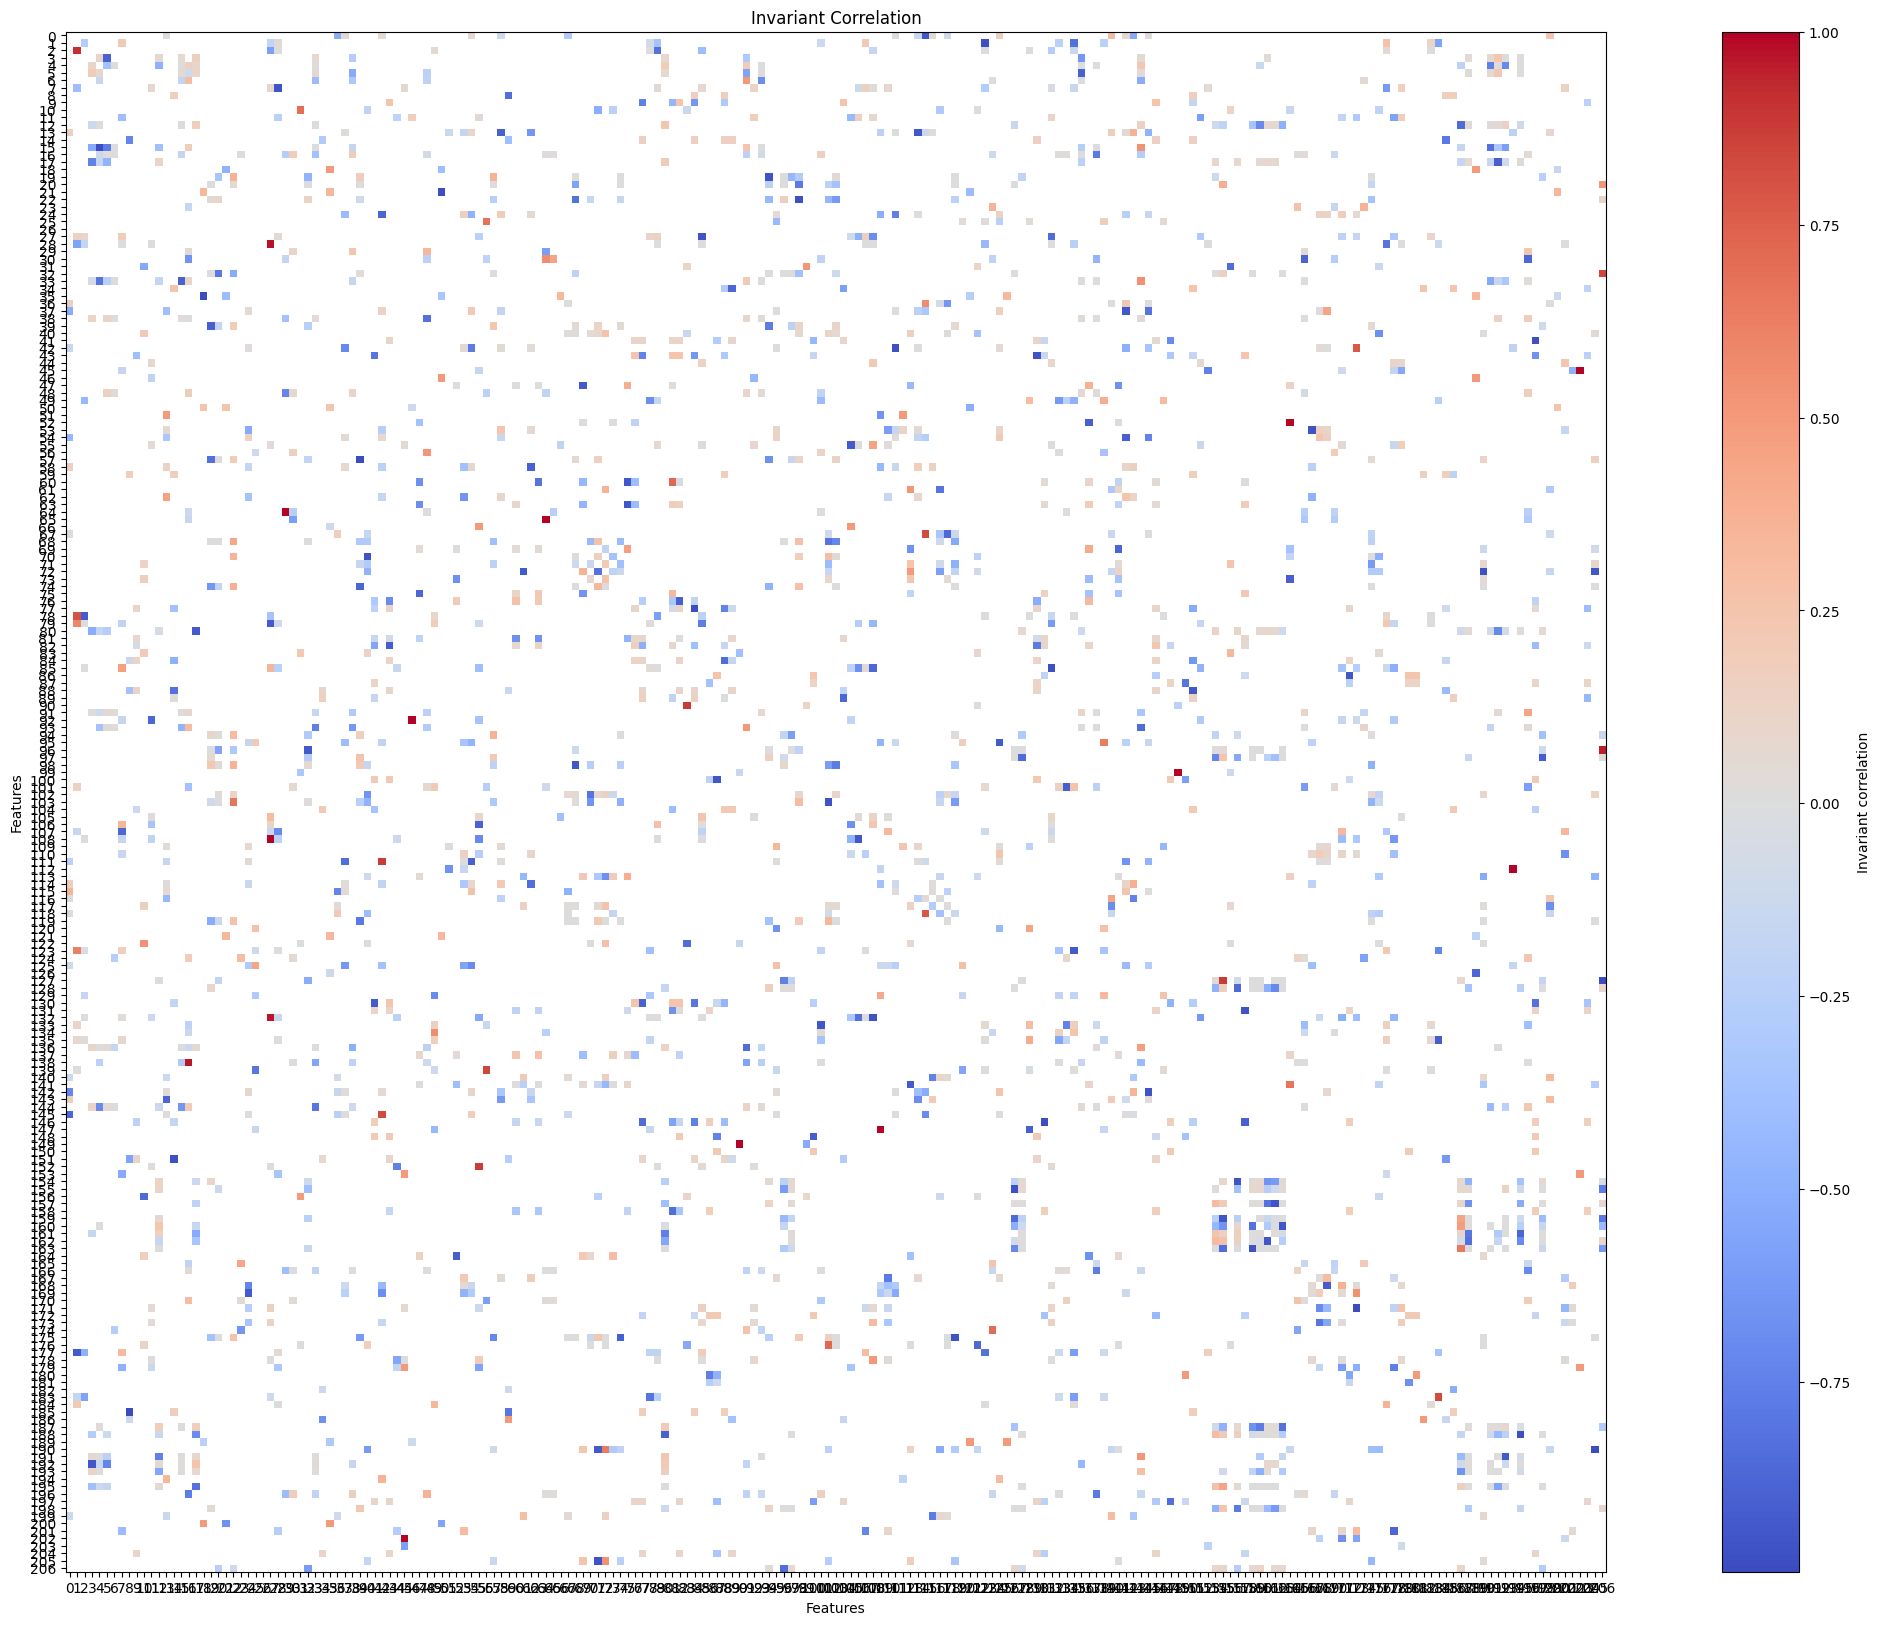

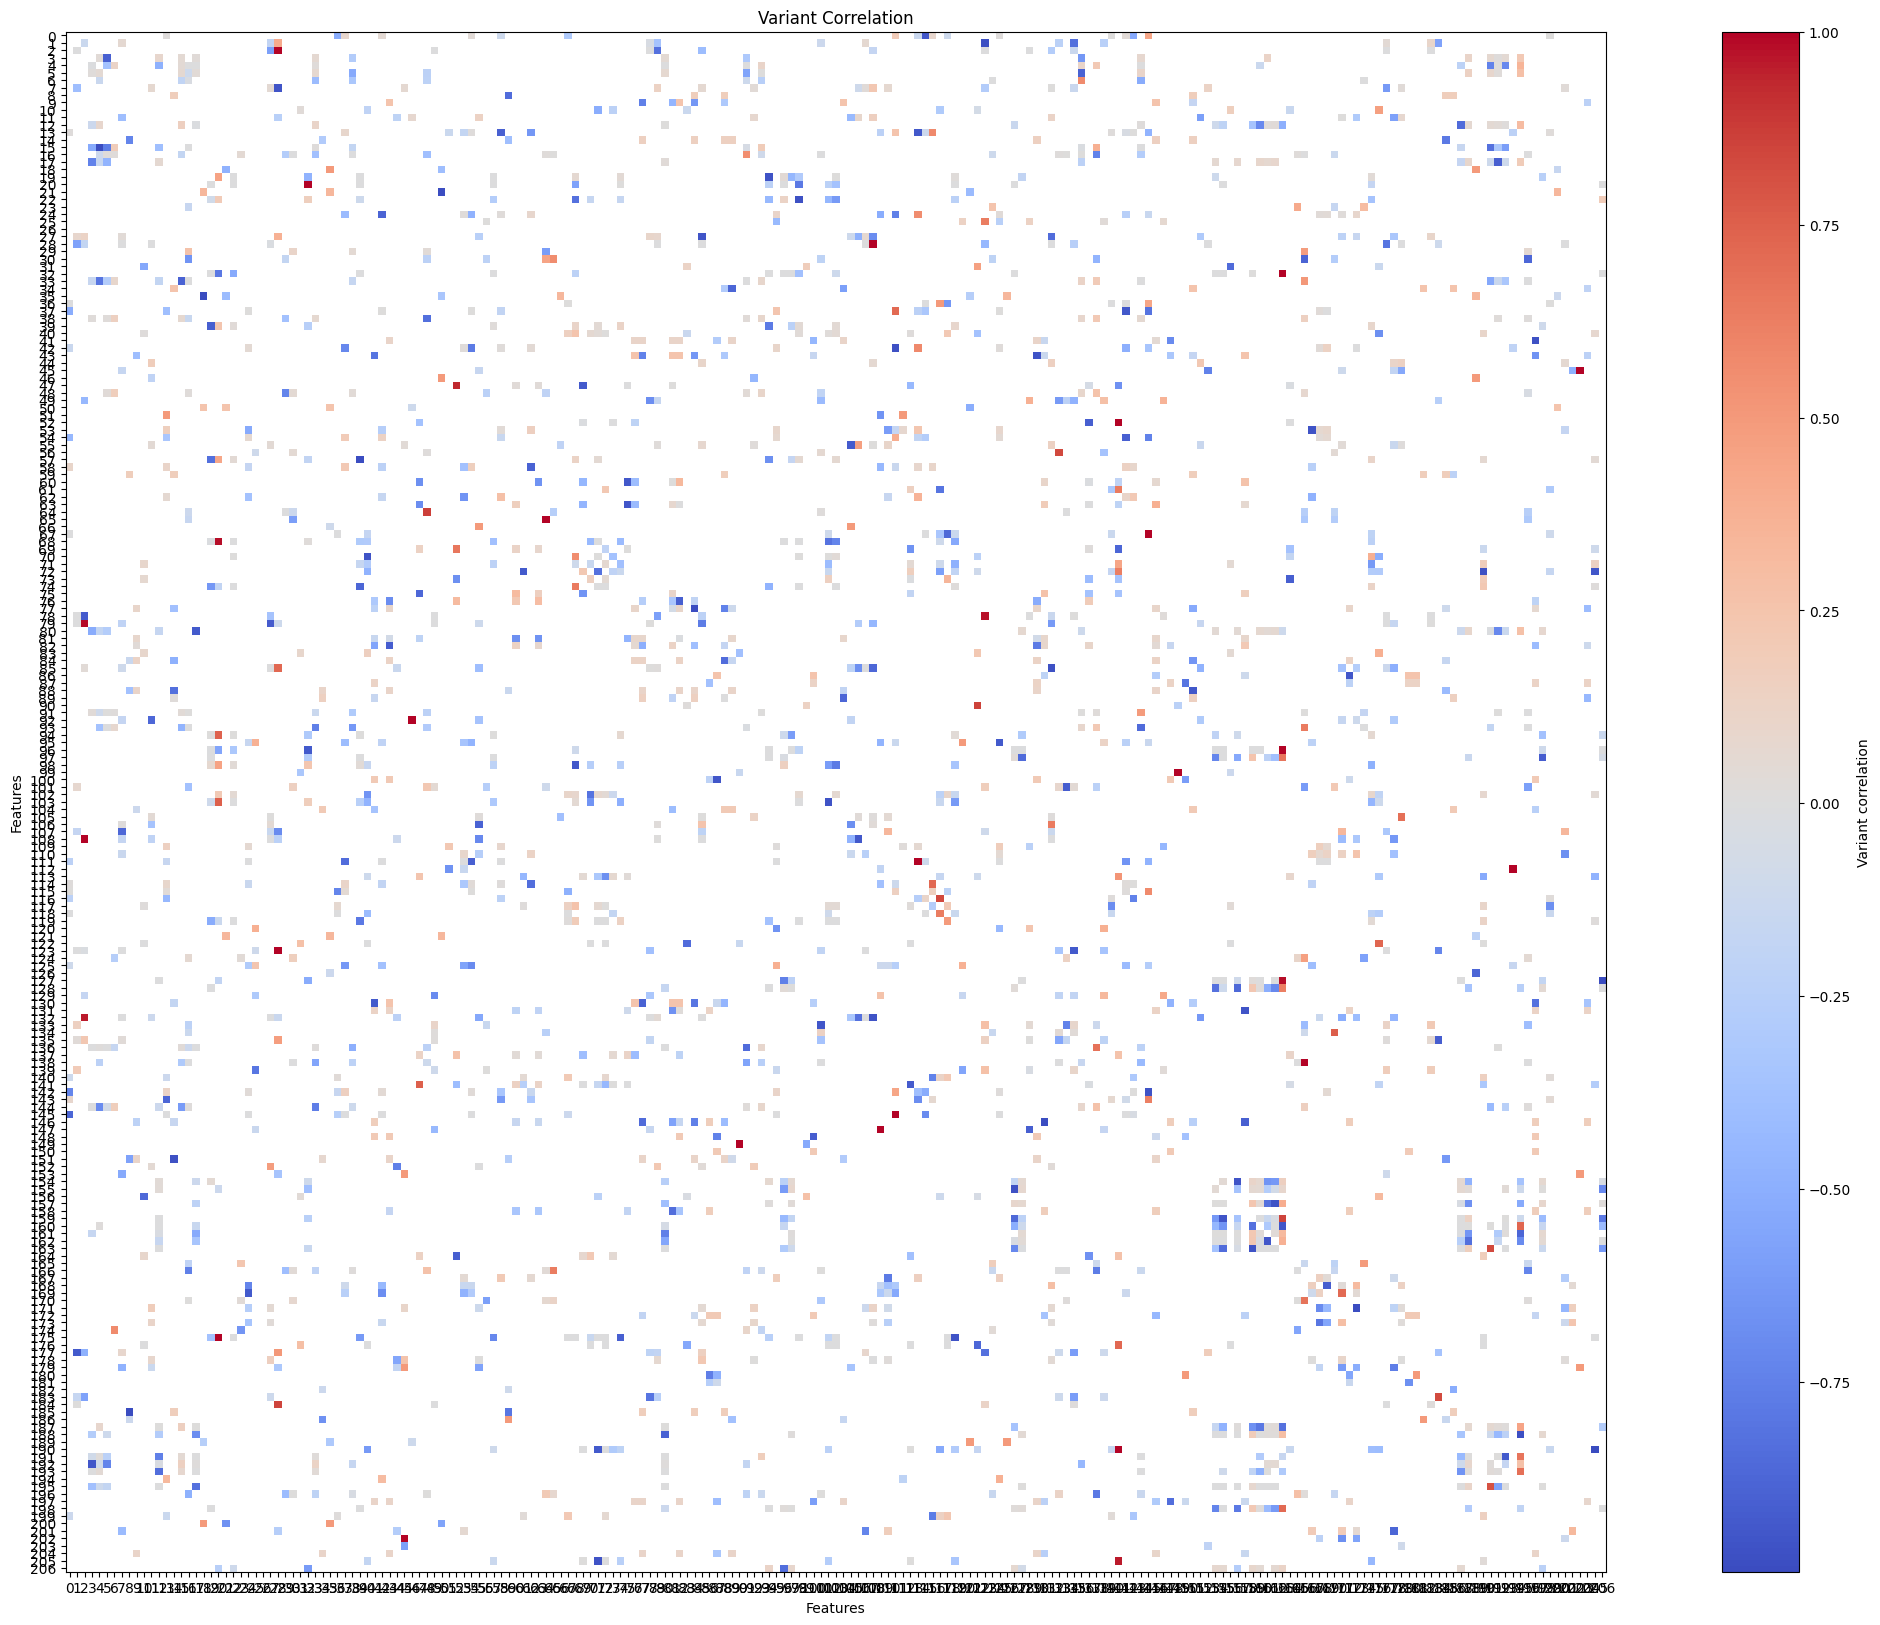

In [7]:
inv = deets[0][7]
var = deets[0][8]
ind = 5

invs = np.where(adj > 0, inv, np.ones_like(inv)*(np.nan))[ind] - adj
vars = np.where(adj > 0, var, np.ones_like(var)*(np.nan))[ind] - adj

# Plot heatmap using Matplotlib
plt.figure(figsize=(30, 20))
plt.imshow(invs, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Invariant correlation")

# Add text annotations
# for i in range(standardized_cov_matrix.shape[0]):
#     for j in range(standardized_cov_matrix.shape[1]):
#         plt.text(j, i, f"{standardized_cov_matrix[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("Invariant Correlation")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(invs.shape[0]))
plt.yticks(range(invs.shape[1]))
plt.show()

# Plot heatmap using Matplotlib
plt.figure(figsize=(30, 20))
plt.imshow(vars, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Variant correlation")

# Add text annotations
# for i in range(standardized_cov_matrix.shape[0]):
#     for j in range(standardized_cov_matrix.shape[1]):
#         plt.text(j, i, f"{standardized_cov_matrix[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("Variant Correlation")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(vars.shape[0]))
plt.yticks(range(vars.shape[1]))
plt.show()

In [20]:
ress = torch.sqrt(torch.tensor([480.8, 513.2, 465.7, 576.9, 492.1]))

torch.var(ress), torch.mean(ress)

(tensor(0.9003), tensor(22.4726))

0.16318774957136675
3.2049363
383.54666717761984


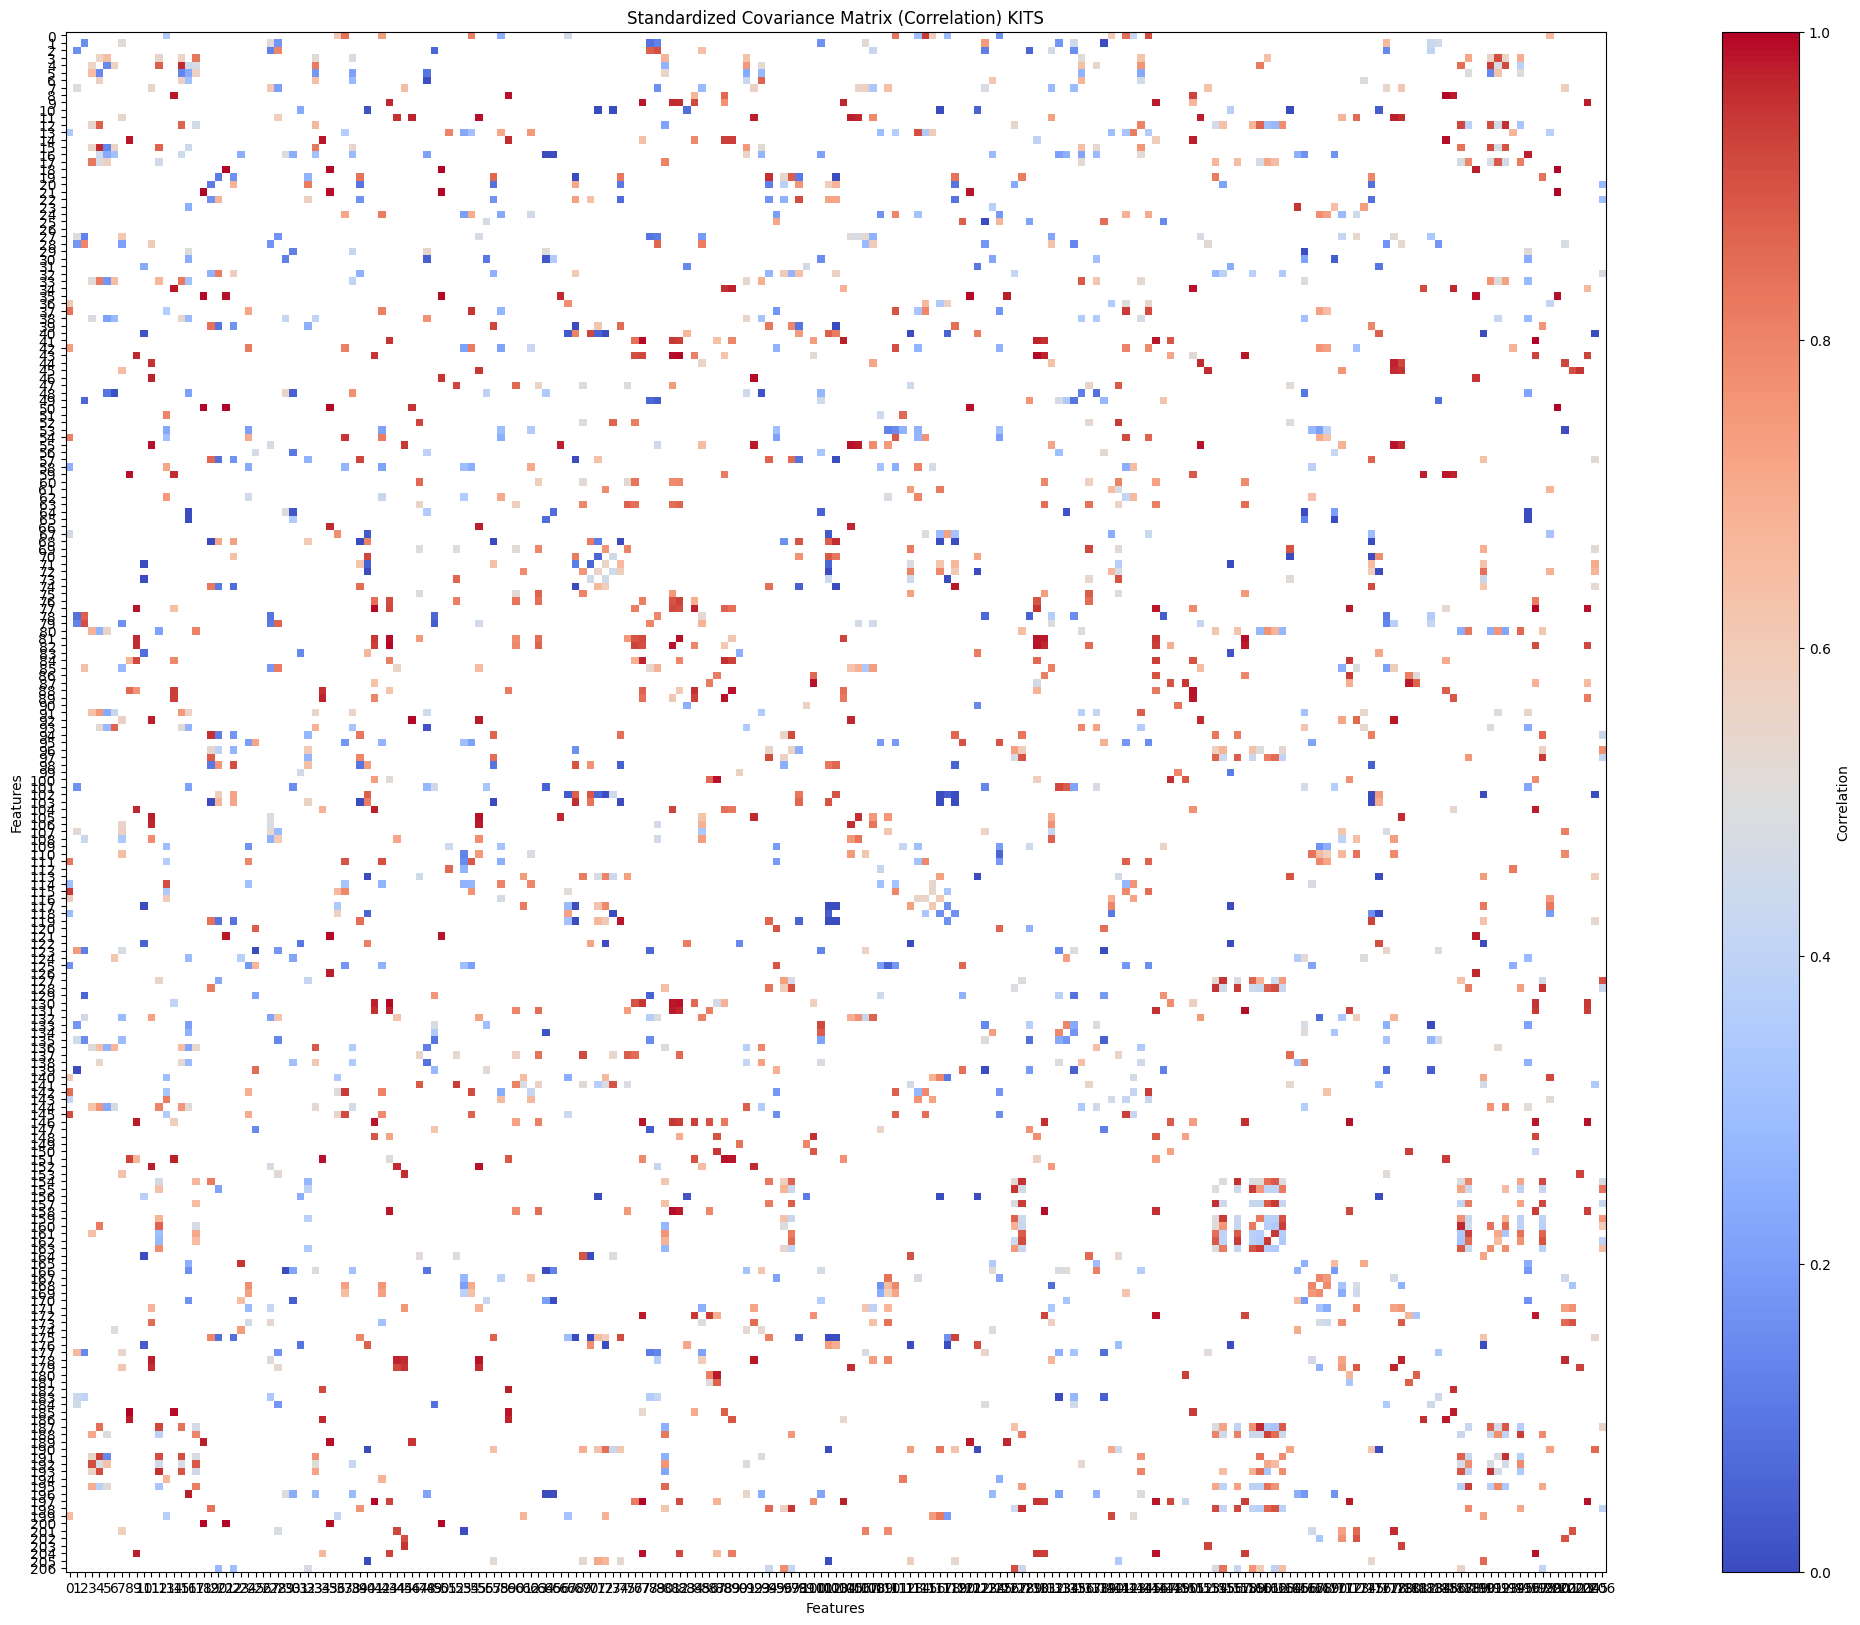

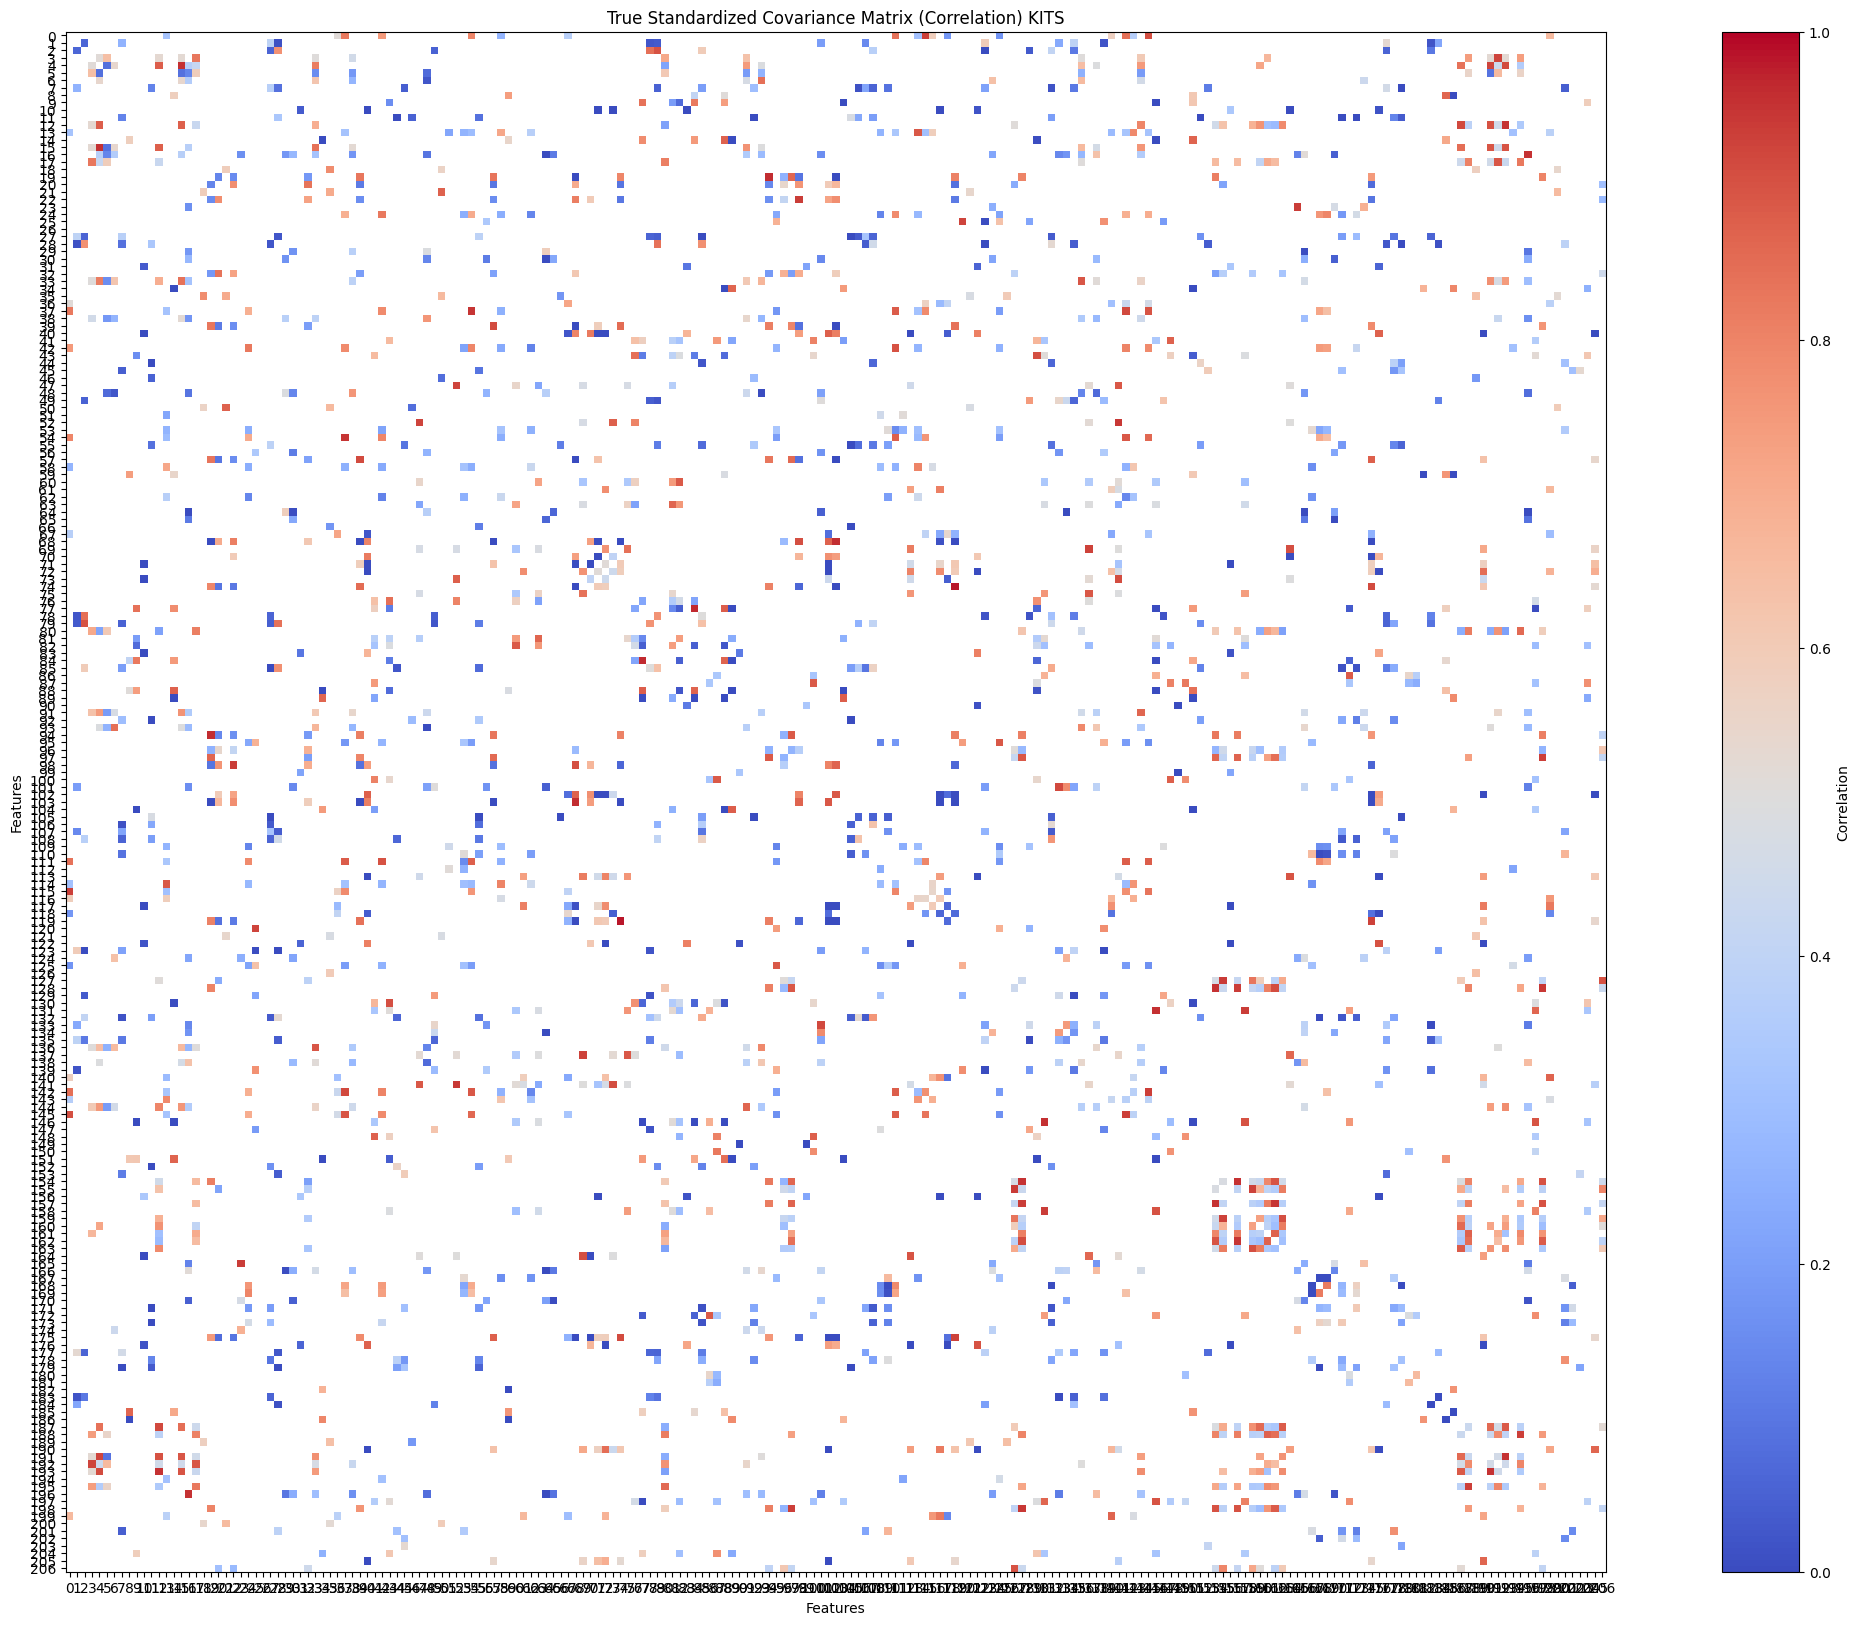

In [10]:
features_raw = deets[1]
sensors = [26, 126, 200, 21, 121, 18, 189, 50, 35, 182, 181, 180, 186, 59, 150, 8, 34, 185, 46, 66, 203, 149, 87, 100, 14, 86, 104, 112, 89, 151, 148, 172, 88, 202, 9, 51, 84, 204, 130, 41, 197, 77, 194, 43, 45, 44, 92, 153, 152, 146, 105, 120, 99, 158, 179, 131, 201, 167, 106, 82, 76, 11, 110, 178, 55, 173, 81, 62, 169]
sensors = range(0, 207)

masks = torch.tensor(sensors)
# sensors = sorted(sensors)
# known_set = [i for i in range(207) if i not in sensors]
# fin_mask = known_set + sensors

# fin_mask = torch.where(torch.sum(torch.tensor(features_raw[2]), dim=(0, 1, 3)) > 0)[0]
# masks_o = torch.where(torch.sum(torch.tensor(features_raw[2]), dim=(0, 1, 3)) == 0)[0]
# fin_mask = torch.cat([masks_o, masks])

fin_adj = adj[:, masks]
fin_adj = fin_adj[masks, :]
# print(masks)
# features_raw = features_raw[1:, :] - features_raw[:-1, :]

# Prediction
cov_mat = np.cov(features_raw[0][:, 0, :, 0], rowvar=False, bias=False)

std_devs = np.sqrt(np.diag(cov_mat))
std_dev_outer = np.outer(std_devs, std_devs)

standardized_cov_matrix = np.divide(cov_mat, std_dev_outer, where=std_dev_outer != 0)

standardized_cov_matrix = np.where(adj > 0, standardized_cov_matrix, np.ones_like(standardized_cov_matrix)*(np.nan))

# True
cov_mat = np.cov(features_raw[1][:, 0, :, 0], rowvar=False, bias=False)

std_devs = np.sqrt(np.diag(cov_mat))
std_dev_outer = np.outer(std_devs, std_devs)

standardized_cov_matrix_true = np.divide(cov_mat, std_dev_outer, where=std_dev_outer != 0)

standardized_cov_matrix_true = np.where(adj > 0, standardized_cov_matrix_true, np.ones_like(standardized_cov_matrix_true)*(np.nan))

# Mask
standardized_cov_matrix = standardized_cov_matrix[:, masks]
standardized_cov_matrix = standardized_cov_matrix[masks, :]

standardized_cov_matrix_true = standardized_cov_matrix_true[:, masks]
standardized_cov_matrix_true = standardized_cov_matrix_true[masks, :]

m_adj = adj[:, masks]
m_adj = m_adj[masks, :]

preds = features_raw[0][:, :, masks]
phats = features_raw[1][:, :, masks]

print(numpy_metrics.mae(standardized_cov_matrix_true, standardized_cov_matrix, m_adj))
print(numpy_metrics.mae(preds, phats))
print(np.nansum(standardized_cov_matrix) - np.nansum(standardized_cov_matrix_true))

# Plot heatmap using Matplotlib
plt.figure(figsize=(30, 20))
plt.imshow(standardized_cov_matrix, cmap="coolwarm", interpolation="nearest", vmin=0, vmax=1)
plt.colorbar(label="Correlation")

# Add text annotations
# for i in range(standardized_cov_matrix.shape[0]):
#     for j in range(standardized_cov_matrix.shape[1]):
#         plt.text(j, i, f"{standardized_cov_matrix[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("Standardized Covariance Matrix (Correlation) KITS")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(standardized_cov_matrix.shape[0]))
plt.yticks(range(standardized_cov_matrix.shape[1]))
plt.show()

# Plot heatmap using Matplotlib
plt.figure(figsize=(30, 20))
plt.imshow(standardized_cov_matrix_true, cmap="coolwarm", interpolation="nearest", vmin=0, vmax=1)
plt.colorbar(label="Correlation")

# Add text annotations
# for i in range(standardized_cov_matrix.shape[0]):
#     for j in range(standardized_cov_matrix.shape[1]):
#         plt.text(j, i, f"{standardized_cov_matrix[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("True Standardized Covariance Matrix (Correlation) KITS")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(standardized_cov_matrix_true.shape[0]))
plt.yticks(range(standardized_cov_matrix_true.shape[1]))
plt.show()

(tensor([  1,   2,   7,  10,  11,  27,  28,  29,  30,  31,  44,  45,  46,  48,
         49,  51,  53,  55,  58,  62,  64,  65,  66,  67,  71,  78,  79,  85,
         89,  90,  92,  96,  99, 104, 105, 106, 107, 108, 109, 110, 112, 114,
        118, 122, 123, 125, 129, 132, 135, 139, 147, 149, 152, 153, 156, 166,
        167, 170, 171, 173, 177, 178, 179, 183, 184, 194, 196, 201, 202]),)
6.322294


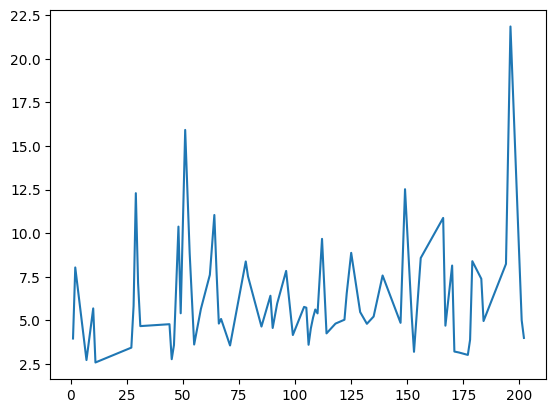

(tensor([  8,   9,  10,  18,  21,  23,  25,  26,  29,  31,  34,  35,  36,  44,
         45,  46,  47,  50,  51,  52,  56,  59,  61,  62,  64,  65,  66,  75,
         83,  86,  90,  92,  99, 100, 104, 106, 112, 116, 120, 121, 124, 126,
        129, 134, 143, 147, 148, 149, 150, 152, 153, 156, 164, 165, 170, 174,
        180, 181, 182, 183, 184, 185, 186, 189, 194, 200, 201, 202, 203]),)
6.5107884


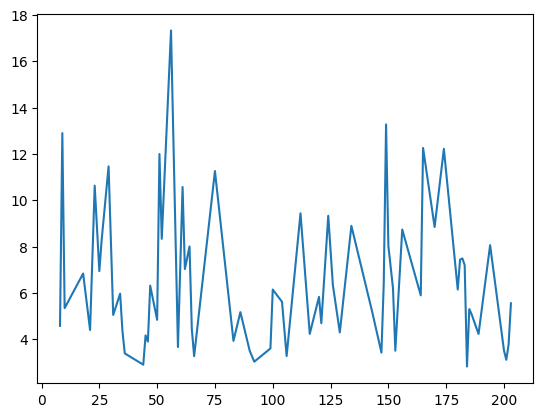

(tensor([  0,   3,   4,   5,   7,  12,  13,  15,  16,  17,  19,  20,  22,  24,
         27,  28,  32,  33,  40,  42,  43,  68,  71,  72,  77,  79,  80,  82,
         85,  91,  96,  97, 102, 103, 111, 117, 119, 125, 127, 128, 132, 136,
        138, 141, 142, 144, 146, 154, 155, 157, 159, 160, 161, 162, 163, 166,
        171, 175, 187, 188, 190, 191, 192, 193, 195, 196, 197, 198, 206]),)
9.013969


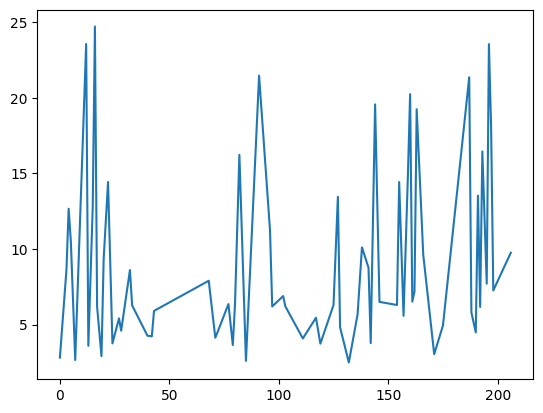

(tensor([  1,   2,   6,  11,  14,  30,  37,  38,  39,  41,  48,  49,  53,  54,
         55,  57,  58,  60,  63,  67,  69,  70,  73,  74,  76,  78,  81,  84,
         87,  88,  89,  93,  94,  95,  98, 101, 105, 107, 108, 109, 110, 113,
        114, 115, 118, 122, 123, 130, 131, 133, 135, 137, 139, 140, 145, 151,
        158, 167, 168, 169, 172, 173, 176, 177, 178, 179, 199, 204, 205]),)
6.0549407


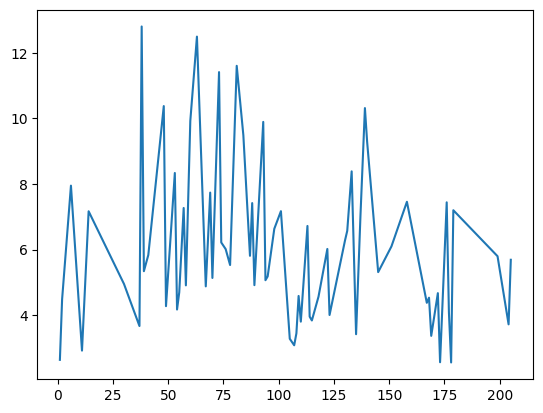

In [ ]:
features_raw = deets[1]
for features_raw in [deets[0], deets[1], deets[2], deets[3]]:
    masks = torch.where(torch.sum(torch.tensor(features_raw[2]), dim=(0, 1, 3)) > 0)
    print(masks)

    # features_raw = features_raw[1:, :] - features_raw[:-1, :]

    # features_raw = deets[0][5].dataframe().values.T
    preds = features_raw[0][:, :, masks[0]]
    phats = features_raw[1][:, :, masks[0]]

    m_adj = adj[:, masks[0]]
    m_adj = m_adj[masks[0], :]

    mape_mat = []
    for i in range(preds.shape[2]):
        mape_mat.append(numpy_metrics.mae(preds[:, :, i], phats[:, :, i]))

    print(sum(mape_mat)/len(mape_mat))
    plt.plot(masks[0], mape_mat)
    plt.show()
